In [1]:
# COMPUTE mAP
# DRAW and RECORD model detections and test images

import conf
from UI.LOG import *
import cv2
from aml.train_pipeline import *  
from aml.train_pipeline import *
import pandas as pd

import os
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor,FasterRCNN_ResNet50_FPN_Weights
from torchinfo import summary

# from torchvision.models.detection import ssd300_vgg16,SSD300_VGG16_Weights
from torchvision.models.detection.ssd import SSDClassificationHead,SSD300_VGG16_Weights,det_utils
from torchvision.models.detection import ssd300_vgg16

import torch

import aml.model_using as model_using
import aml.support_func as support_func
import aml.time_mesuarment as time_mesuarment
import sys

import aml.managers as managers
import aml.img_processing as img_processing
import random
import numpy as np
import pprint
from torchinfo import summary
from aml.img_processing import *

from PIL import Image
import aml.models as models
import matplotlib.pyplot as plt
import data_manip as dm
from pprint import pprint as Print
from PIL import Image
import warnings
from torchvision.utils import draw_bounding_boxes  
from torchvision.io.image import read_image
from torchvision.transforms.functional import to_pil_image
from torchvision.ops import nms 
from torchmetrics.detection.mean_ap import MeanAveragePrecision as mAP
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
from IPython.display import IFrame, display, HTML
import re
import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_size(table):
    return table.shape
def get_nan_distrib(table):
    names = []
    num_of_nulls = []
    n_r = table.shape[0]

    for cName in table:
        cData = table[cName]
        names.append(cName)
        num_of_nulls.append(cData.isnull().sum())
    null_percentage = [el/n_r for el in num_of_nulls]
    return names,null_percentage
def plot_count(labels, counts, title,fig_size = (9,16)):
    # Add 2D affine transformation
    fig, ax = plt.subplots()
    fig.set_size_inches(fig_size[0],fig_size[1])
    x = np.arange(len(labels))
    width = 0.3
    rects1 = ax.barh(x - width/2,counts, width)
    ax.set_yticklabels(labels, rotation=0)
    ax.set_yticks(x)
    ax.set_xlabel(title)
    return fig,ax
def get_types(table):
    types_df = table.dtypes.to_frame().to_dict()
    types_dict = {k:[v] for k,v in types_df[0].items()}
    o_df = pd.DataFrame(data=types_dict)
    return o_df
def get_examples(table):
    head_df = table.head()
    return head_df.to_html()
def get_column_names(table):
    return [cName for cName in table]
def get_table_info(table,table_name = ''):
    print('table name: {}'.format(table_name))    
    shape = get_size(table)
    n_r = shape[0]
    n_c = shape[1]
    print('num of rows {} num of columns {}'.format(n_r,n_c))
    names,num_of_nulls = get_nan_distrib(table)
    print('column names:')
    print(get_column_names(table))
    fig1_,ax1_ = plot_count(names,num_of_nulls,title='rate of null',fig_size = (16,9))
    display(HTML(get_types(table).to_html()))
    display(HTML(get_examples(table)))
    plt.show()

def get_int_distib(x):
    labels, counts = np.unique(x[np.logical_not(np.isnan(x))], return_counts=True)
    counts= counts/len(x)
    return labels, counts

def plot_int_distribution(data,fig_size=(4,3)):
    l_,c_ = get_int_distib(data)
    fig,ax = plot_count(labels=l_,counts=c_,title='distribution without nan',fig_size=fig_size)
    nan_rate = np.sum(np.isnan(data))/len(data)
    ax.set_title('nan rate {}'.format(nan_rate))
    return fig,ax
def plot_float_distribution(data,fig_size=(4,3),title=''):
    fig, ax = plt.subplots()
    fig.set_size_inches(fig_size[0],fig_size[1])
    x = []
    for i in range(len(data)):
        if np.isnan(data[i]):
            continue
        else:
            x.append(data[i])
    u_vs = np.unique(x)

    if len(x) == 0:
        ax.set_title(title +' is empty data')
    elif len(u_vs)==1:
        ax.set_title(title + ' all data is repeated with value: {}'.format(u_vs[0]))
    else:
        x = np.asarray(x)
        q25, q75 = np.percentile(x, [25, 75])
        bins = 0
        if q25==q75:
            bins = np.minimum(100,len(u_vs))
        else:
            bin_width = 2 * (q75 - q25) * len(x) ** (-1 / 3)
            bins = np.minimum(100, round((np.max(x) - np.min(x)) / bin_width))
        nan_rate = np.sum(np.isnan(data))/len(data)
        ax.set_title(title+'. n of unique values {}'.format(len(u_vs)))
        ax.set_xlabel('nan rate {}'.format(nan_rate))
        density,bins = np.histogram(x,bins=bins,density=True)
        unity_density = density / density.sum()
        widths = bins[:-1] - bins[1:]
        ax.bar(bins[1:], unity_density,width=widths)

    return fig,ax

def get_obj_distib(x_):
    x= []
    for el in x_:
        if el != '':
            x.append(el)
    labels, counts = np.unique(x, return_counts=True)
    counts= counts/len(x)
    return labels, counts

def remove_all_except_letters_and_numbers(x):
    return re.sub('[\W_]+', '', x)

def plot_object_distib(data,fig_size=(4,3),title=''):
    l_,c_ = get_obj_distib(data)
    l_ = [remove_all_except_letters_and_numbers(el) for el in l_]
    if len(l_) > 1500:
        print('title {} num unique entries {} too big'.format(title,len(l_)))
        return (0,0)
    nan_rate = 0
    for el in data:
        if el == '':
            nan_rate +=1
    nan_rate = nan_rate/len(data)
    # print(l_)
    # print(len(l_))
    fig,ax = plot_count(labels=l_,counts=c_,title='distribution without nan.'+'nan rate {}'.format(nan_rate))
    ax.set_title(title)
    return fig,ax


def get_distibution_of_columns(table,ignore_columns):
    table_types = get_types(table)
    n_c = table.shape[1]
    i_=0
    print('int columns')
    for cName in table:
        print('\r{}/{}'.format(i_,n_c-1),end='\t')
        i_+=1
        if cName in ignore_columns:
            continue
        print(cName)
        cData = table[cName].tolist()
        N_ = len(cData)
        column_type = str(table_types[cName].to_list()[0])
        if 'int' in column_type:
            print(cName)
            fig,ax = plot_int_distribution(np.array(cData, dtype = np.int64))
            print(np.unique(cData))
            plt.show()
        
    print('')

    i_ =0
    print('object columns')
    for cName in table:
        print('\r{}/{}'.format(i_,n_c-1),end='\t')
        i_+=1
        if cName in ignore_columns:
            continue
        cData = table[cName].tolist()
        N_ = len(cData)
        column_type = str(table_types[cName].to_list()[0])
        if 'object' in column_type:
            print(cName)
            fig,ax = plot_object_distib(cData,title=cName)
            print(np.unique(cData))
            plt.show()

    i_ =0
    print('float columns')
    for cName in table:
        print('\r{}/{}'.format(i_,n_c-1),end='\t')
        i_+=1
        if cName in ignore_columns:
            continue
        
        cData = table[cName].tolist()
        N_ = len(cData)
        column_type = str(table_types[cName].to_list()[0])
        if 'float' in column_type:
            print(cName)
            fig,ax = plot_float_distribution(cData,title=cName)
            print(np.unique(cData))
            plt.show()

    i_=0
    unknown_columns = []
    for cName in table:
        print('\r{}/{}'.format(i_,n_c-1),end='')
        i_+=1
        if cName in ignore_columns:
            continue
        cData = table[cName].tolist()
        N_ = len(cData)
        column_type = str(table_types[cName].to_list()[0])
        if 'float' not in column_type and 'int' not in column_type and 'object' not in column_type:
            print(cName)
            unknown_columns.append({'column name':cName,'column type':column_type})
    print('unknown types in:')
    Print(unknown_columns)



def reformat_content(table,ColumnNameLambdaPair):
    o_ = table.copy()
    for cName in table:
        o_[cName] = table[cName].apply(ColumnNameLambdaPair[cName])
    return o_





In [3]:
X = pd.read_csv(conf.train_table)
Y = pd.read_csv(conf.train_target)
X_test = pd.read_csv(conf.test_table)

int columns
1/44	acc_now_delinq
2/44	addr_state
3/44	annual_inc
4/44	chargeoff_within_12_mths
5/44	collections_12_mths_ex_med
6/44	delinq_2yrs
7/44	dti
8/44	earliest_cr_line
9/44	emp_length
10/44	fico_range_high
11/44	fico_range_low
12/44	funded_amnt
13/44	home_ownership
14/44	inq_last_12m
15/44	installment
16/44	int_rate
17/44	issue_d
18/44	loan_amnt
19/44	mort_acc
20/44	mths_since_last_delinq
21/44	mths_since_recent_bc_dlq
22/44	mths_since_recent_inq
23/44	num_accts_ever_120_pd
24/44	num_actv_bc_tl
25/44	num_rev_accts
26/44	num_sats
27/44	num_tl_120dpd_2m
28/44	num_tl_30dpd
29/44	num_tl_90g_dpd_24m
30/44	num_tl_op_past_12m
31/44	open_acc
32/44	open_il_24m
33/44	open_rv_24m
34/44	percent_bc_gt_75
35/44	pub_rec
36/44	pub_rec_bankruptcies
37/44	purpose
38/44	revol_util
39/44	tax_liens
40/44	term
41/44	title
42/44	total_acc
43/44	verification_status
44/44	zip_code

object columns
2/44	addr_state
['AK' 'AL' 'AR' 'AZ' 'CA' 'CO' 'CT' 'DC' 'DE' 'FL' 'GA' 'HI' 'IA' 'ID'
 'IL' 'IN' 'KS' 'KY' '

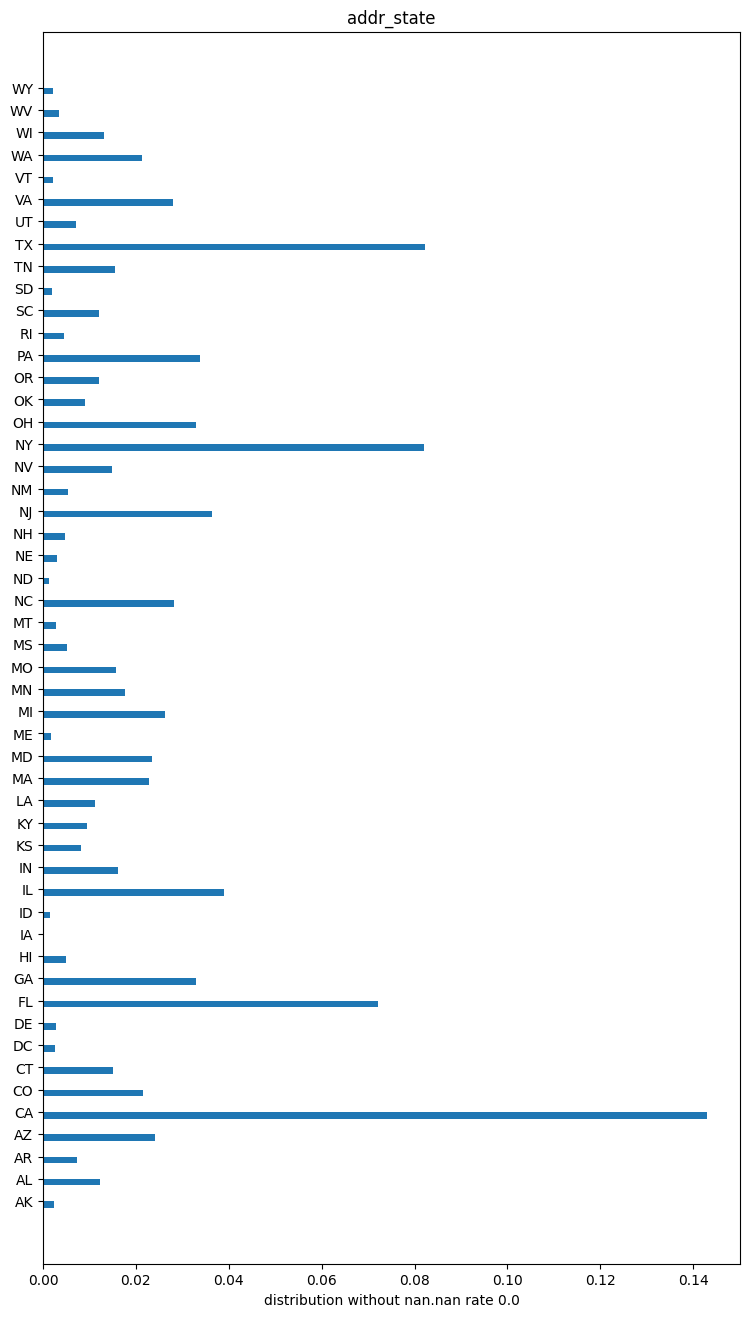

8/44	earliest_cr_line
['Apr-1934' 'Apr-1955' 'Apr-1960' 'Apr-1961' 'Apr-1962' 'Apr-1963'
 'Apr-1964' 'Apr-1965' 'Apr-1966' 'Apr-1967' 'Apr-1968' 'Apr-1969'
 'Apr-1970' 'Apr-1971' 'Apr-1972' 'Apr-1973' 'Apr-1974' 'Apr-1975'
 'Apr-1976' 'Apr-1977' 'Apr-1978' 'Apr-1979' 'Apr-1980' 'Apr-1981'
 'Apr-1982' 'Apr-1983' 'Apr-1984' 'Apr-1985' 'Apr-1986' 'Apr-1987'
 'Apr-1988' 'Apr-1989' 'Apr-1990' 'Apr-1991' 'Apr-1992' 'Apr-1993'
 'Apr-1994' 'Apr-1995' 'Apr-1996' 'Apr-1997' 'Apr-1998' 'Apr-1999'
 'Apr-2000' 'Apr-2001' 'Apr-2002' 'Apr-2003' 'Apr-2004' 'Apr-2005'
 'Apr-2006' 'Apr-2007' 'Apr-2008' 'Apr-2009' 'Apr-2010' 'Apr-2011'
 'Apr-2012' 'Apr-2013' 'Apr-2014' 'Apr-2015' 'Apr-2016' 'Aug-1941'
 'Aug-1946' 'Aug-1950' 'Aug-1957' 'Aug-1958' 'Aug-1959' 'Aug-1960'
 'Aug-1961' 'Aug-1962' 'Aug-1963' 'Aug-1964' 'Aug-1965' 'Aug-1966'
 'Aug-1967' 'Aug-1968' 'Aug-1969' 'Aug-1970' 'Aug-1971' 'Aug-1972'
 'Aug-1973' 'Aug-1974' 'Aug-1975' 'Aug-1976' 'Aug-1977' 'Aug-1978'
 'Aug-1979' 'Aug-1980' 'Aug-1981' 'Aug-1

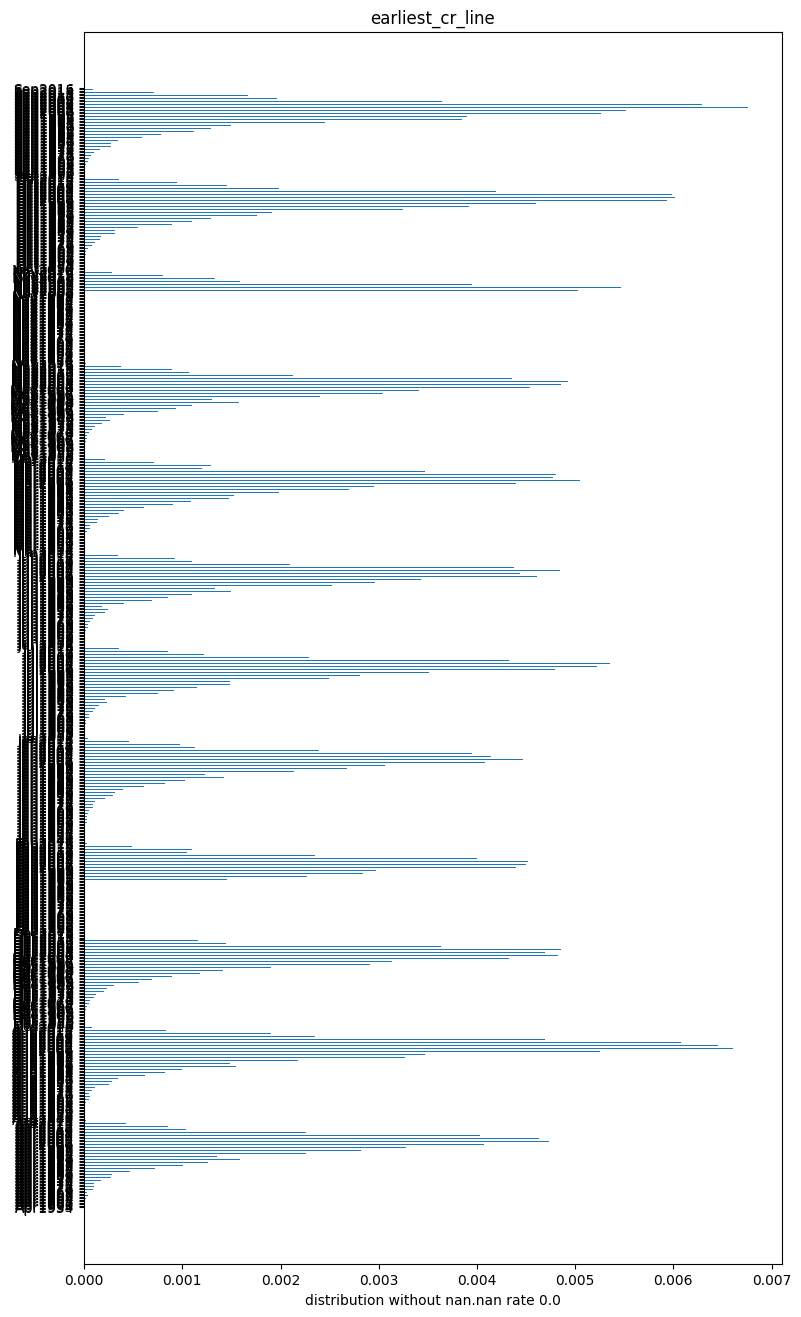

9/44	emp_length
['1 year' '10+ years' '2 years' '3 years' '4 years' '5 years' '6 years'
 '7 years' '8 years' '9 years' '< 1 year' 'nan']


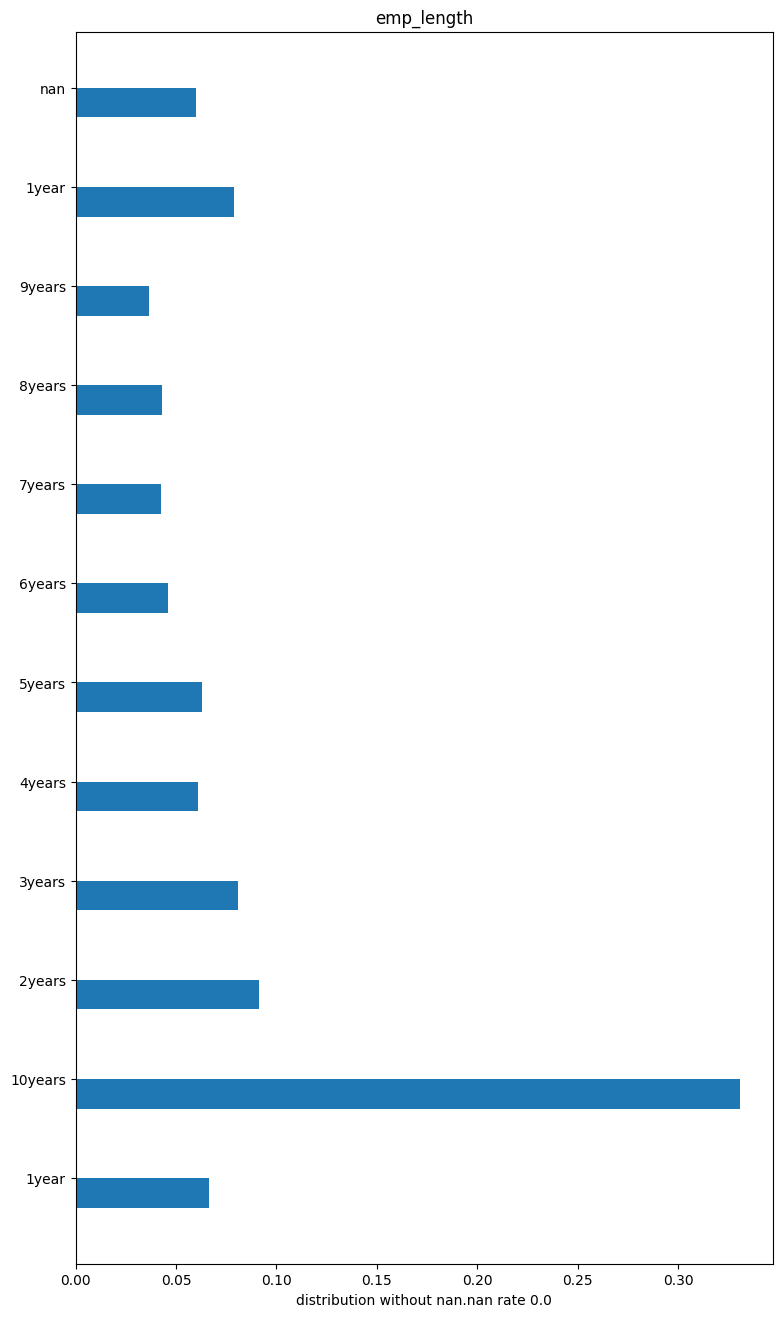

13/44	home_ownership
['ANY' 'MORTGAGE' 'NONE' 'OTHER' 'OWN' 'RENT']


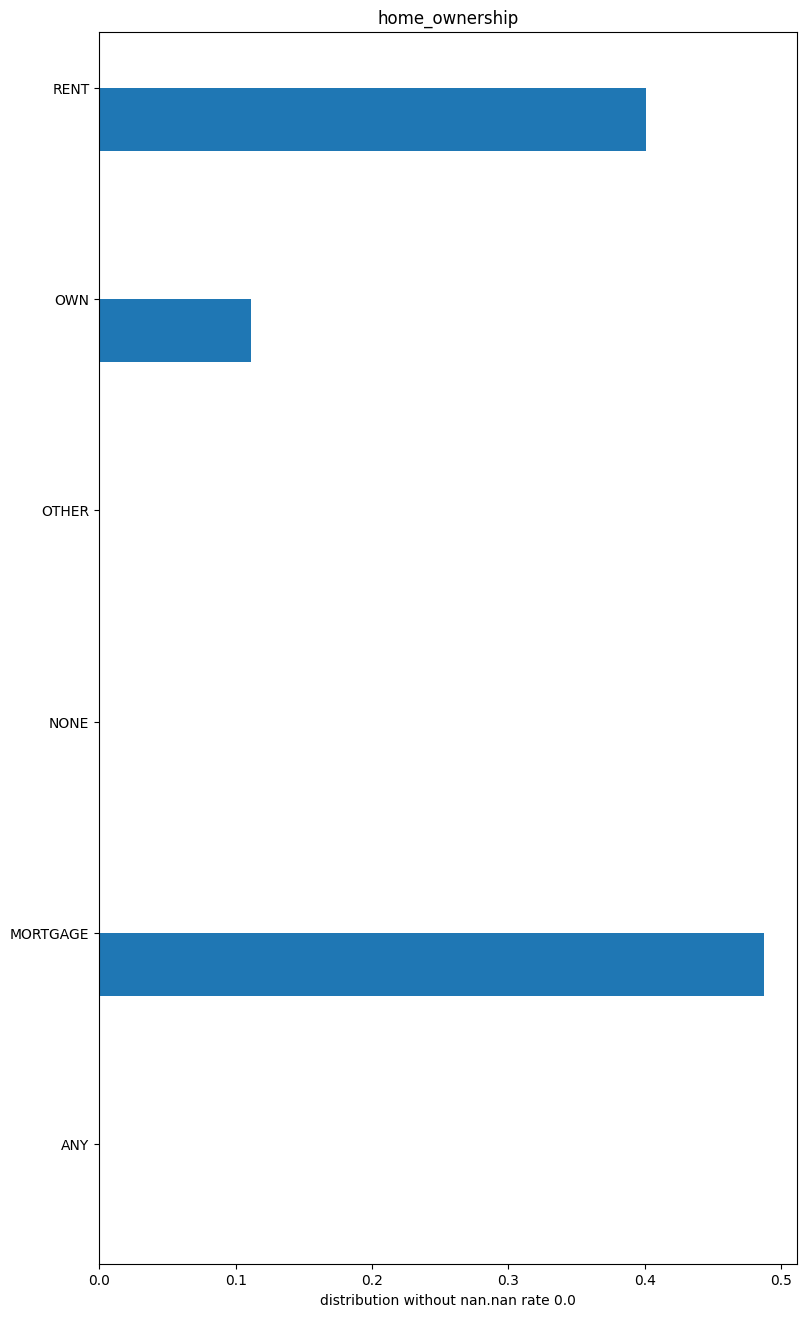

16/44	int_rate
['  5.31%' '  5.32%' '  5.42%' '  5.79%' '  5.93%' '  5.99%' '  6.00%'
 '  6.03%' '  6.07%' '  6.08%' '  6.11%' '  6.17%' '  6.19%' '  6.24%'
 '  6.39%' '  6.46%' '  6.49%' '  6.54%' '  6.62%' '  6.67%' '  6.68%'
 '  6.71%' '  6.72%' '  6.76%' '  6.83%' '  6.89%' '  6.91%' '  6.92%'
 '  6.97%' '  6.99%' '  7.02%' '  7.05%' '  7.07%' '  7.12%' '  7.14%'
 '  7.21%' '  7.24%' '  7.26%' '  7.29%' '  7.34%' '  7.35%' '  7.37%'
 '  7.39%' '  7.40%' '  7.42%' '  7.43%' '  7.46%' '  7.49%' '  7.51%'
 '  7.56%' '  7.59%' '  7.62%' '  7.66%' '  7.68%' '  7.69%' '  7.74%'
 '  7.75%' '  7.84%' '  7.88%' '  7.89%' '  7.90%' '  7.91%' '  7.96%'
 '  7.97%' '  7.99%' '  8.00%' '  8.07%' '  8.08%' '  8.18%' '  8.19%'
 '  8.24%' '  8.32%' '  8.38%' '  8.39%' '  8.46%' '  8.49%' '  8.59%'
 '  8.60%' '  8.63%' '  8.67%' '  8.70%' '  8.81%' '  8.88%' '  8.90%'
 '  8.94%' '  8.99%' '  9.01%' '  9.02%' '  9.07%' '  9.16%' '  9.17%'
 '  9.20%' '  9.25%' '  9.32%' '  9.33%' '  9.38%' '  9.43%' '

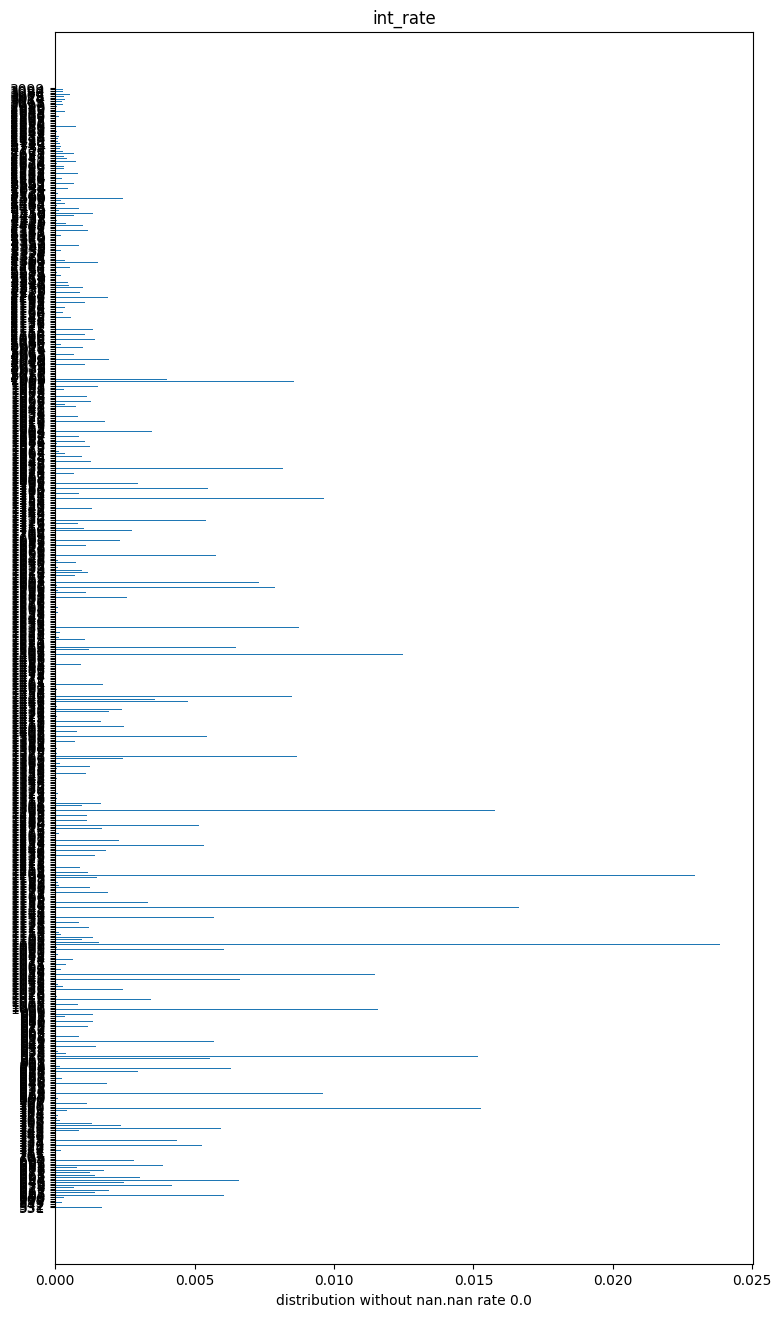

17/44	issue_d
['Apr-2008' 'Apr-2009' 'Apr-2010' 'Apr-2011' 'Apr-2012' 'Apr-2013'
 'Apr-2014' 'Apr-2015' 'Apr-2016' 'Apr-2017' 'Apr-2018' 'Apr-2019'
 'Apr-2020' 'Aug-2007' 'Aug-2008' 'Aug-2009' 'Aug-2010' 'Aug-2011'
 'Aug-2012' 'Aug-2013' 'Aug-2014' 'Aug-2015' 'Aug-2016' 'Aug-2017'
 'Aug-2018' 'Aug-2019' 'Aug-2020' 'Dec-2007' 'Dec-2008' 'Dec-2009'
 'Dec-2010' 'Dec-2011' 'Dec-2012' 'Dec-2013' 'Dec-2014' 'Dec-2015'
 'Dec-2016' 'Dec-2017' 'Dec-2018' 'Dec-2019' 'Feb-2008' 'Feb-2009'
 'Feb-2010' 'Feb-2011' 'Feb-2012' 'Feb-2013' 'Feb-2014' 'Feb-2015'
 'Feb-2016' 'Feb-2017' 'Feb-2018' 'Feb-2019' 'Feb-2020' 'Jan-2008'
 'Jan-2009' 'Jan-2010' 'Jan-2011' 'Jan-2012' 'Jan-2013' 'Jan-2014'
 'Jan-2015' 'Jan-2016' 'Jan-2017' 'Jan-2018' 'Jan-2019' 'Jan-2020'
 'Jul-2007' 'Jul-2008' 'Jul-2009' 'Jul-2010' 'Jul-2011' 'Jul-2012'
 'Jul-2013' 'Jul-2014' 'Jul-2015' 'Jul-2016' 'Jul-2017' 'Jul-2018'
 'Jul-2019' 'Jul-2020' 'Jun-2007' 'Jun-2008' 'Jun-2009' 'Jun-2010'
 'Jun-2011' 'Jun-2012' 'Jun-2013' 'Jun-2014' 'Ju

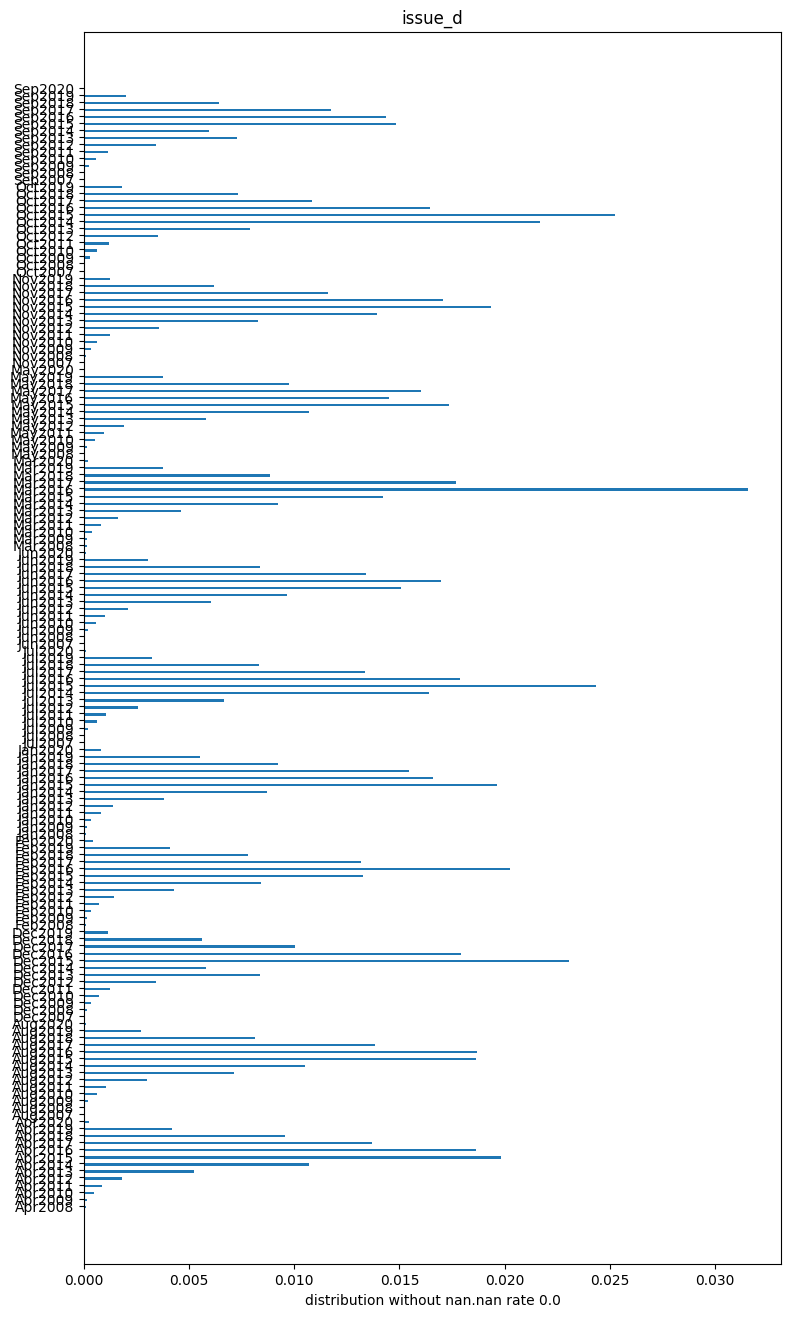

37/44	purpose
['car' 'credit_card' 'debt_consolidation' 'educational' 'home_improvement'
 'house' 'major_purchase' 'medical' 'moving' 'other' 'renewable_energy'
 'small_business' 'vacation' 'wedding']


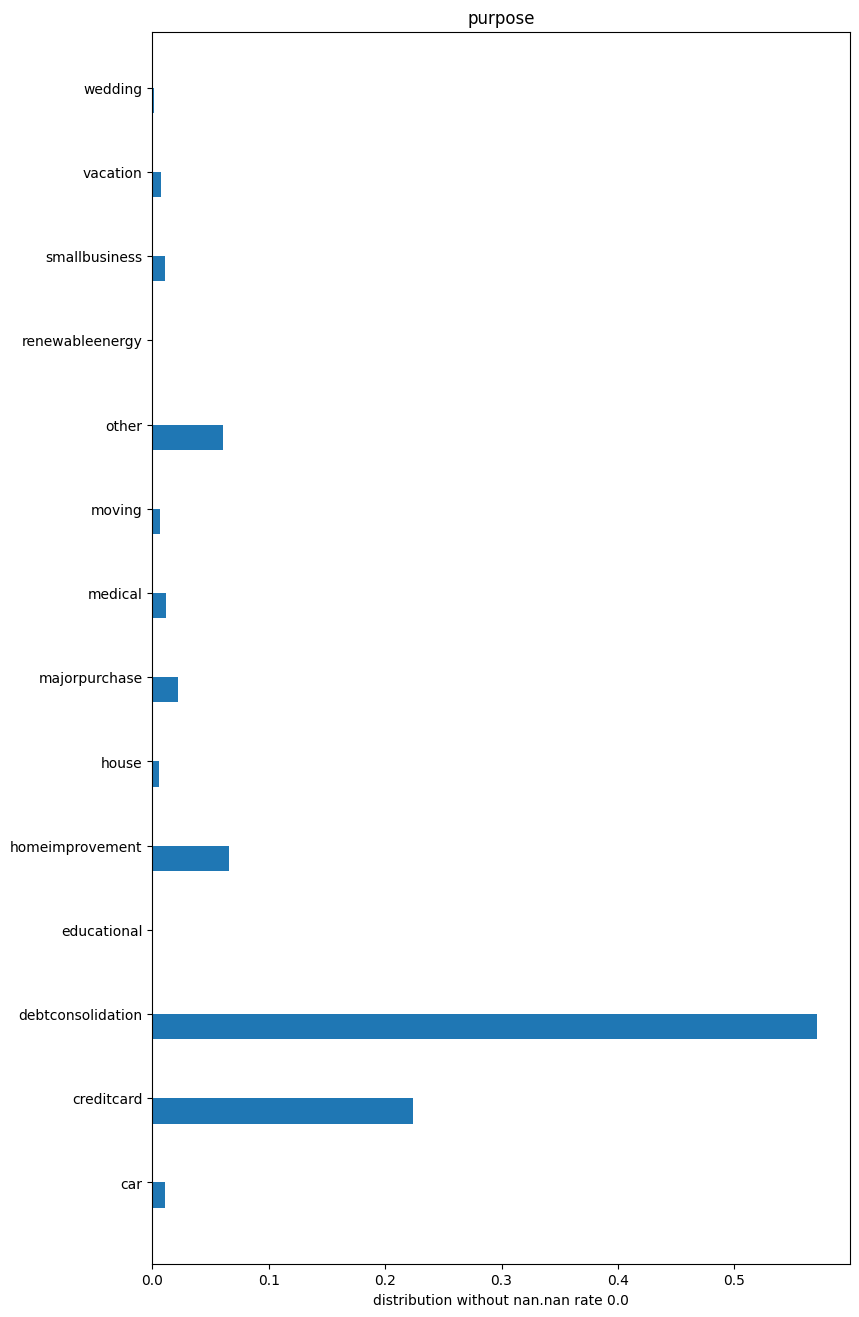

38/44	revol_util
['0%' '0.01%' '0.04%' ... '99.8%' '99.9%' 'nan']


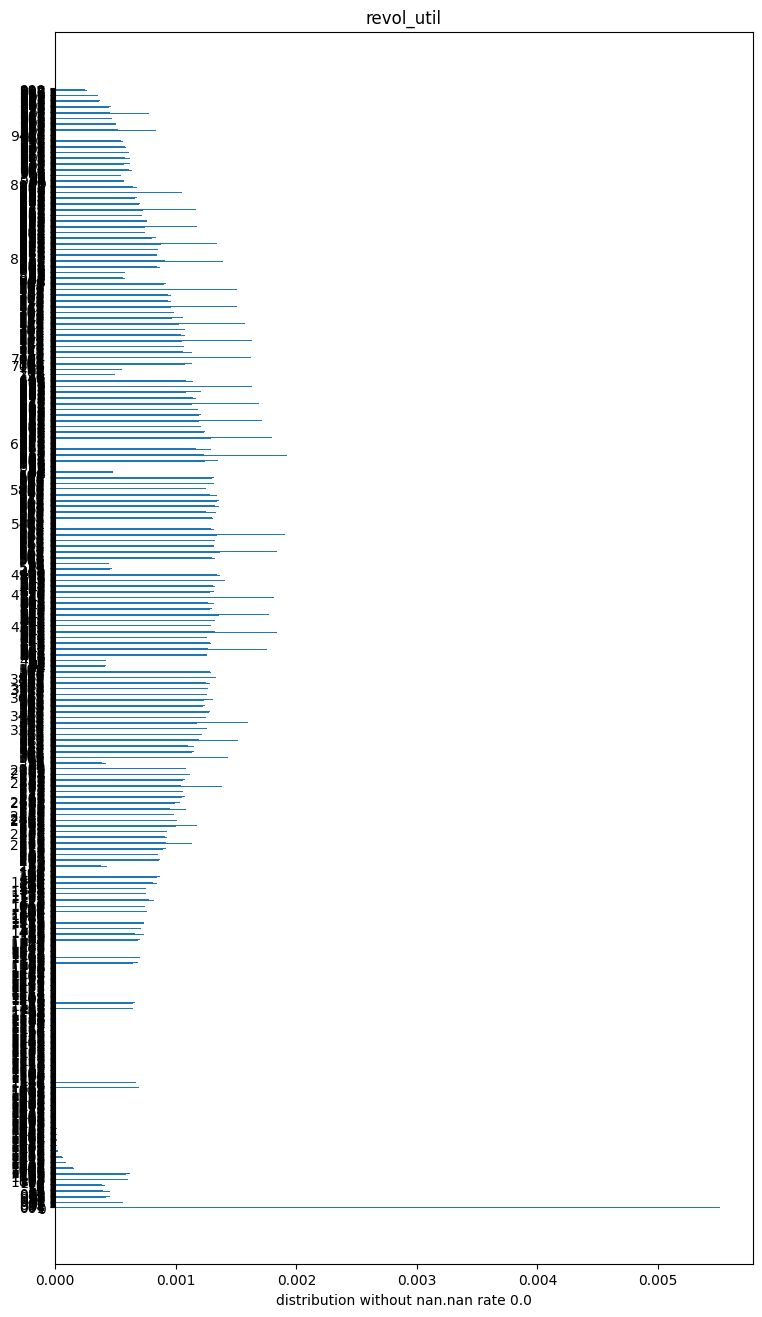

40/44	term
[' 36 months' ' 60 months']


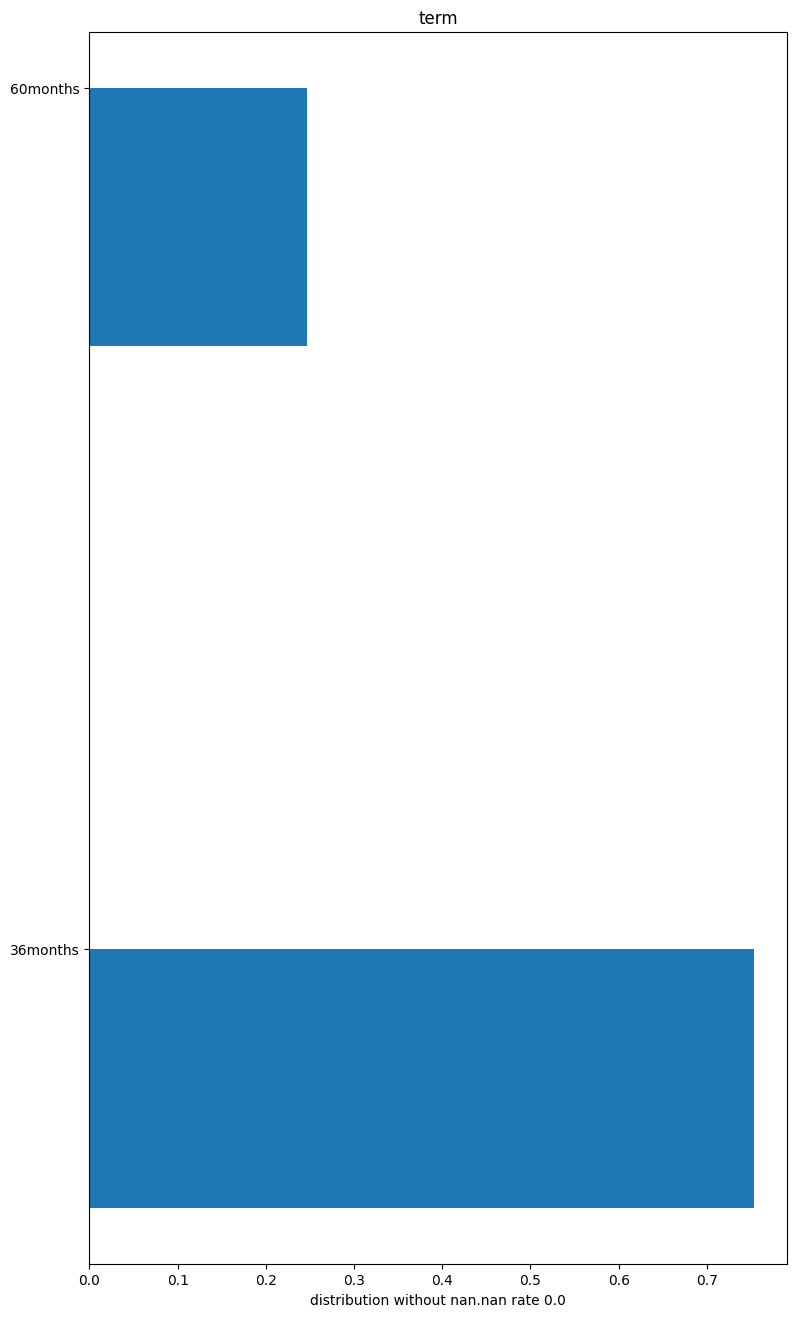

41/44	title
title title num unique entries 43859 too big
['\tcredit_card' '\tdebt_consolidation' '\tother' ... 'zeusamoose'
 'zipcar' '~Summer Fun~']
43/44	verification_status
['Not Verified' 'Source Verified' 'Verified']


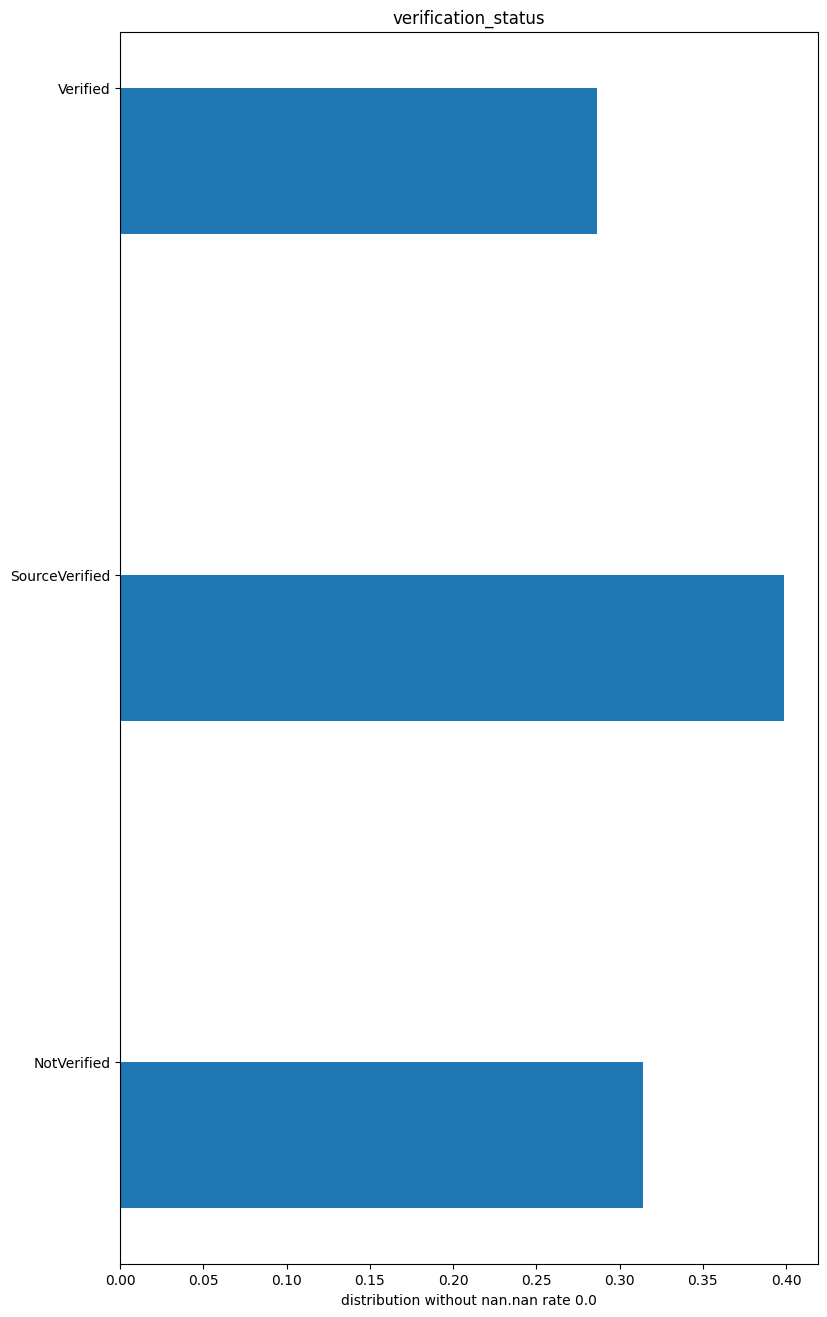

44/44	zip_code
['007xx' '008xx' '009xx' '010xx' '011xx' '012xx' '013xx' '014xx' '015xx'
 '016xx' '017xx' '018xx' '019xx' '020xx' '021xx' '022xx' '023xx' '024xx'
 '025xx' '026xx' '027xx' '028xx' '029xx' '030xx' '031xx' '032xx' '033xx'
 '034xx' '035xx' '036xx' '037xx' '038xx' '039xx' '040xx' '041xx' '042xx'
 '043xx' '044xx' '045xx' '046xx' '047xx' '048xx' '049xx' '050xx' '051xx'
 '052xx' '053xx' '054xx' '056xx' '057xx' '058xx' '059xx' '060xx' '061xx'
 '062xx' '063xx' '064xx' '065xx' '066xx' '067xx' '068xx' '069xx' '070xx'
 '071xx' '072xx' '073xx' '074xx' '075xx' '076xx' '077xx' '078xx' '079xx'
 '080xx' '081xx' '082xx' '083xx' '084xx' '085xx' '086xx' '087xx' '088xx'
 '089xx' '090xx' '091xx' '092xx' '093xx' '094xx' '095xx' '096xx' '097xx'
 '098xx' '100xx' '101xx' '102xx' '103xx' '104xx' '105xx' '106xx' '107xx'
 '108xx' '109xx' '110xx' '111xx' '112xx' '113xx' '114xx' '115xx' '116xx'
 '117xx' '118xx' '119xx' '120xx' '121xx' '122xx' '123xx' '124xx' '125xx'
 '126xx' '127xx' '128xx' '129xx' '13

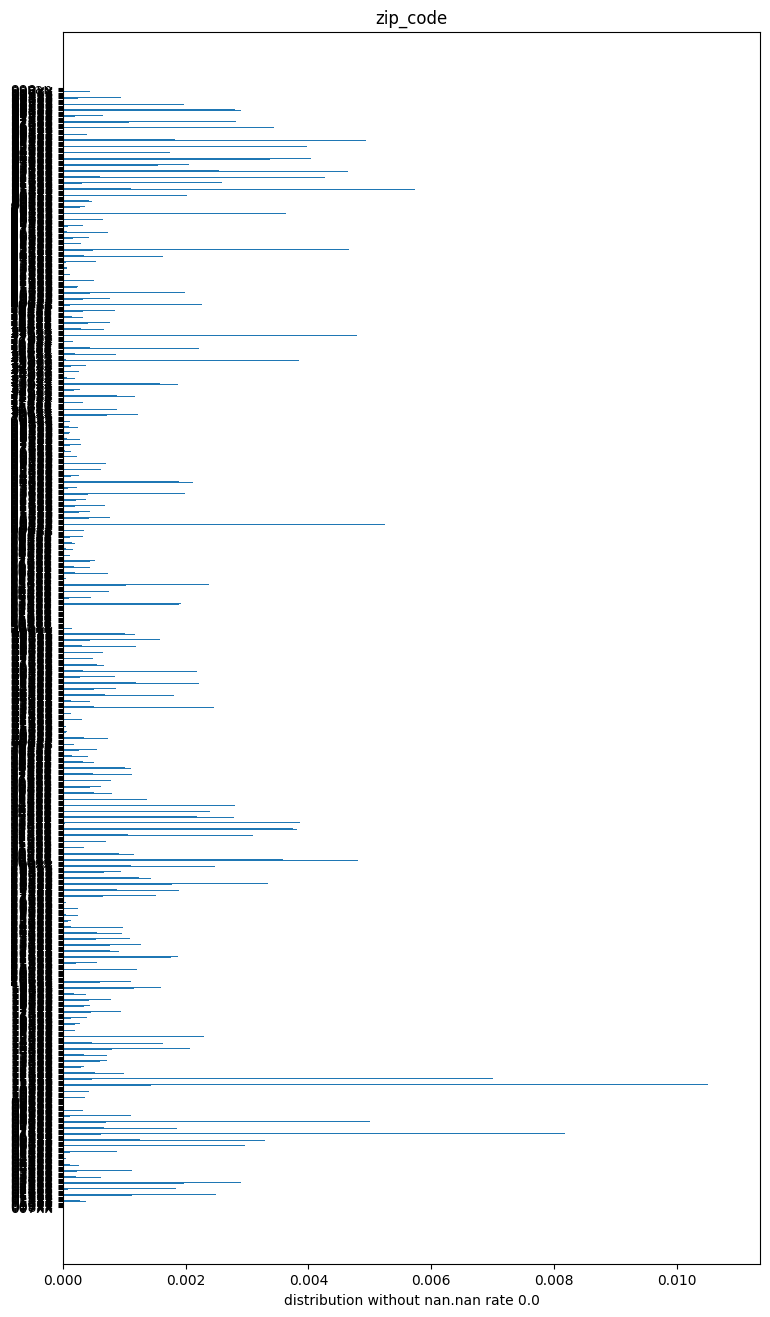

float columns
1/44	acc_now_delinq
[0. 1. 2. 3. 4. 5. 6.]


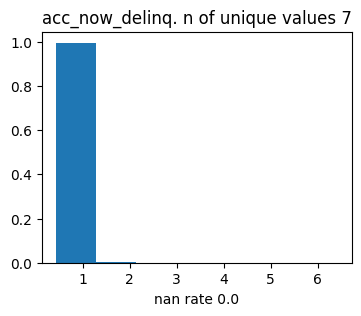

3/44	annual_inc
[2.300000e+03 2.400000e+03 2.500000e+03 ... 9.573072e+06 6.100000e+07
 1.100000e+08]


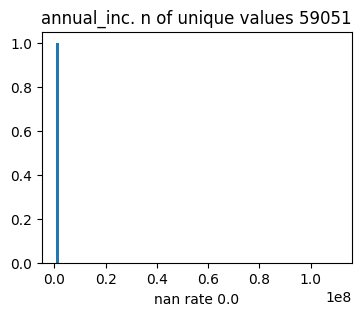

4/44	chargeoff_within_12_mths
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. nan]


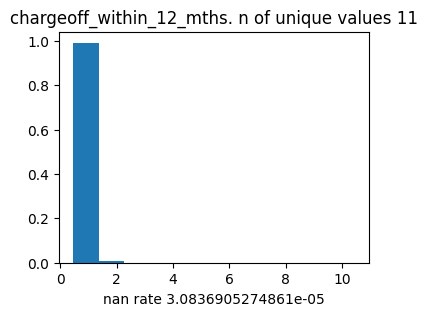

5/44	collections_12_mths_ex_med
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 12. 20. nan]


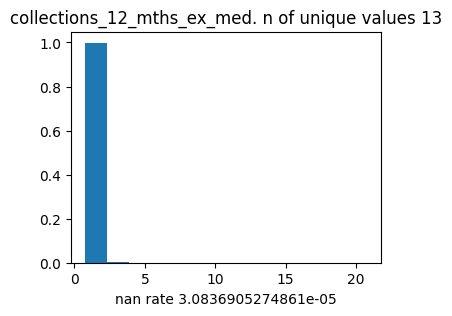

6/44	delinq_2yrs
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 24. 25. 26. 27. 28. 29. 30. 39. 42.]


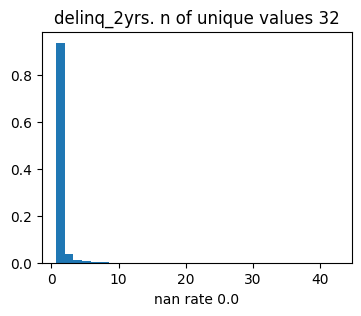

7/44	dti
[-1.000e+00  0.000e+00  1.000e-02 ...  4.994e+01  4.995e+01  4.996e+01]


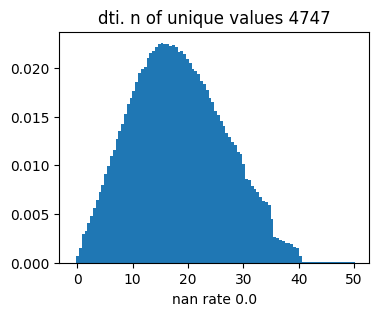

10/44	fico_range_high
[664. 669. 674. 679. 684. 689. 694. 699. 704. 709. 714. 719. 724. 729.
 734. 739. 744. 749. 754. 759. 764. 769. 774. 779. 784. 789. 794. 799.
 804. 809. 814. 819. 824. 829. 834. 839. 844. 850.]


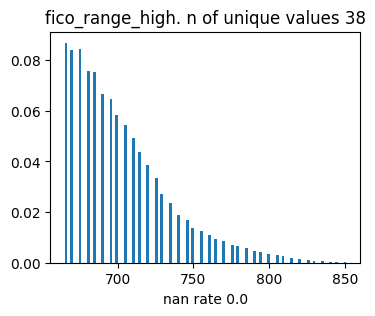

11/44	fico_range_low
[660. 665. 670. 675. 680. 685. 690. 695. 700. 705. 710. 715. 720. 725.
 730. 735. 740. 745. 750. 755. 760. 765. 770. 775. 780. 785. 790. 795.
 800. 805. 810. 815. 820. 825. 830. 835. 840. 845.]


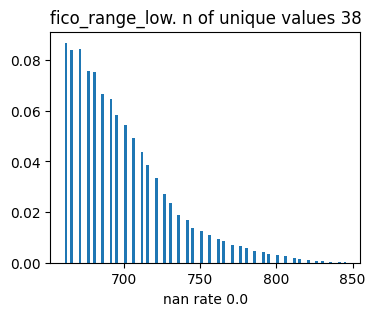

12/44	funded_amnt
[  500.   725.   750. ... 39950. 39975. 40000.]


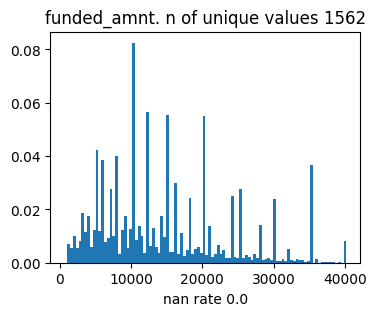

14/44	inq_last_12m
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 38. 39. 40. 41. 42. 45. 46. 49. nan]


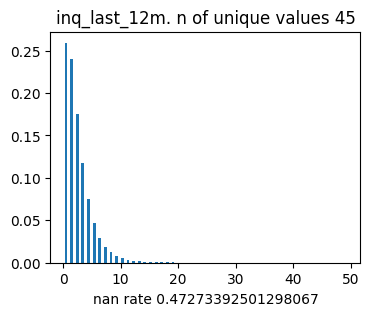

15/44	installment
[   4.93   14.01   14.77 ... 1715.42 1717.63 1719.83]


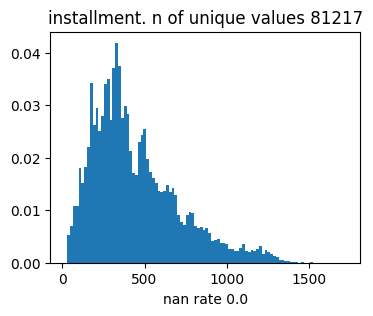

18/44	loan_amnt
[  500.   725.   750. ... 39950. 39975. 40000.]


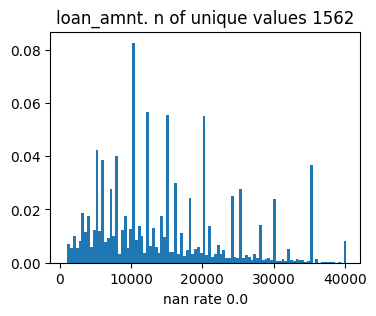

19/44	mort_acc
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 34. 35. 36.
 45. 47. 61. nan]


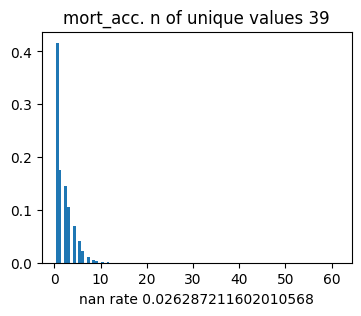

20/44	mths_since_last_delinq
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 145. 146. 149. 151. 152. 153. 154. 157. 158. 159.
 160. 161. 162. 168. 171. 176. 178. 179. 180. 188. 192. 195. 226.  nan]


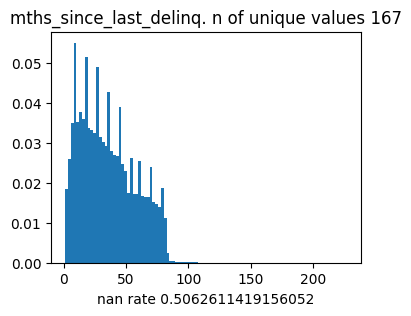

21/44	mths_since_recent_bc_dlq
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 148. 149. 150. 151. 152. 153. 154.
 155. 156. 157. 158. 159. 160. 161. 162. 165. 171. 176. 188. 194. 198.
  nan]


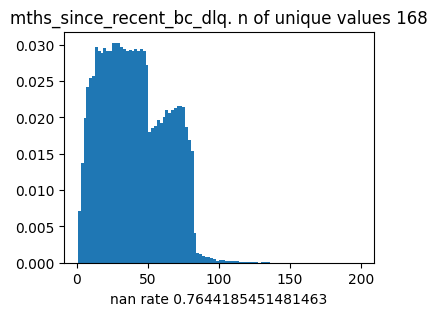

22/44	mths_since_recent_inq
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. nan]


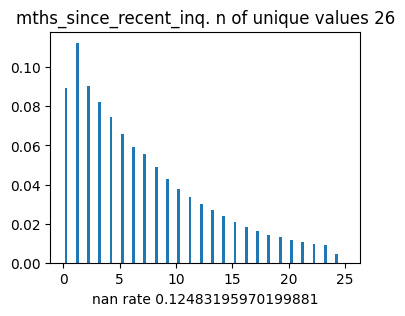

23/44	num_accts_ever_120_pd
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 42. 45. 51. nan]


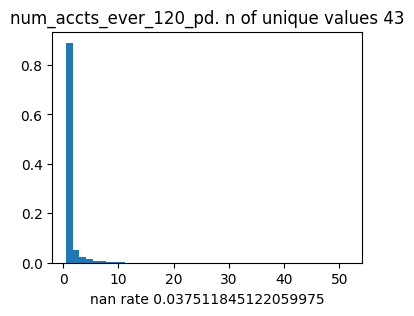

24/44	num_actv_bc_tl
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 32. 33. 45. 46. 50.
 nan]


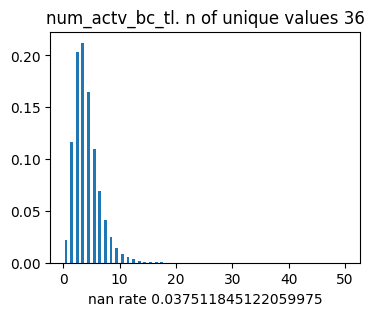

25/44	num_rev_accts
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  89.  90.  91.  92.  93.  94.  95.  96.  98.  99.
 100. 101. 102. 103. 104. 105. 107. 112. 113. 116. 117. 127. 128.  nan]


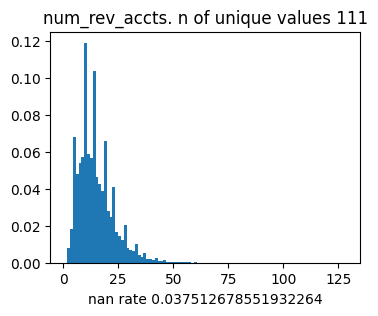

26/44	num_sats
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 67. 68. 69. 70. 71. 72.
 74. 75. 76. 77. 78. 79. 80. 81. 85. 87. 90. nan]


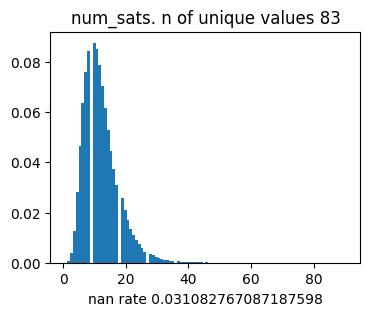

27/44	num_tl_120dpd_2m
[ 0.  1.  2.  3.  4.  6. nan]


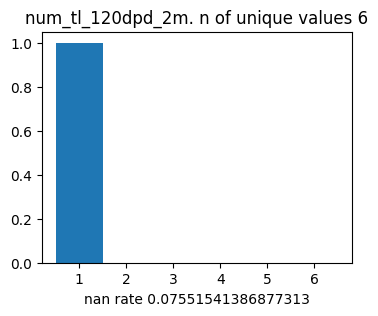

28/44	num_tl_30dpd
[ 0.  1.  2.  3.  4. nan]


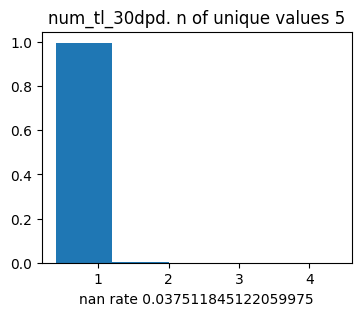

29/44	num_tl_90g_dpd_24m
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 24. 26. 29. 30. 39. 42. nan]


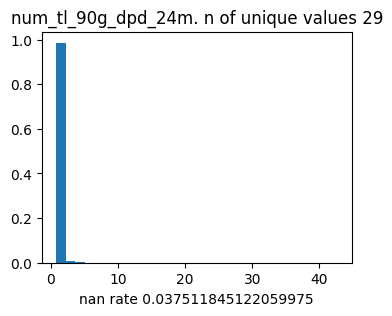

30/44	num_tl_op_past_12m
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 28. 29. 30. 31. 32. nan]


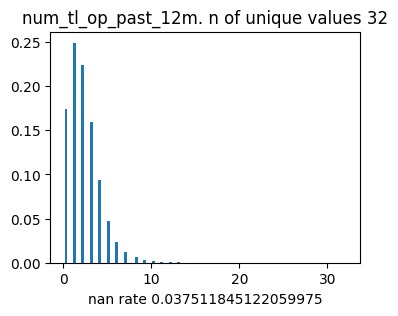

31/44	open_acc
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 68. 69. 70. 71. 72.
 74. 75. 76. 77. 78. 79. 80. 81. 86. 88. 90.]


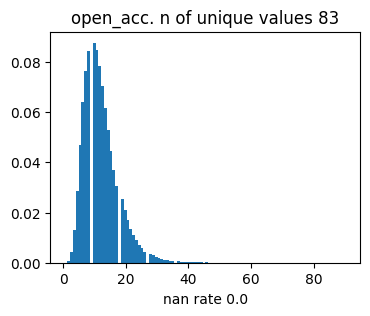

32/44	open_il_24m
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 26. 31. 39. nan]


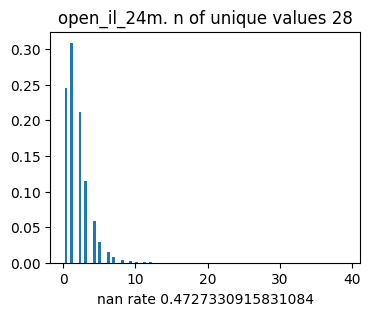

33/44	open_rv_24m
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 42. 44. 45. 53. 54. nan]


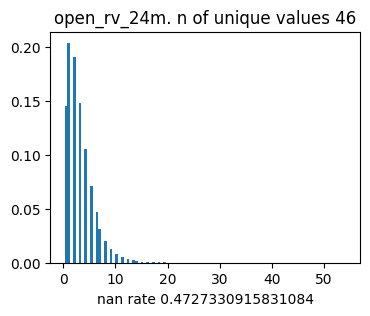

34/44	percent_bc_gt_75
[  0.     0.14   0.17   0.2    0.25   0.29   0.33   0.38   0.4    0.43
   0.5    0.57   0.6    0.63   0.67   0.71   0.75   0.8    0.82   0.86
   1.     1.9    2.2    2.6    2.7    2.9    3.     3.1    3.2    3.3
   3.4    3.6    3.7    3.8    4.     4.2    4.3    4.5    4.8    5.
   5.3    5.6    5.9    6.1    6.2    6.3    6.7    6.9    7.1    7.4
   7.5    7.7    8.     8.3    8.7    9.1    9.5   10.    10.3   10.5
  10.7   11.1   11.5   11.8   12.    12.5   13.    13.3   13.6   13.8
  14.3   14.7   14.8   15.    15.4   15.6   15.8   16.    16.7   17.2
  17.4   17.6   17.9   18.2   18.5   18.7   18.8   19.    19.2   20.
  20.8   21.1   21.4   21.7   22.2   22.7   23.1   23.5   23.8   24.1
  25.    25.9   26.1   26.3   26.5   26.7   26.9   27.3   27.8   28.
  28.1   28.6   29.2   29.4   30.    30.4   30.8   31.    31.2   31.3
  31.6   31.8   32.1   33.3   34.8   35.    35.3   35.7   36.4   36.7
  36.8   37.5   38.1   38.5   38.9   39.1   39.3   40.    40.7   40.

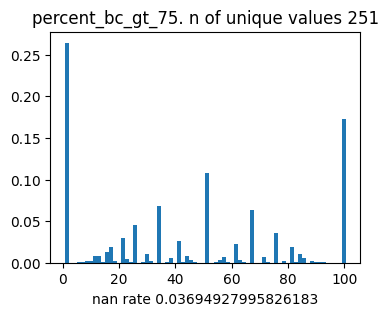

35/44	pub_rec
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 24. 25. 28. 31. 32. 37. 40. 44. 47. 49. 61. 86.]


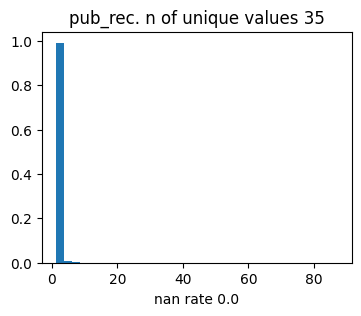

36/44	pub_rec_bankruptcies
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 12. nan]


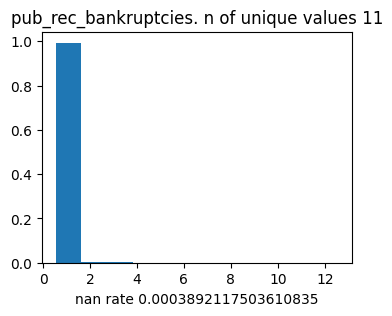

39/44	tax_liens
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 27. 28. 29. 30. 37. 39. 44. 46. 48. 61. 85.
 nan]


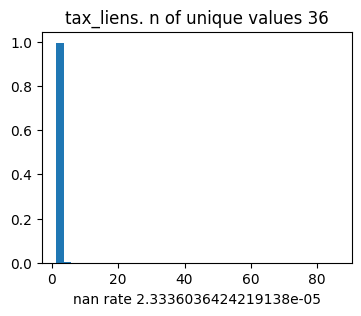

42/44	total_acc
[  2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.
  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.
  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.
  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.
  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99.
 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112. 113.
 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126. 129.
 130. 133. 135. 137. 138. 141. 142. 144. 146. 148. 151. 156. 157. 162.
 165. 173.]


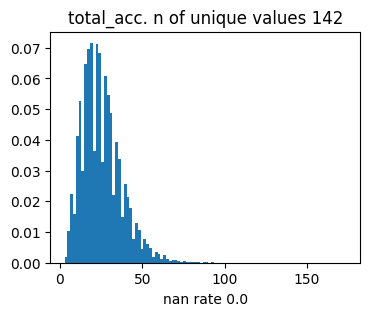

44/44unknown types in:
[]


In [4]:
get_distibution_of_columns(X,ignore_columns=['index'])

table name: X train
num of rows 1199861 num of columns 45
column names:
['index', 'acc_now_delinq', 'addr_state', 'annual_inc', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'delinq_2yrs', 'dti', 'earliest_cr_line', 'emp_length', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'home_ownership', 'inq_last_12m', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'mort_acc', 'mths_since_last_delinq', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_rev_accts', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'open_acc', 'open_il_24m', 'open_rv_24m', 'percent_bc_gt_75', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_util', 'tax_liens', 'term', 'title', 'total_acc', 'verification_status', 'zip_code']


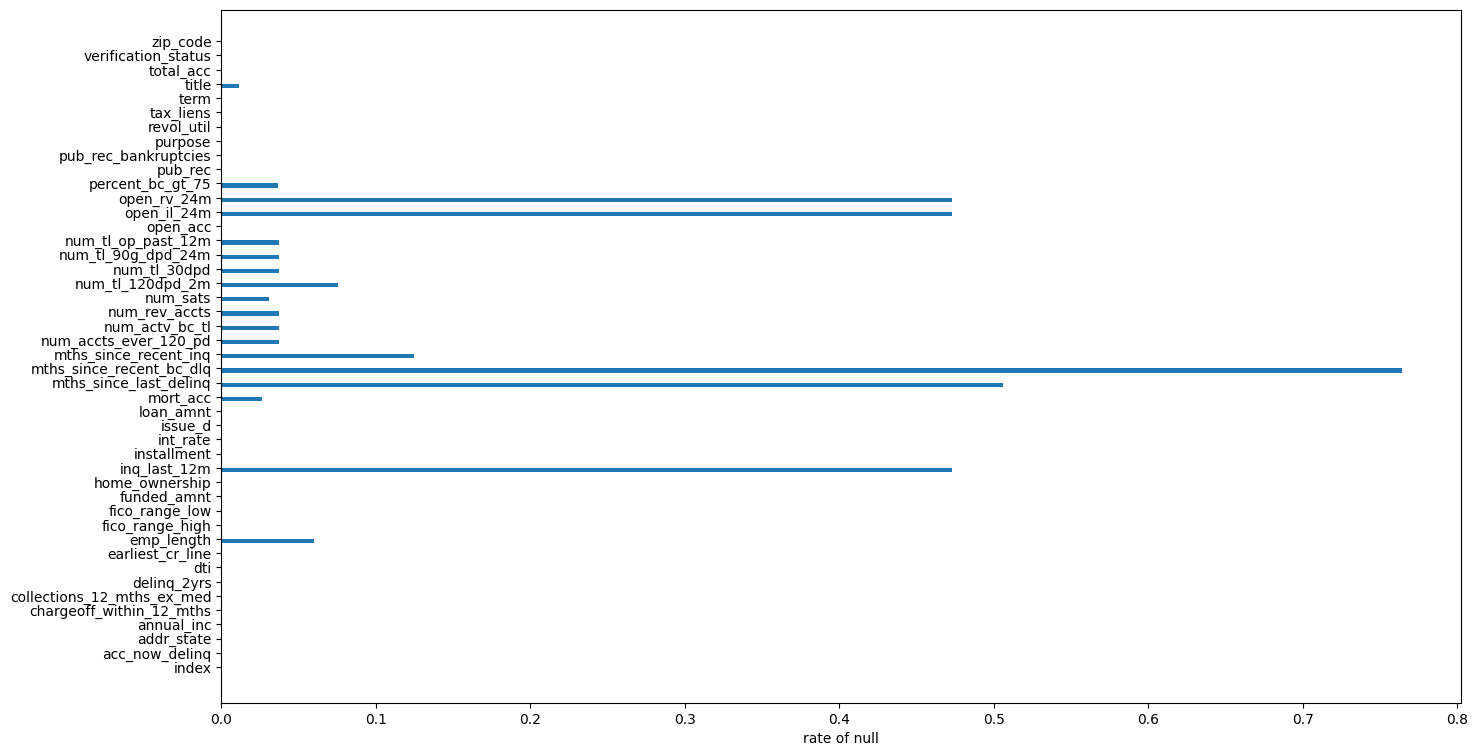

In [5]:
get_table_info(X,table_name='X train')

table name: test table
num of rows 590977 num of columns 45
column names:
['index', 'acc_now_delinq', 'addr_state', 'annual_inc', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'delinq_2yrs', 'dti', 'earliest_cr_line', 'emp_length', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'home_ownership', 'inq_last_12m', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'mort_acc', 'mths_since_last_delinq', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_rev_accts', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'open_acc', 'open_il_24m', 'open_rv_24m', 'percent_bc_gt_75', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_util', 'tax_liens', 'term', 'title', 'total_acc', 'verification_status', 'zip_code']


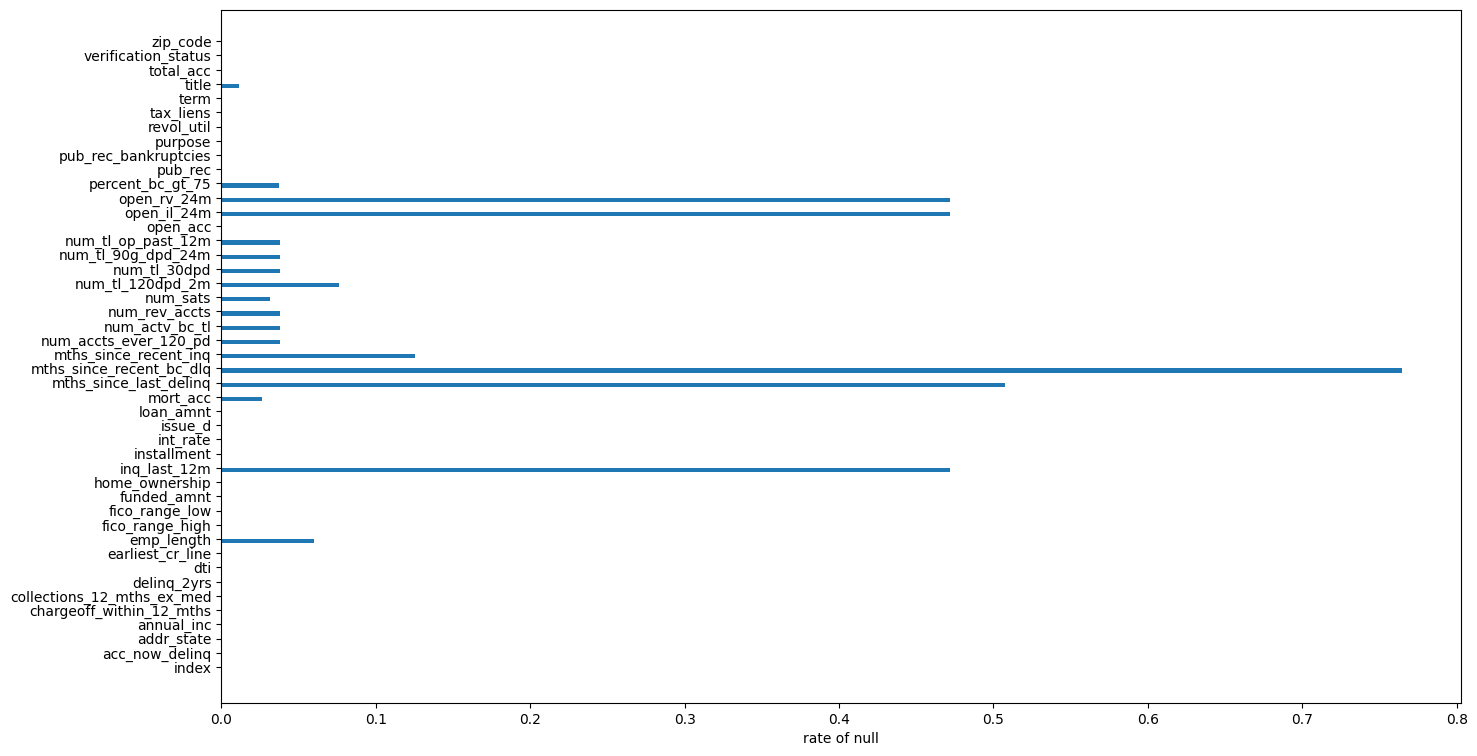

In [6]:
get_table_info(X_test,table_name='test table')


table name: train target
num of rows 1199861 num of columns 2
column names:
['index', 'loan_status']


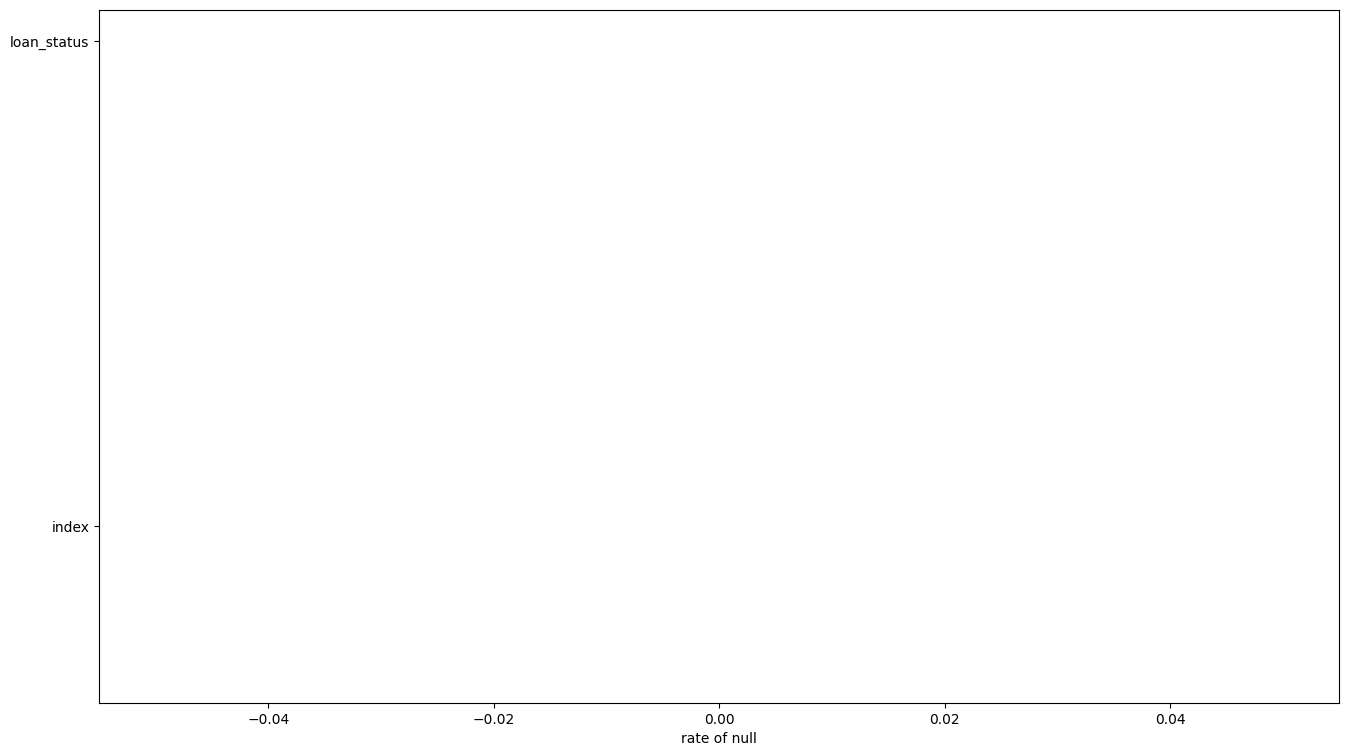

In [7]:
get_table_info(Y,table_name='train target')

In [8]:
def get_class_balance(target_table,column_with_labels,fig_size = (16,9)):
    cData = target_table[column_with_labels]
    target_type = get_types(target_table)[column_with_labels]
    print('target type: {}'.format(target_type))
    fig,ax = plot_int_distribution(cData,fig_size)
    plt.show()


target type: 0    int64
Name: loan_status, dtype: object


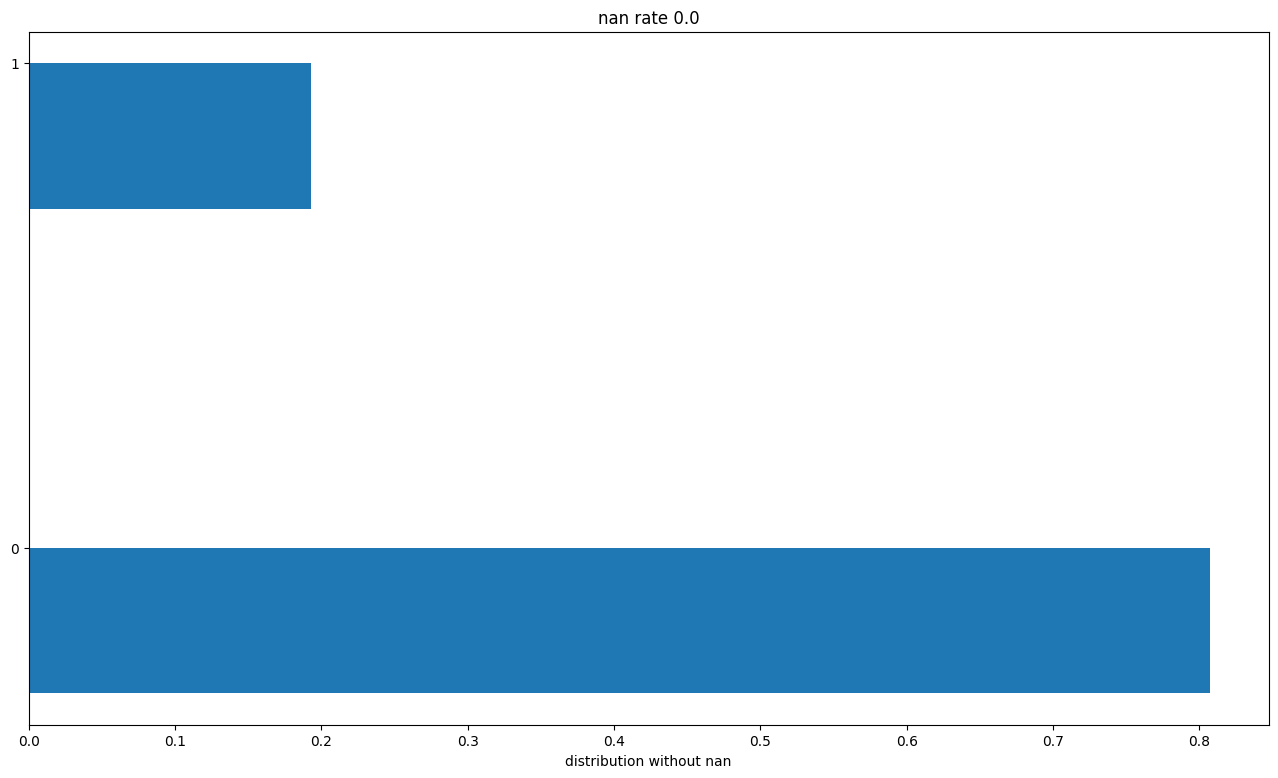

In [9]:
get_class_balance(Y,column_with_labels='loan_status')

In [10]:
X_train_dataset = pd.read_csv(conf.X_train_dataset)
X_test_dataset = pd.read_csv(conf.X_test_dataset)

# feauture correlation

# make pairs or triples of correlating categorical features? mutate numeric features that correlate?

<Axes: >

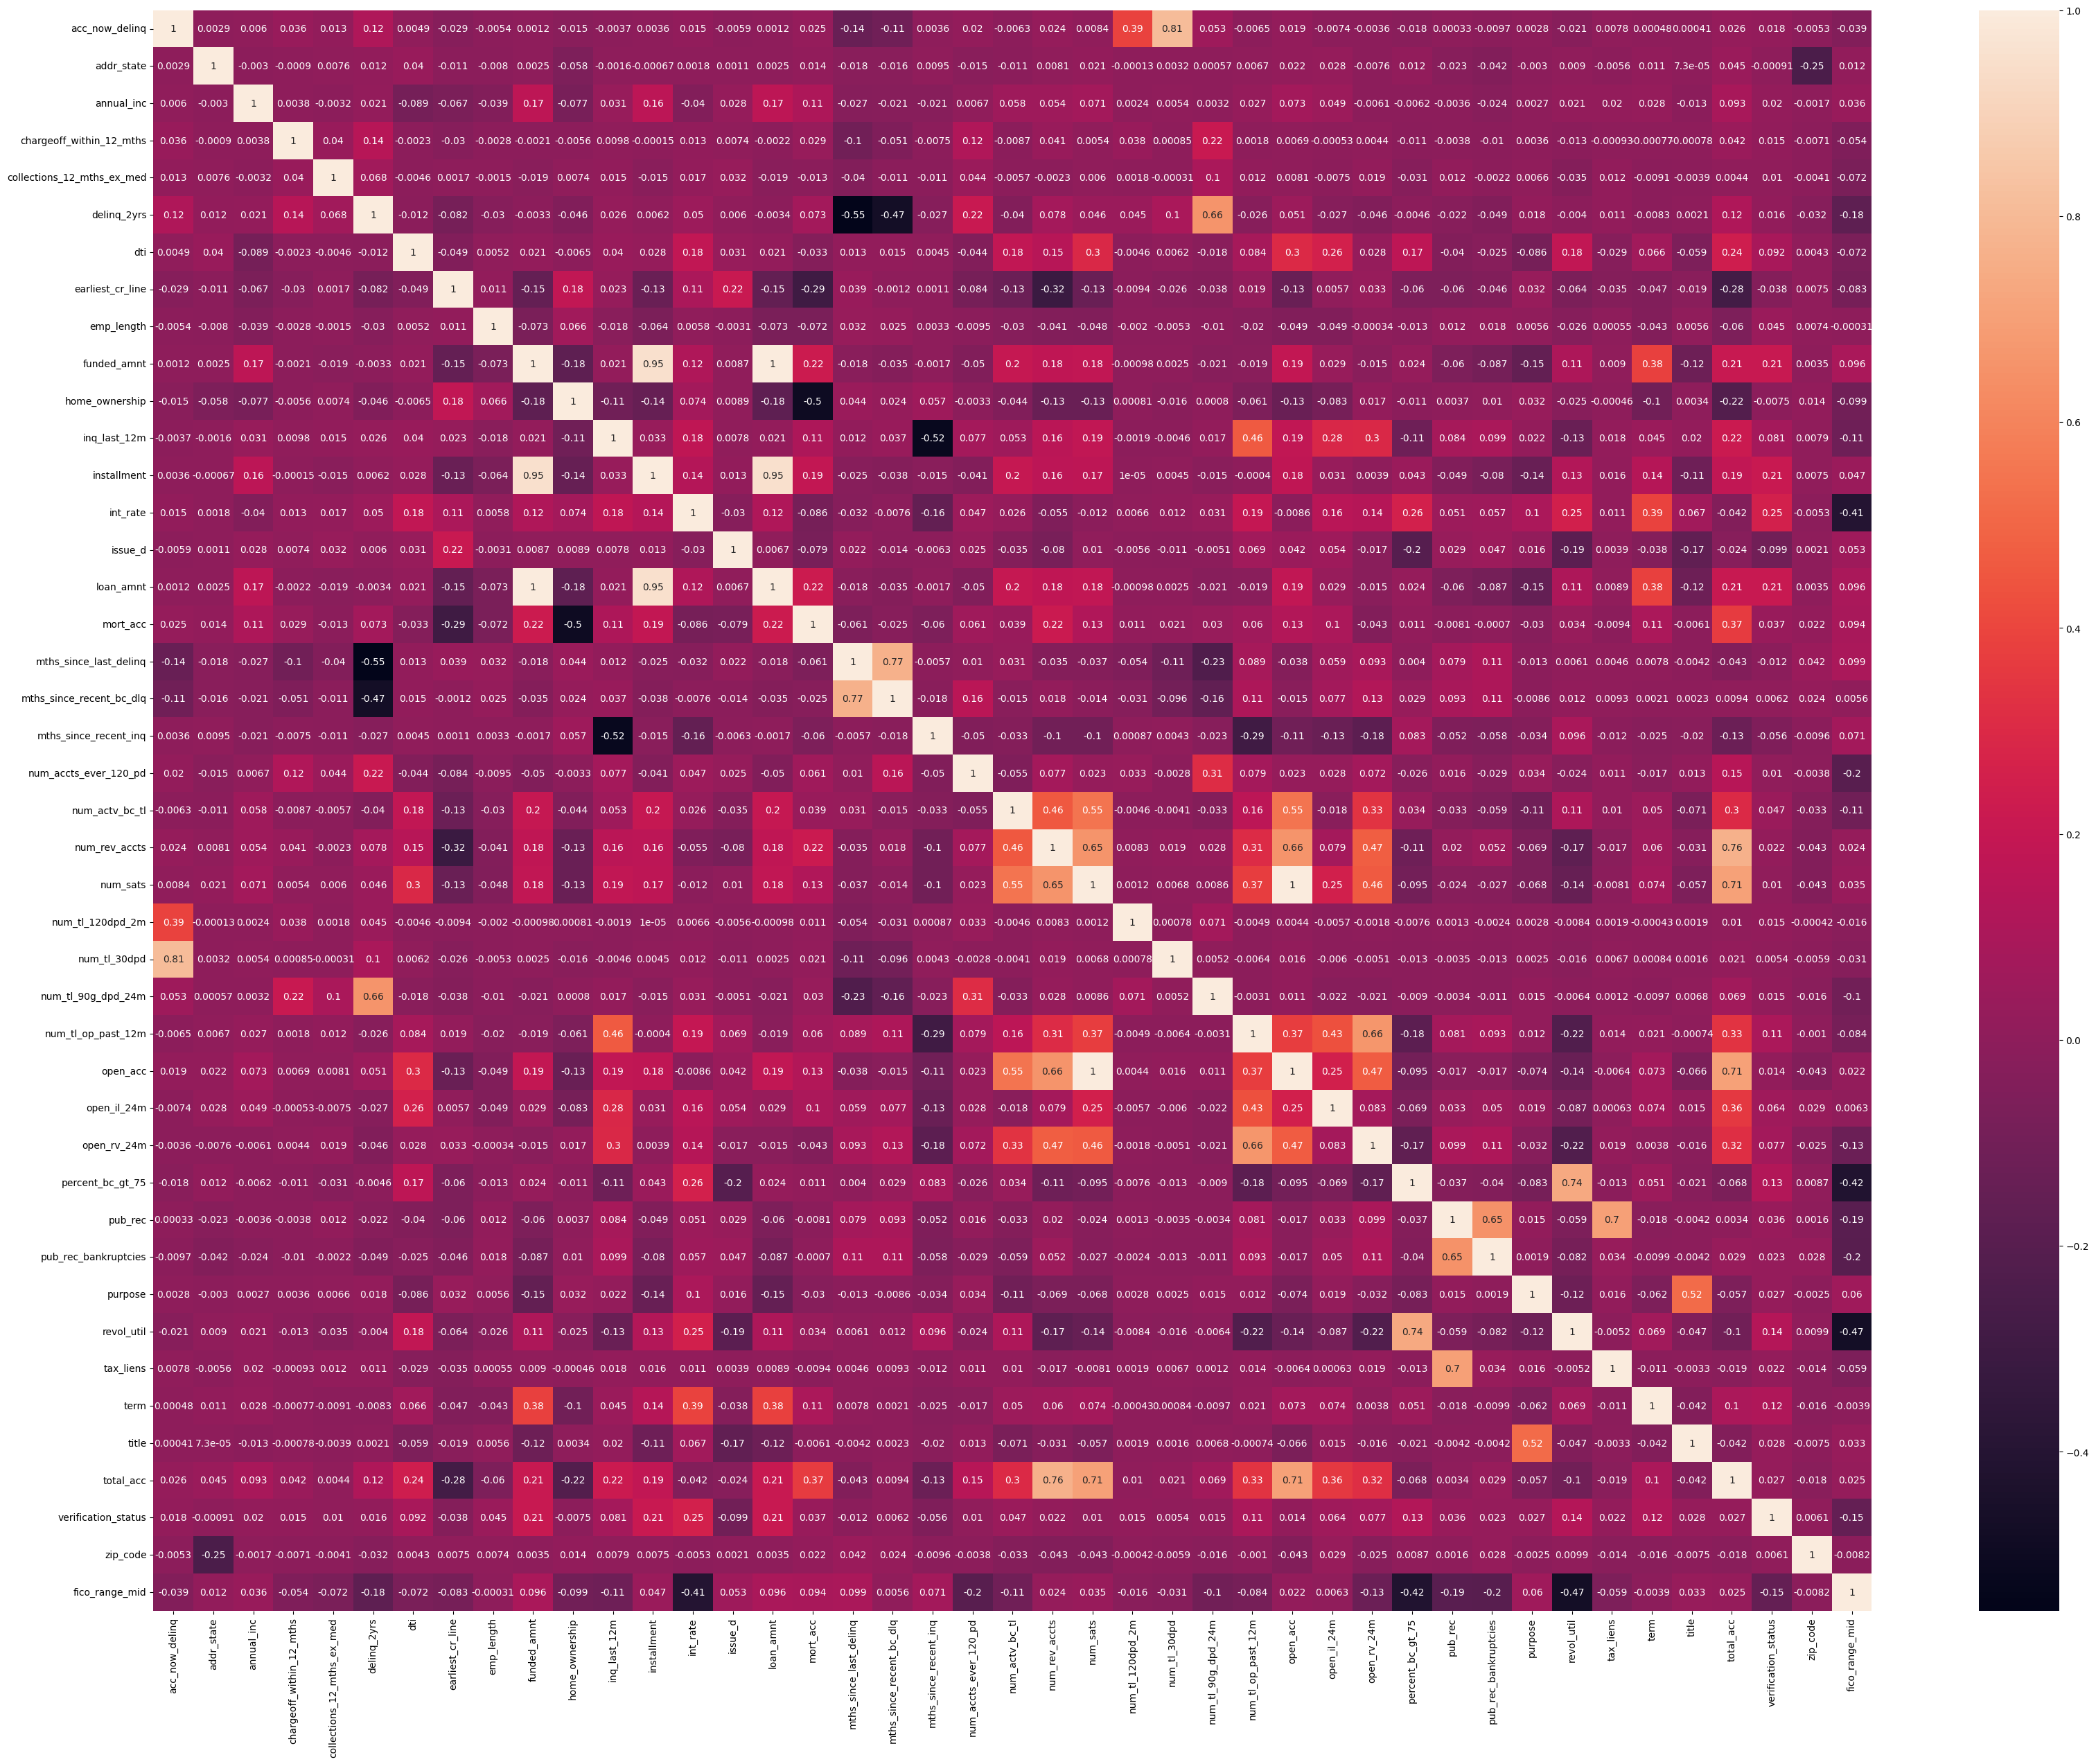

In [11]:
import seaborn as sns
fig2, ax2 = plt.subplots(figsize=(40, 30))
sns.heatmap(X_train_dataset.drop(columns=[
]).corr(), ax=ax2, annot=True)

# get the data that is in the test sample and not in the train and vice versa

acc_now_delinq
stat test without NaN. 
KstestResult(statistic=9.614235225552381e-05, pvalue=1.0, statistic_location=0.0, statistic_sign=1)

mean is same

addr_state
stat test without NaN. 
KstestResult(statistic=0.0014442348501316205, pvalue=0.3803600621879708, statistic_location='ME', statistic_sign=-1)

mean is same

annual_inc
stat test without NaN. 
KstestResult(statistic=0.0006367509161598894, pvalue=0.9970959928811509, statistic_location=80952.0, statistic_sign=-1)

mean is same

chargeoff_within_12_mths
stat test without NaN. 
KstestResult(statistic=8.958396014469017e-05, pvalue=1.0, statistic_location=1.0, statistic_sign=1)

mean is same

collections_12_mths_ex_med
stat test without NaN. 
KstestResult(statistic=7.180096543590864e-05, pvalue=1.0, statistic_location=0.0, statistic_sign=-1)

mean is same

delinq_2yrs
stat test without NaN. 
KstestResult(statistic=0.0006110315216371065, pvalue=0.9984346833823268, statistic_location=1.0, statistic_sign=1)

mean is same

dti
stat tes

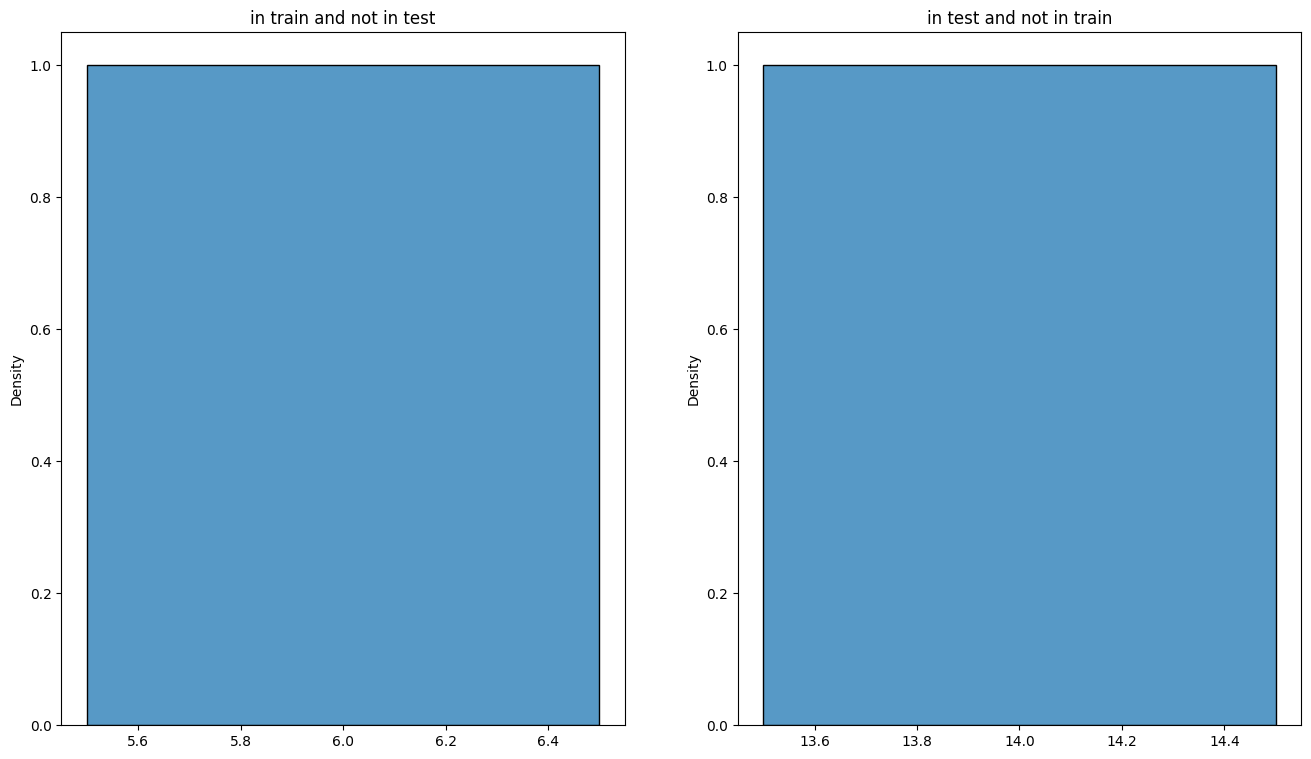

1/30
annual_inc
in train
[2.300000e+03 2.400000e+03 2.951000e+03 ... 9.573072e+06 6.100000e+07
 1.100000e+08]
in test
[2.00000e+03 3.20000e+03 3.60000e+03 ... 9.22500e+06 9.55000e+06
 1.09992e+07]


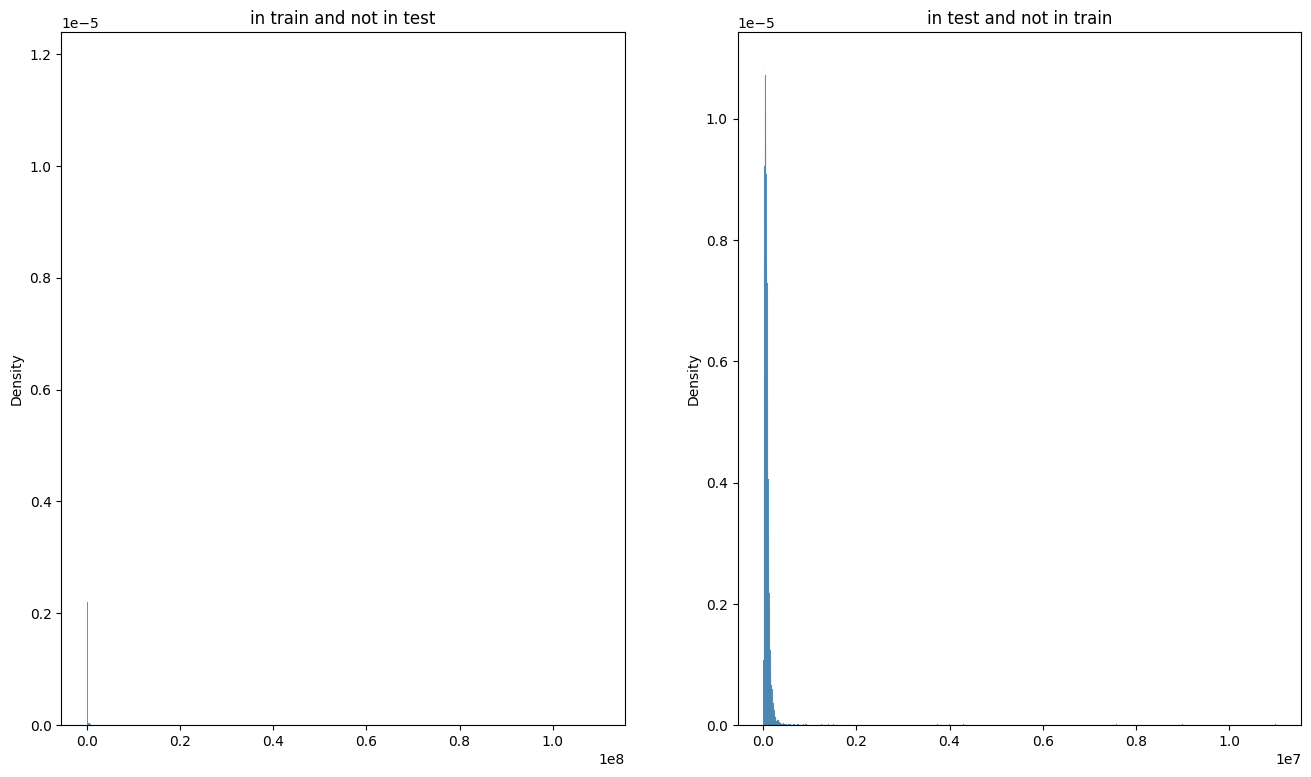

2/30
collections_12_mths_ex_med
in train
[ 9. 12. 20.]
in test
[11. 14. 16.]


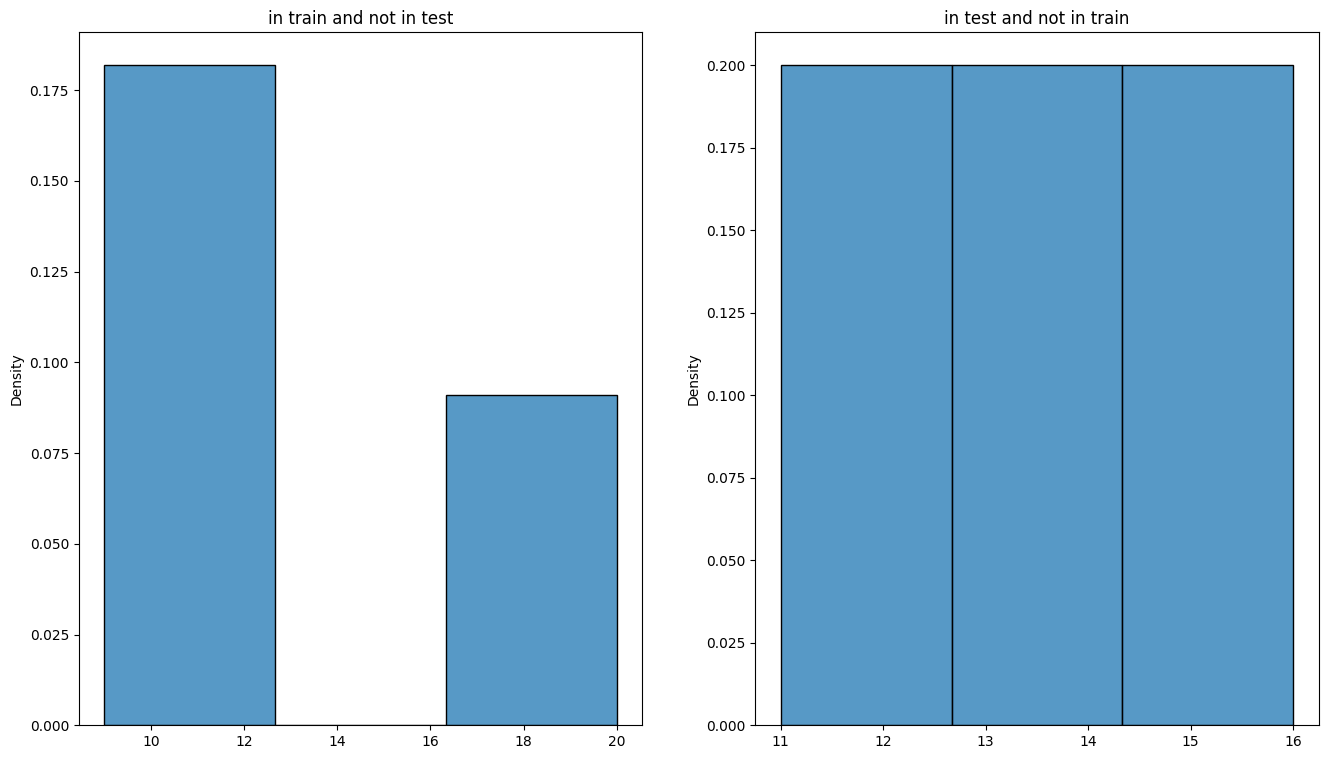

3/30
delinq_2yrs
in train
[24. 27. 28. 30. 39. 42.]
in test
[23. 32. 36.]


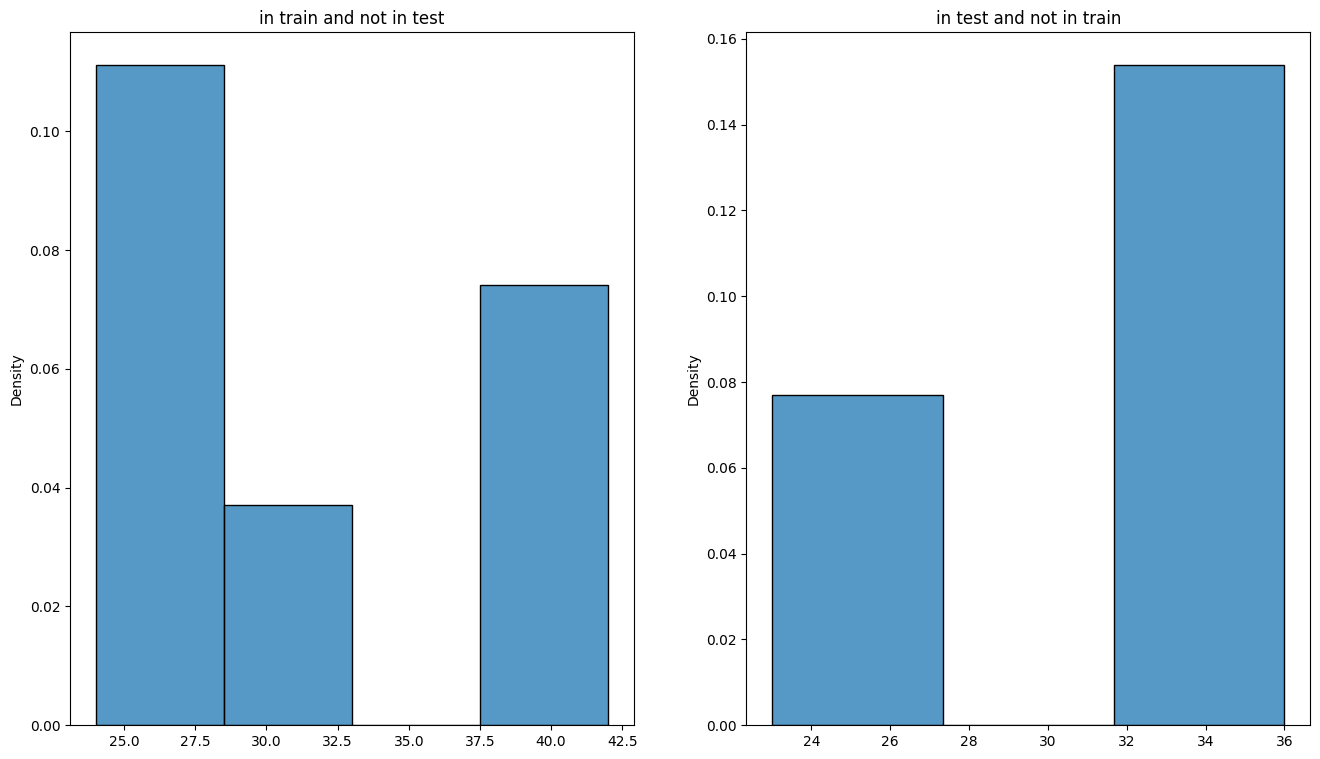

4/30
dti
in train
[-1.   40.   40.05 40.08 40.12 40.17 40.23 40.24 40.3  40.32 40.34 40.35
 40.37 40.38 40.42 40.45 40.47 40.51 40.53 40.56 40.59 40.67 40.68 40.7
 40.77 40.78 40.87 40.93 40.96 40.97 40.98 40.99 41.03 41.05 41.07 41.13
 41.15 41.16 41.18 41.29 41.32 41.42 41.43 41.46 41.48 41.49 41.52 41.55
 41.57 41.58 41.61 41.62 41.64 41.67 41.68 41.7  41.71 41.73 41.76 41.8
 41.81 41.82 41.84 41.86 41.94 41.97 41.99 42.01 42.03 42.09 42.11 42.14
 42.19 42.32 42.36 42.37 42.38 42.41 42.45 42.49 42.5  42.55 42.64 42.66
 42.67 42.68 42.73 42.75 42.82 42.86 42.88 42.92 42.96 42.99 43.   43.02
 43.04 43.05 43.08 43.1  43.15 43.17 43.18 43.19 43.2  43.22 43.29 43.33
 43.35 43.38 43.4  43.45 43.46 43.49 43.53 43.54 43.56 43.58 43.6  43.62
 43.67 43.68 43.7  43.71 43.77 43.78 43.81 43.85 43.87 43.95 43.97 43.98
 44.01 44.12 44.13 44.15 44.19 44.21 44.23 44.24 44.26 44.32 44.33 44.37
 44.38 44.44 44.49 44.52 44.53 44.57 44.59 44.64 44.67 44.71 44.74 44.87
 44.94 44.95 45.   45.01 45.03 45.0

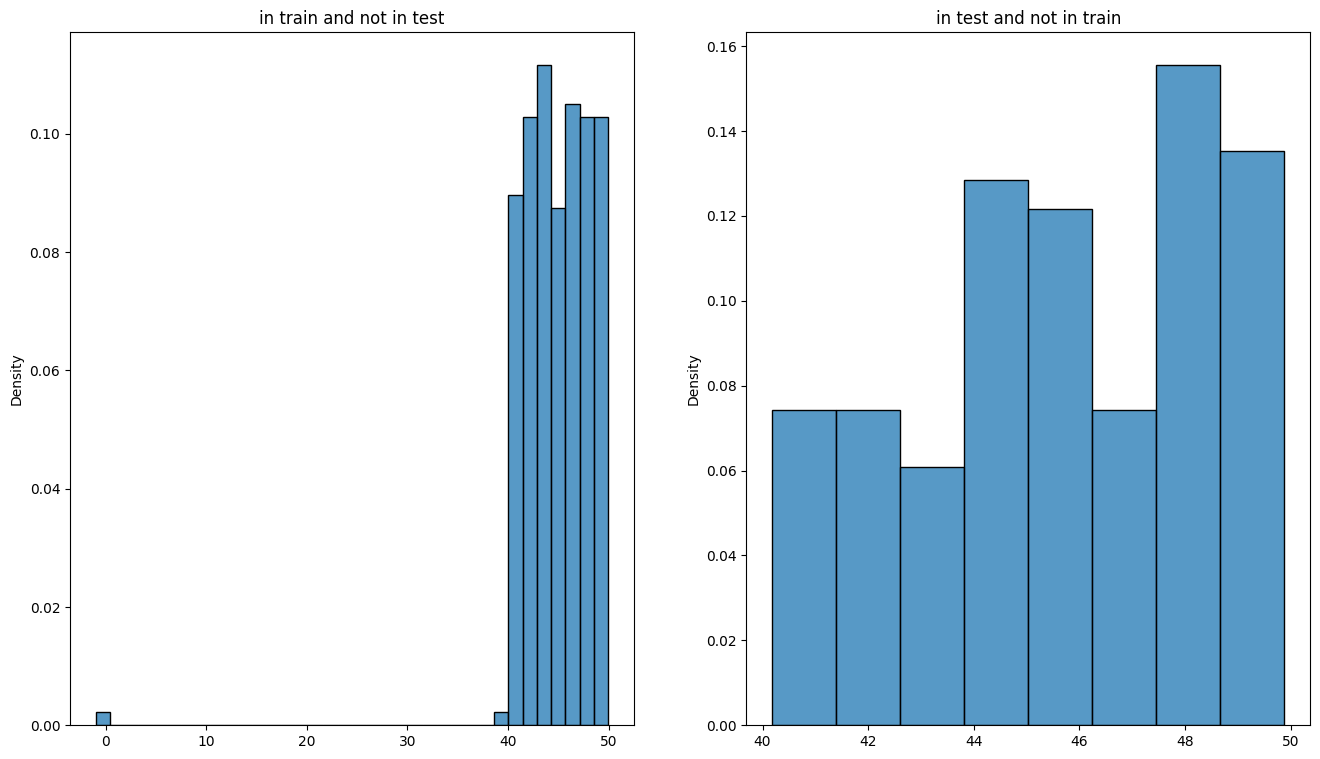

5/30
earliest_cr_line
in train
['Apr-1934' 'Apr-1955' 'Apr-1960' 'Apr-1962' 'Aug-1941' 'Aug-1946'
 'Aug-1957' 'Dec-1946' 'Dec-1950' 'Dec-1951' 'Dec-1956' 'Dec-1958'
 'Dec-1960' 'Feb-1945' 'Feb-1962' 'Feb-2017' 'Jan-1950' 'Jan-1952'
 'Jul-1952' 'Jul-1955' 'Jul-1958' 'Jul-1962' 'Jun-1952' 'Jun-1955'
 'Mar-1933' 'Mar-1954' 'Mar-1955' 'Mar-1957' 'Mar-1958' 'Mar-1959'
 'May-1950' 'May-1953' 'May-1957' 'Nov-1950' 'Nov-1952' 'Nov-1954'
 'Nov-1956' 'Nov-1957' 'Nov-1960' 'Nov-1963' 'Nov-2016' 'Oct-1950'
 'Oct-1954' 'Oct-1957' 'Sep-1953' 'Sep-1959' 'Sep-1960']
in test
['Apr-1957' 'Apr-1958' 'Aug-1951' 'Aug-1955' 'Feb-1957' 'Feb-1958'
 'Jan-1946' 'Jan-2017' 'Jun-1949' 'Jun-1956' 'Nov-1953' 'Nov-1955'
 'Nov-1958' 'Sep-1956' 'Sep-1957']


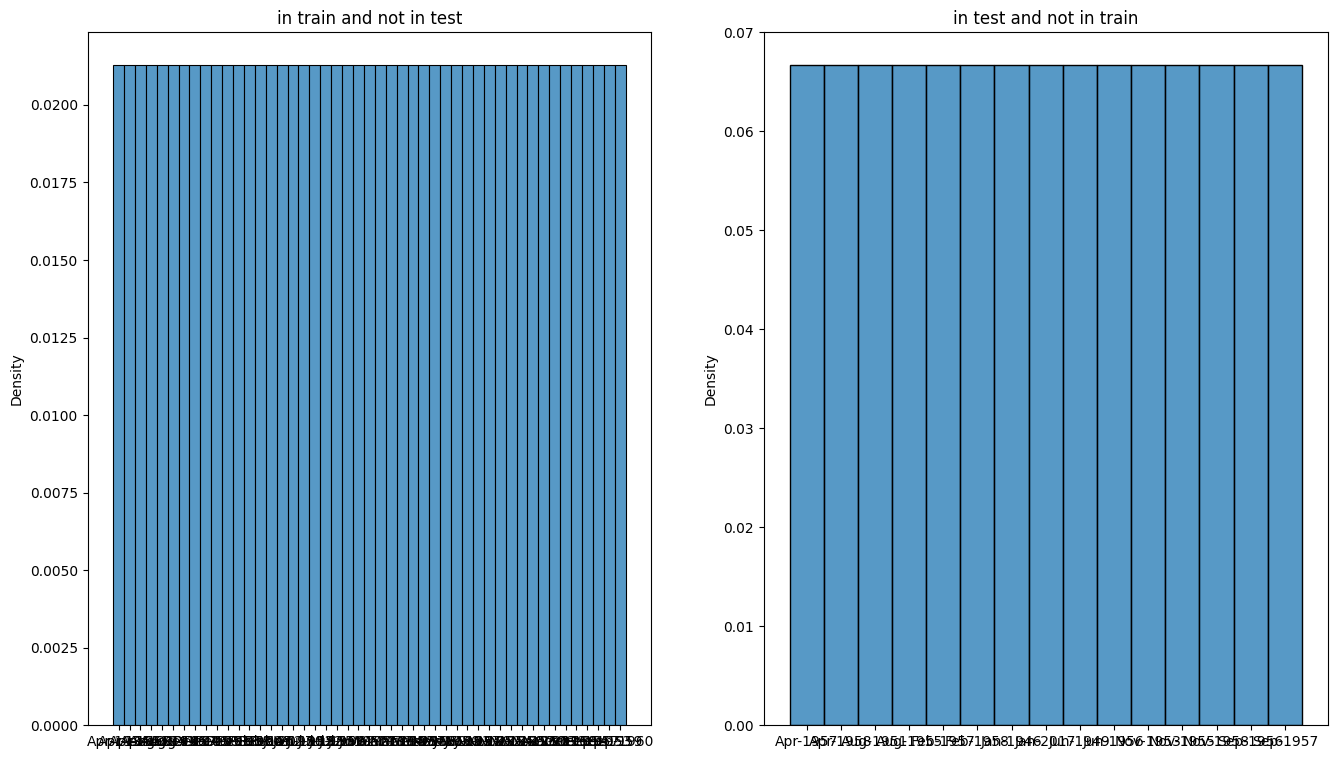

6/30
funded_amnt
in train
[  725.   750.   900.   950. 35275. 35375. 35550. 35575. 35625. 35925.
 36025. 36150. 36250. 36275. 36325. 36350. 36425. 36950. 37125. 37625.
 37975. 38125. 38350. 38375. 38525. 38575. 38625. 38675. 38925. 39225.
 39575. 39750. 39925.]
in test
[  700.   800. 35675. 37650. 37775. 38550.]


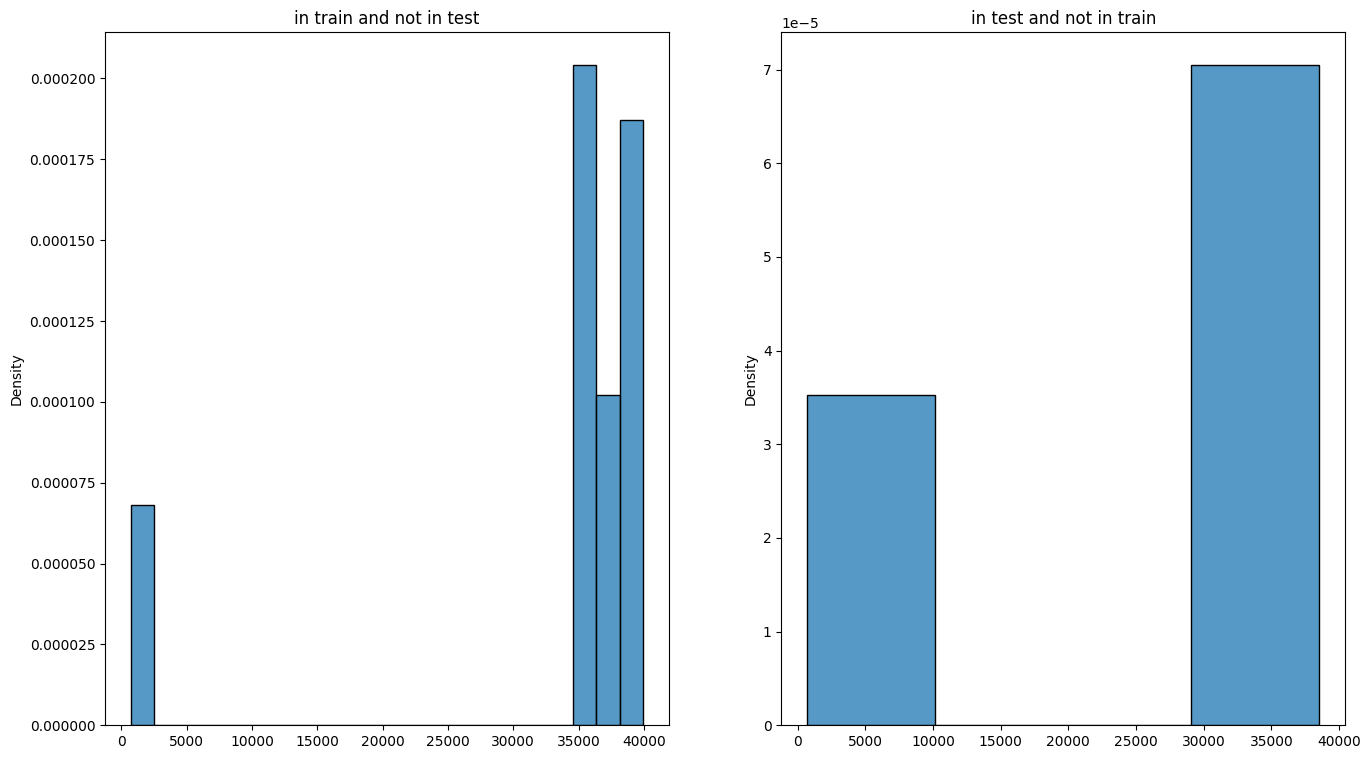

7/30
inq_last_12m
in train
[38. 39. 41. 42. 45. 46. 49.]
in test
[37. 67.]


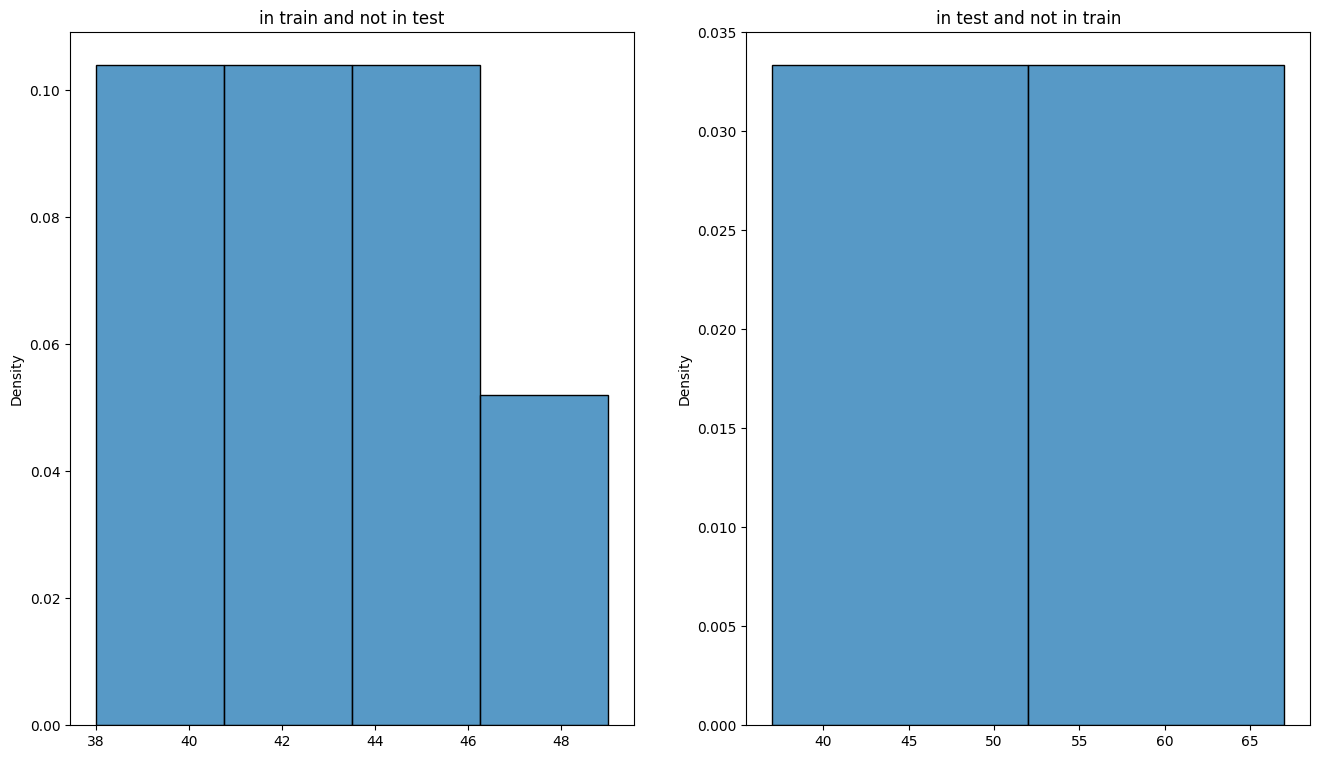

8/30
installment
in train
[   4.93   14.01   14.77 ... 1715.42 1717.63 1719.83]
in test
[   7.61   16.08   16.47 ... 1534.88 1545.86 1568.25]


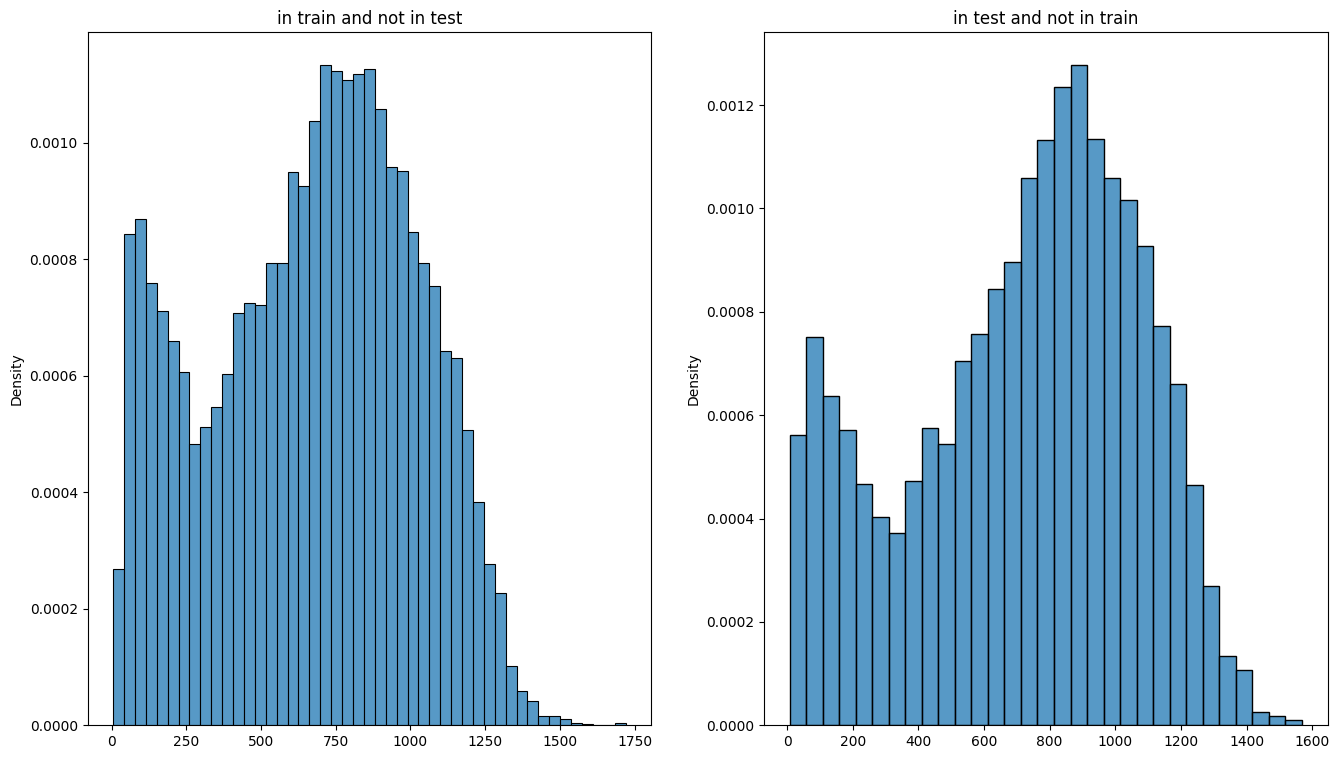

9/30
int_rate
in train
[' 11.16%' ' 14.12%' ' 14.62%' ' 14.67%' ' 14.75%' ' 14.88%' ' 15.25%'
 ' 15.29%' ' 15.83%' ' 17.03%' ' 17.34%' ' 17.44%' ' 17.46%' ' 17.50%'
 ' 17.54%' ' 18.21%' ' 18.72%' ' 19.39%' ' 20.17%' ' 20.69%' ' 20.86%'
 ' 21.64%' ' 21.82%' ' 22.64%' ' 22.94%' ' 23.59%']
in test
[' 13.19%' ' 14.25%' ' 14.28%' ' 14.70%' ' 15.07%' ' 16.15%' ' 16.71%'
 ' 16.90%' ' 16.96%' ' 17.90%' ' 18.36%' ' 20.52%' ' 24.40%' ' 24.59%'
 ' 27.05%']


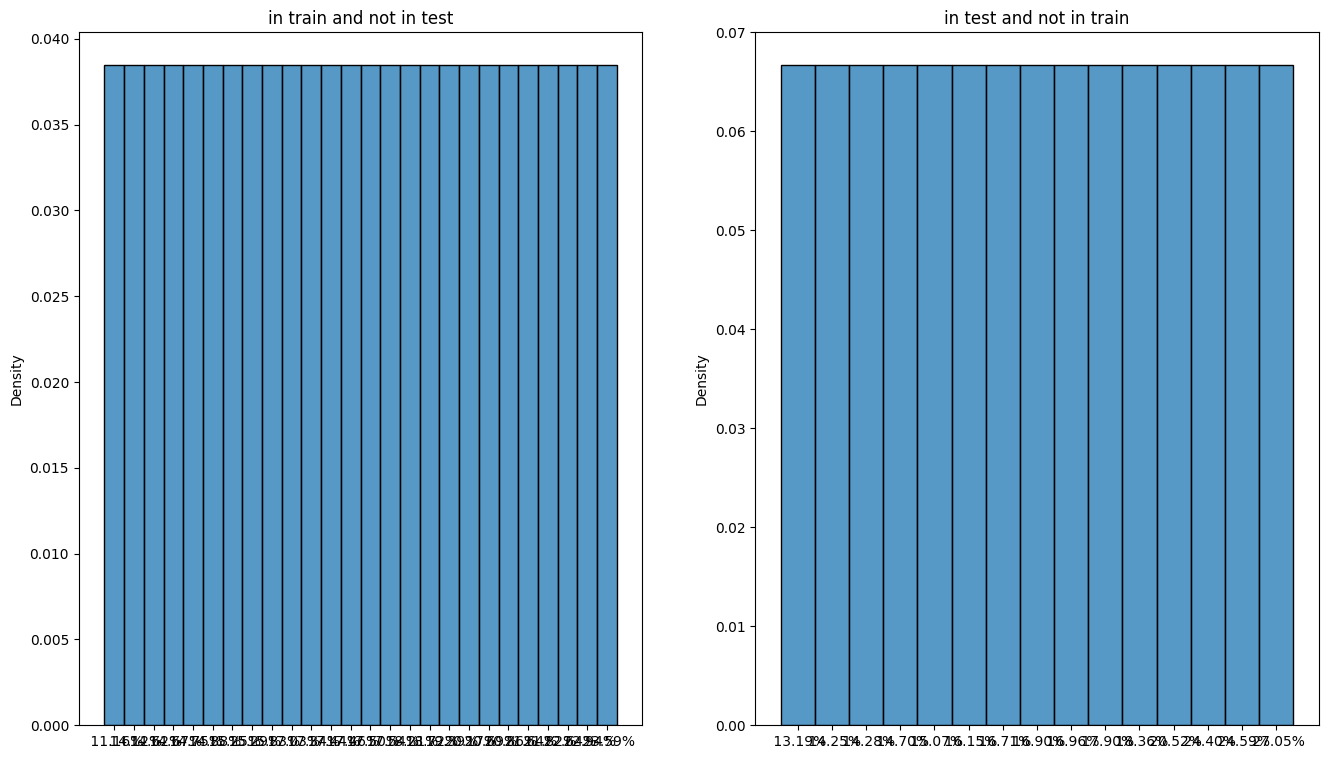

10/30
loan_amnt
in train
[  725.   750.   900.   950. 35275. 35375. 35550. 35575. 35625. 35925.
 36025. 36150. 36250. 36275. 36325. 36350. 36425. 36950. 37125. 37625.
 37975. 38125. 38350. 38375. 38525. 38575. 38625. 38675. 38925. 39225.
 39575. 39750. 39925.]
in test
[  700.   800. 35675. 37650. 37775. 38550.]


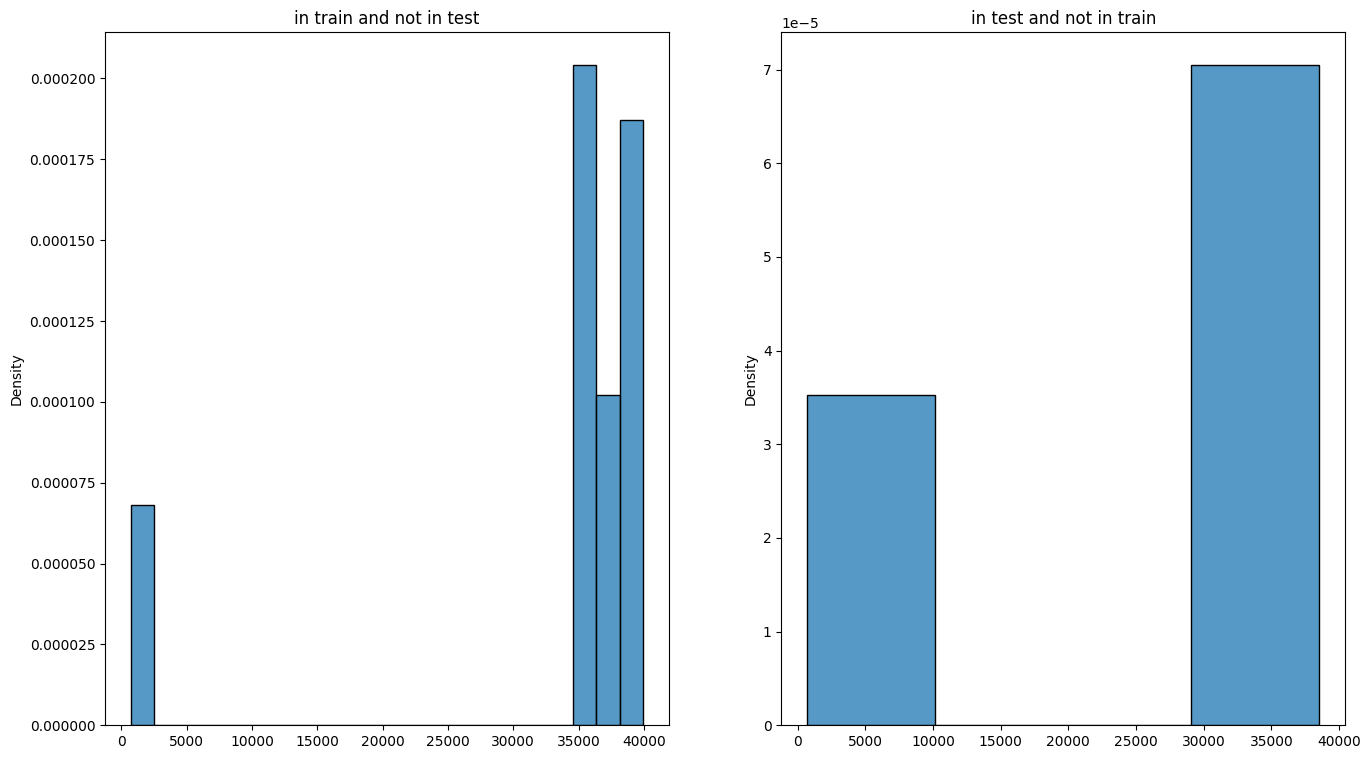

11/30
mort_acc
in train
[30. 34. 35. 36. 45. 47. 61.]
in test
[33. 37. 51.]


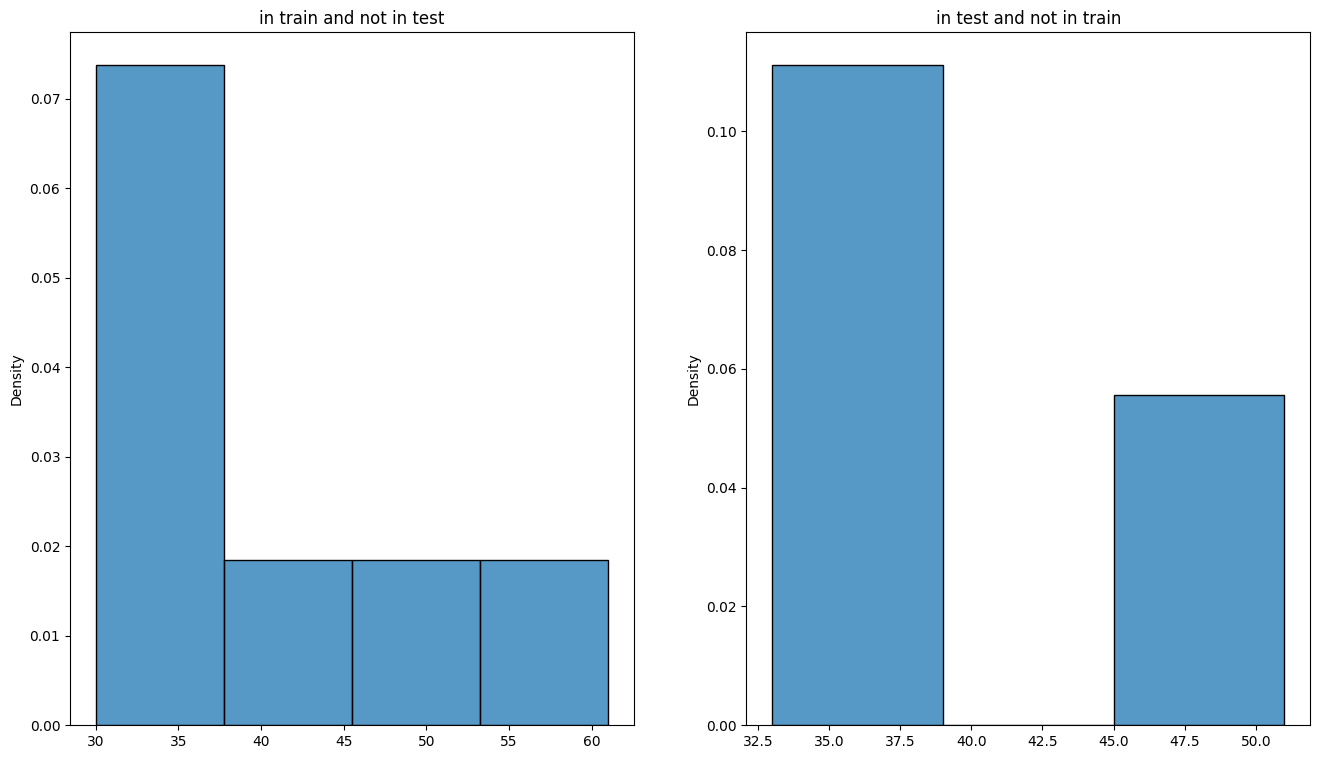

12/30
mths_since_last_delinq
in train
[128. 139. 143. 145. 146. 157. 159. 160. 161. 168. 171. 176. 178. 179.
 180. 188. 192. 195. 226.]
in test
[148. 156. 169. 170. 202.]


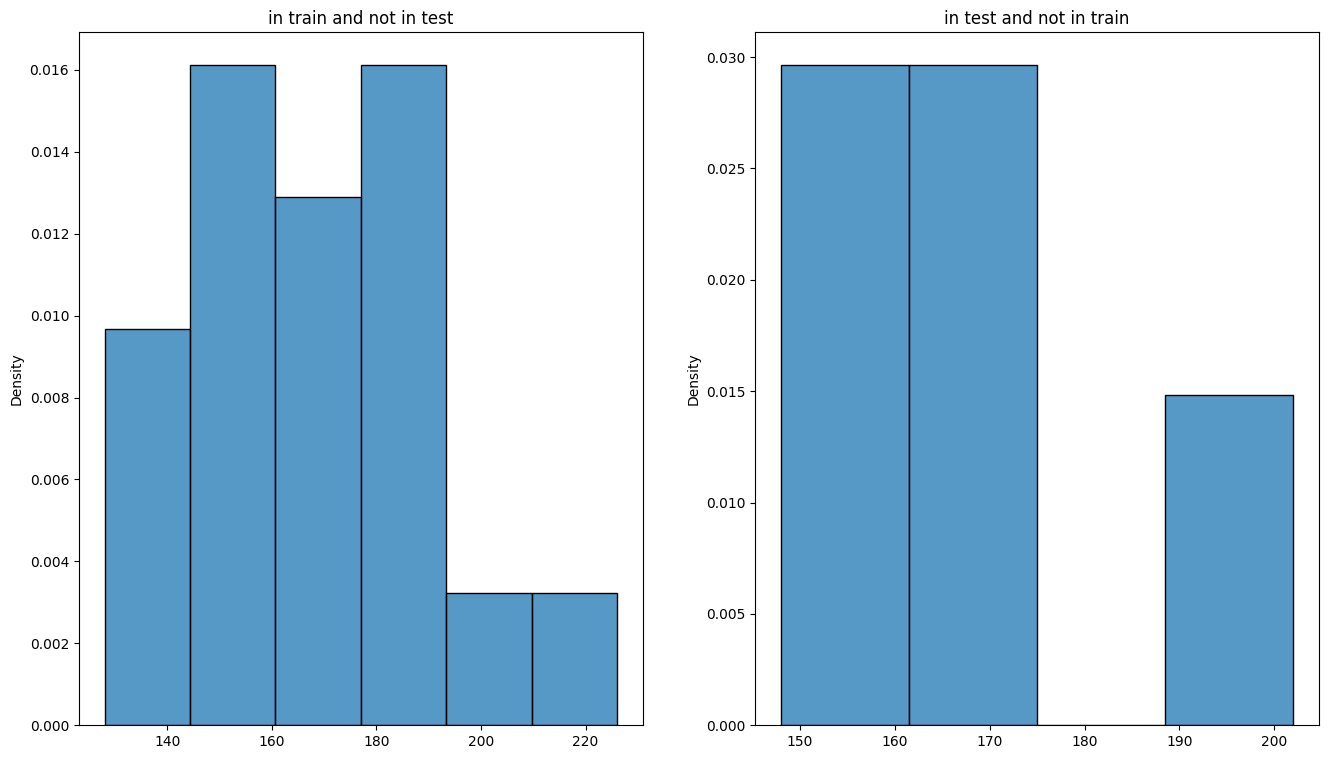

13/30
mths_since_recent_bc_dlq
in train
[126. 140. 143. 146. 150. 155. 156. 159. 160. 161. 162. 165. 171. 176.
 188. 194. 198.]
in test
[170. 172. 174. 189. 191. 195. 202.]


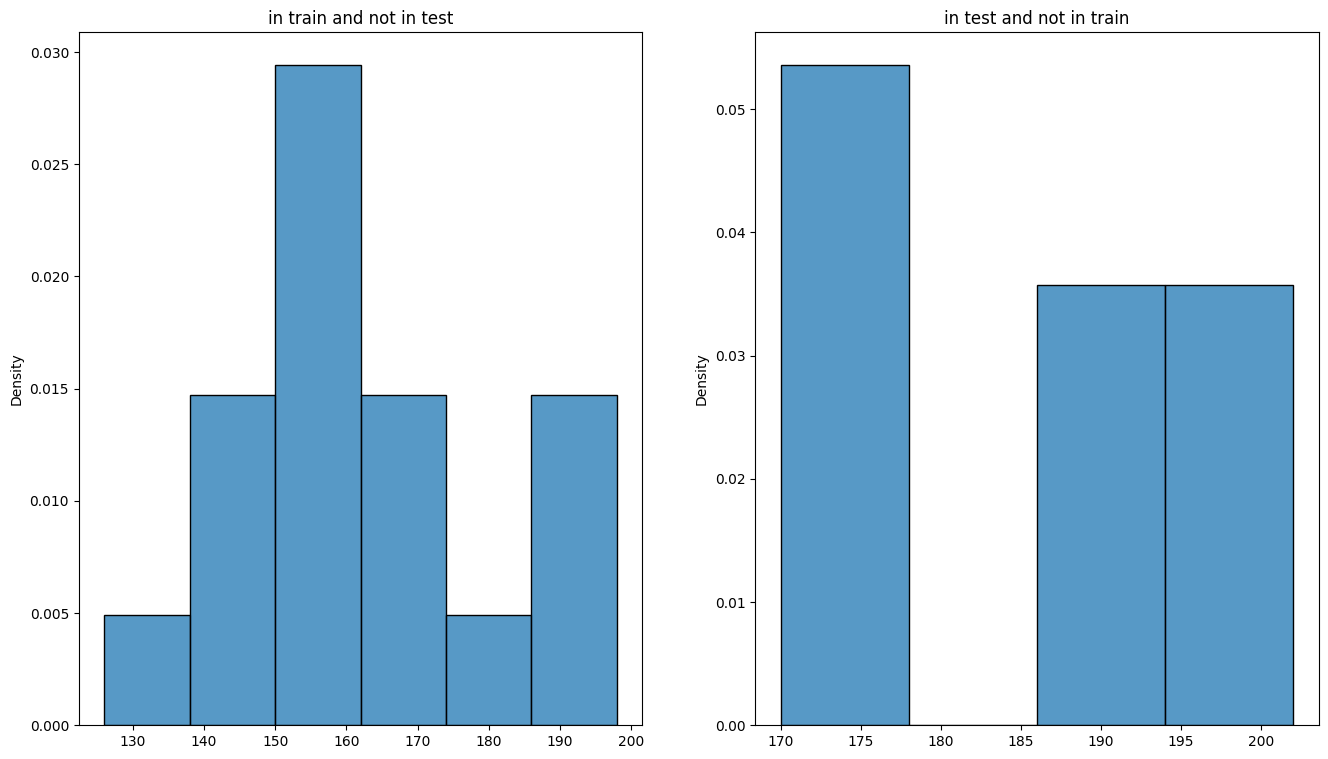

14/30
num_actv_bc_tl
in train
[33. 45. 46.]
in test
[35. 47.]


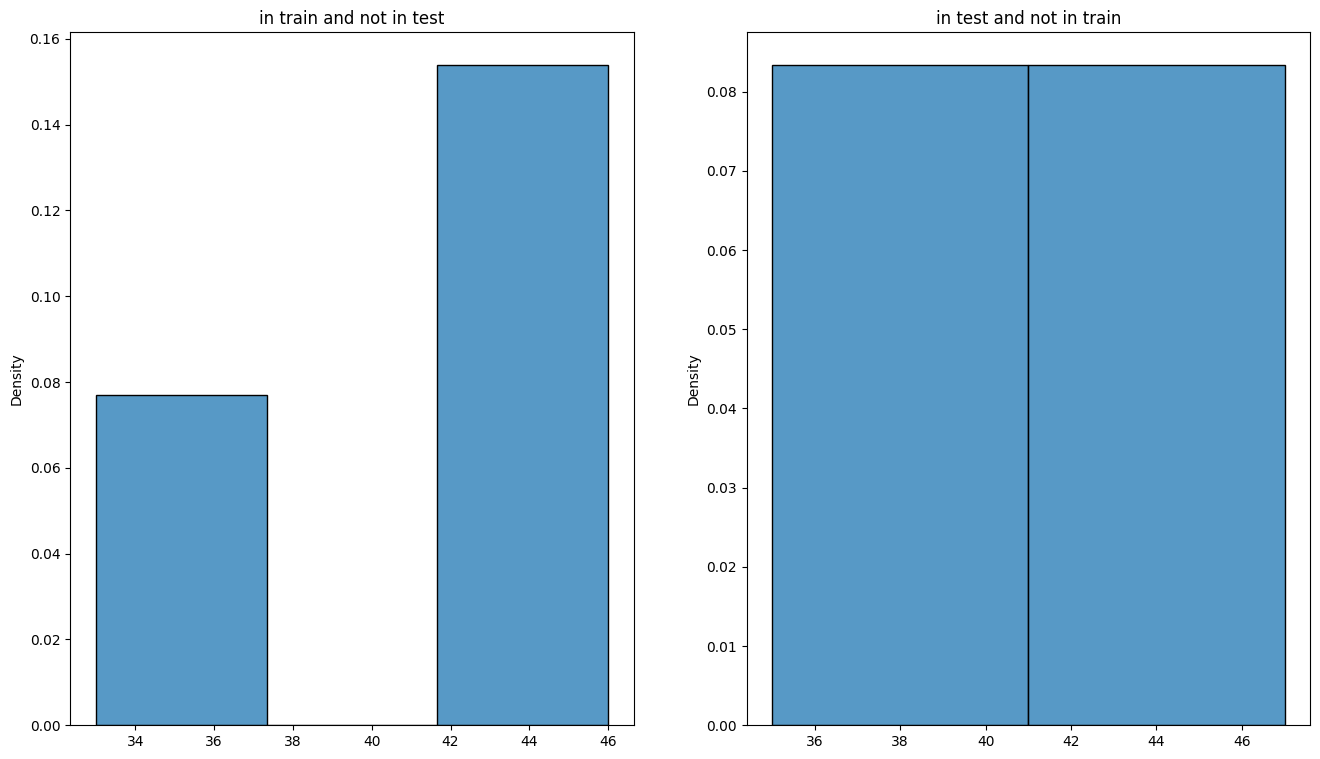

15/30
num_rev_accts
in train
[  0.  86.  87.  91.  95.  99. 102. 103. 113. 116. 117. 127. 128.]
in test
[ 88. 121. 122.]


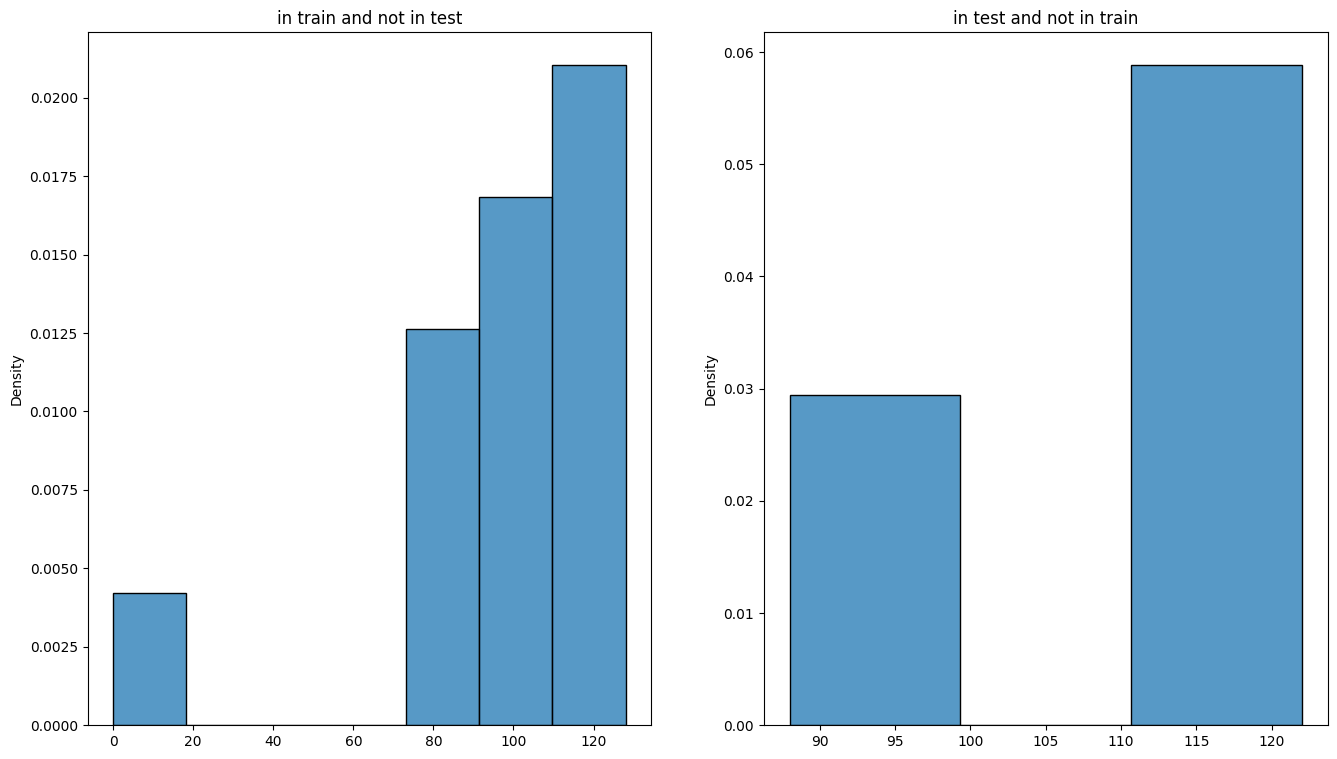

16/30
num_sats
in train
[68. 69. 70. 72. 75. 77. 78. 79. 80. 81. 85. 87. 90.]
in test
[66. 82. 84.]


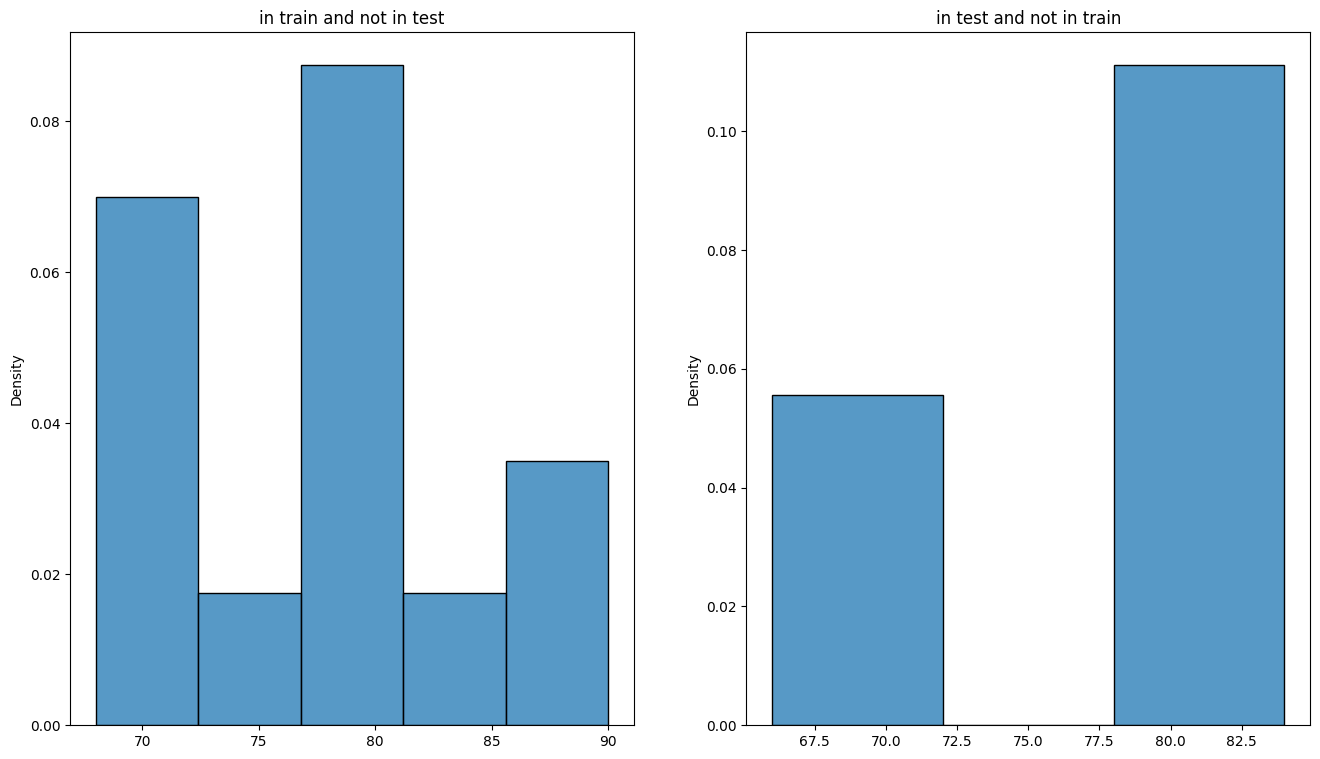

17/30
num_tl_90g_dpd_24m
in train
[21. 24. 26. 29. 39. 42.]
in test
[23. 25. 36.]


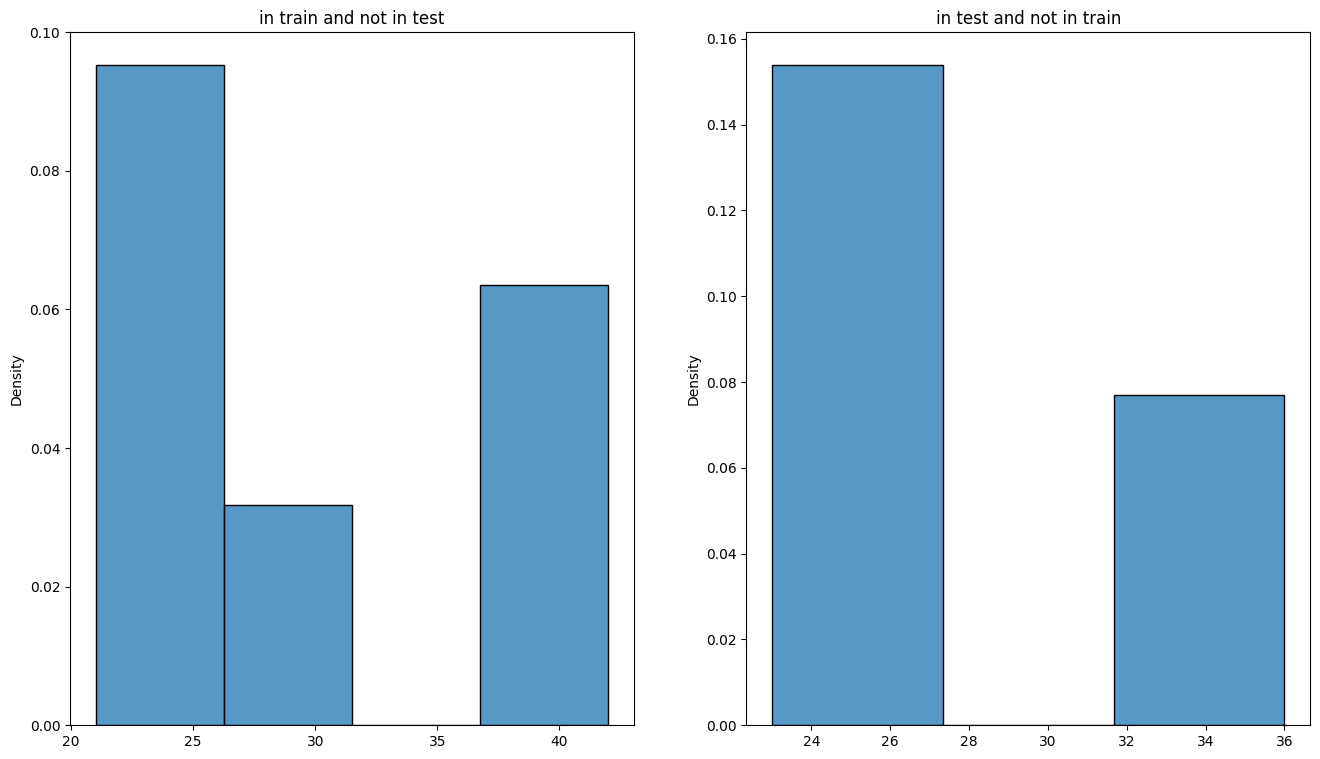

18/30
num_tl_op_past_12m
in train
[28. 29. 31. 32.]
in test
[27.]


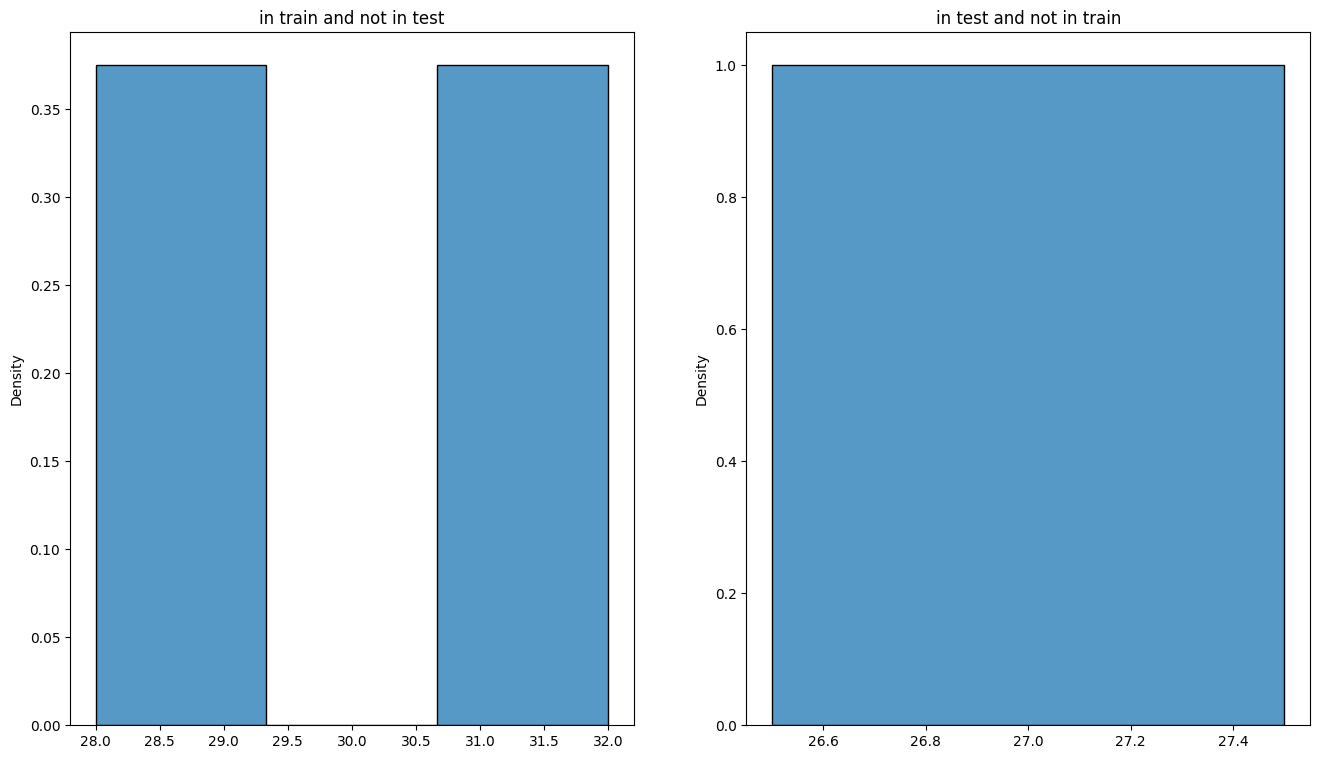

19/30
open_acc
in train
[68. 69. 70. 72. 75. 76. 77. 78. 79. 81. 88. 90.]
in test
[67. 82. 84.]


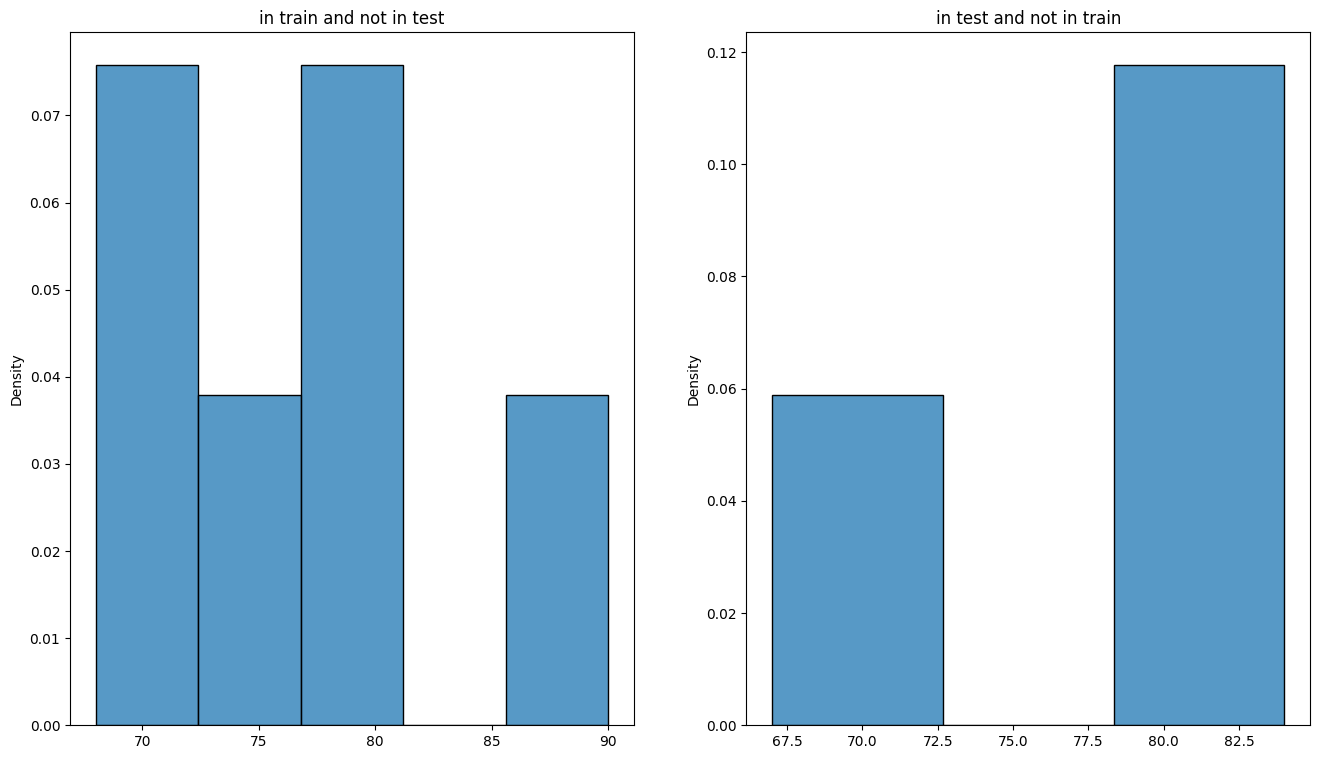

20/30
open_il_24m
in train
[23. 24. 26. 31. 39.]
in test
[28. 30. 51.]


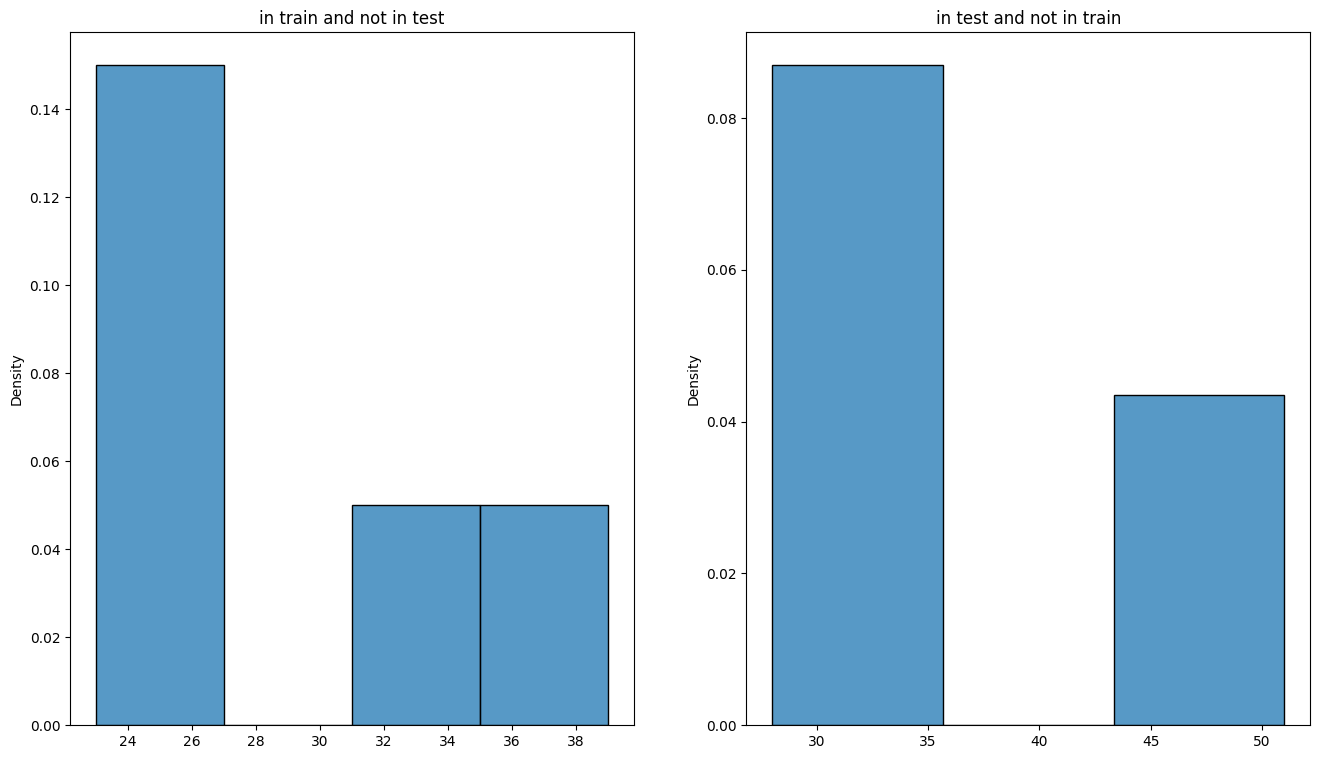

21/30
open_rv_24m
in train
[36. 37. 38. 40. 42. 44. 53. 54.]
in test
[43. 49. 60.]


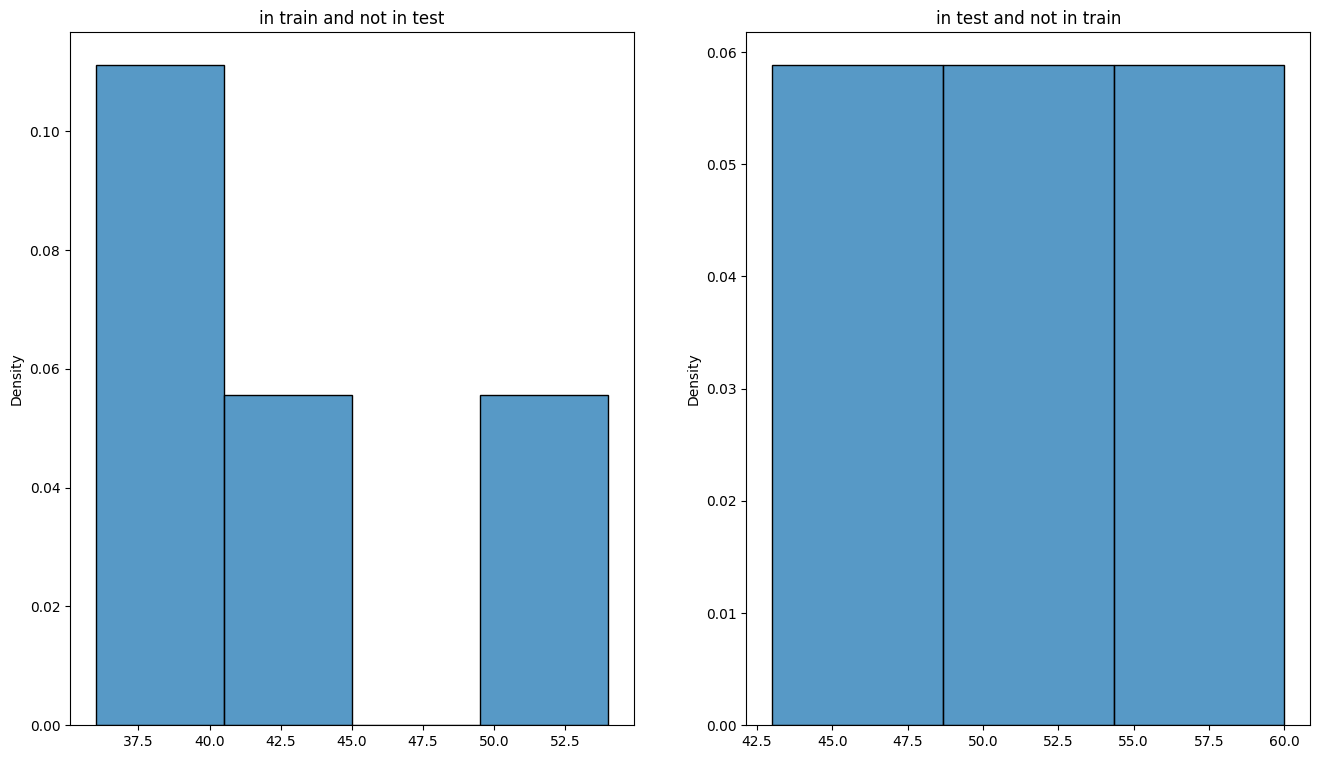

22/30
percent_bc_gt_75
in train
[ 0.14  0.17  0.57  0.63  0.82  0.86  1.9   2.2   2.9   3.    6.9   7.5
 10.7  13.8  14.7  24.1  25.9  26.1  26.5  26.9  28.   28.1  31.   32.1
 36.7  39.3  40.7  41.4  42.4  44.   44.8  48.   64.   65.2  68.   68.2
 69.6  70.4  76.   81.   85.   88.   91.3  95.  ]
in test
[ 2.1  6.5  8.8 17.1 21.9 24.  34.6 36.  37.  60.9 77.3 82.6 84.  95.8]


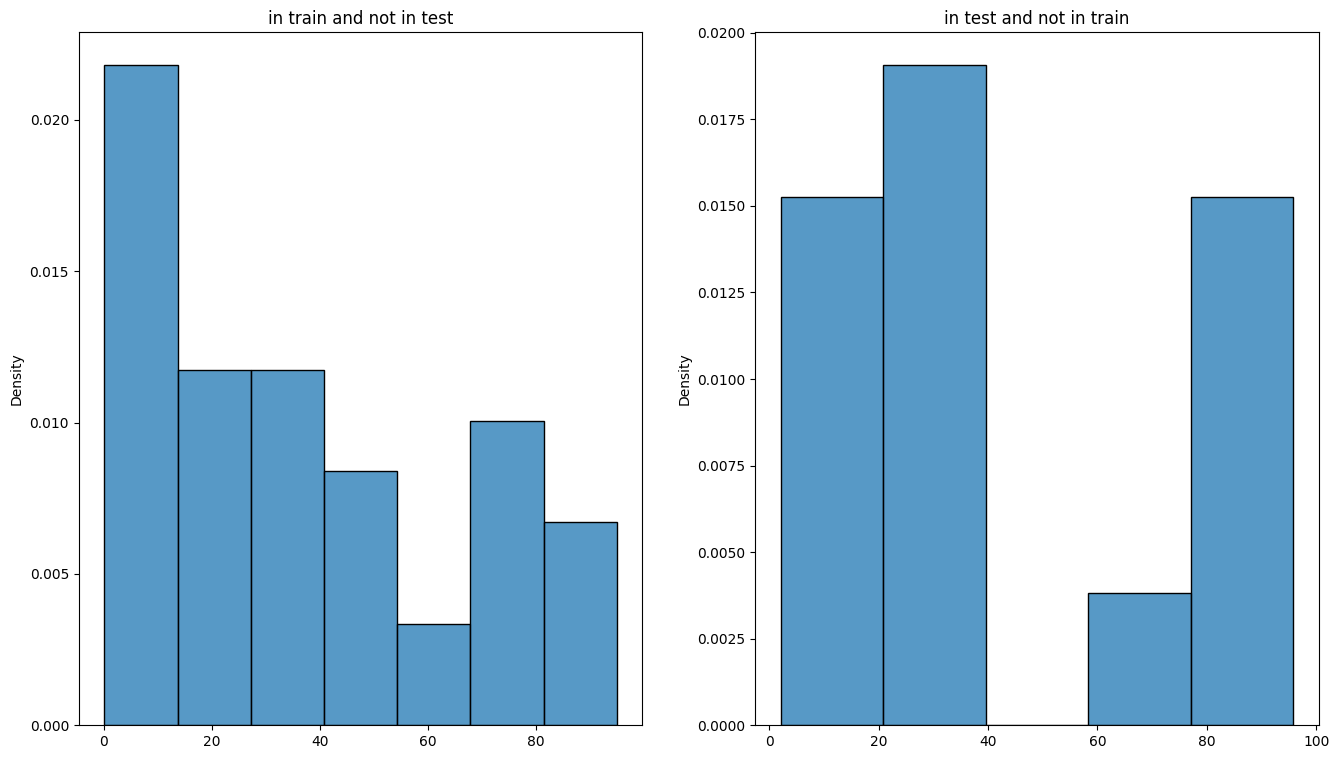

23/30
pub_rec
in train
[22. 25. 28. 31. 32. 37. 40. 44. 47. 86.]
in test
[23. 34. 45. 46. 52. 54. 63.]


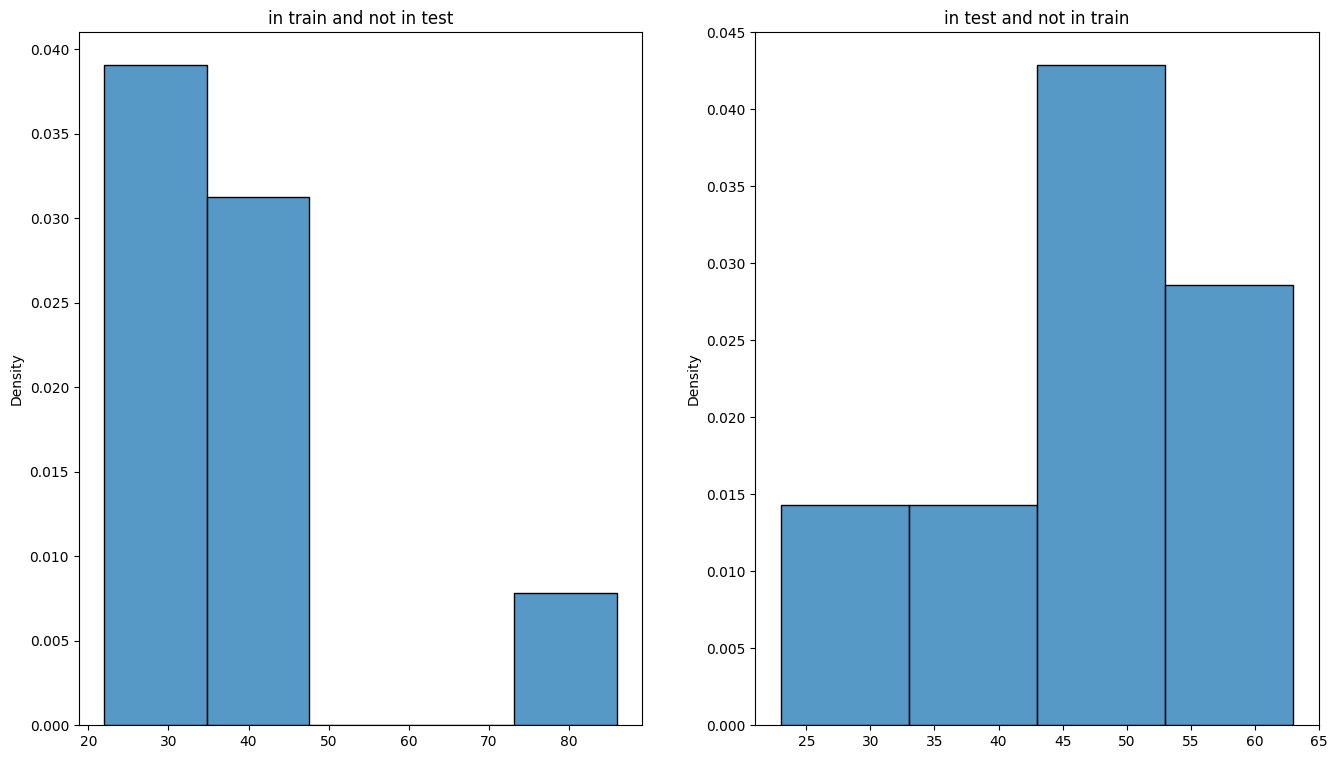

24/30
pub_rec_bankruptcies
in train
[12.]
in test
[11.]


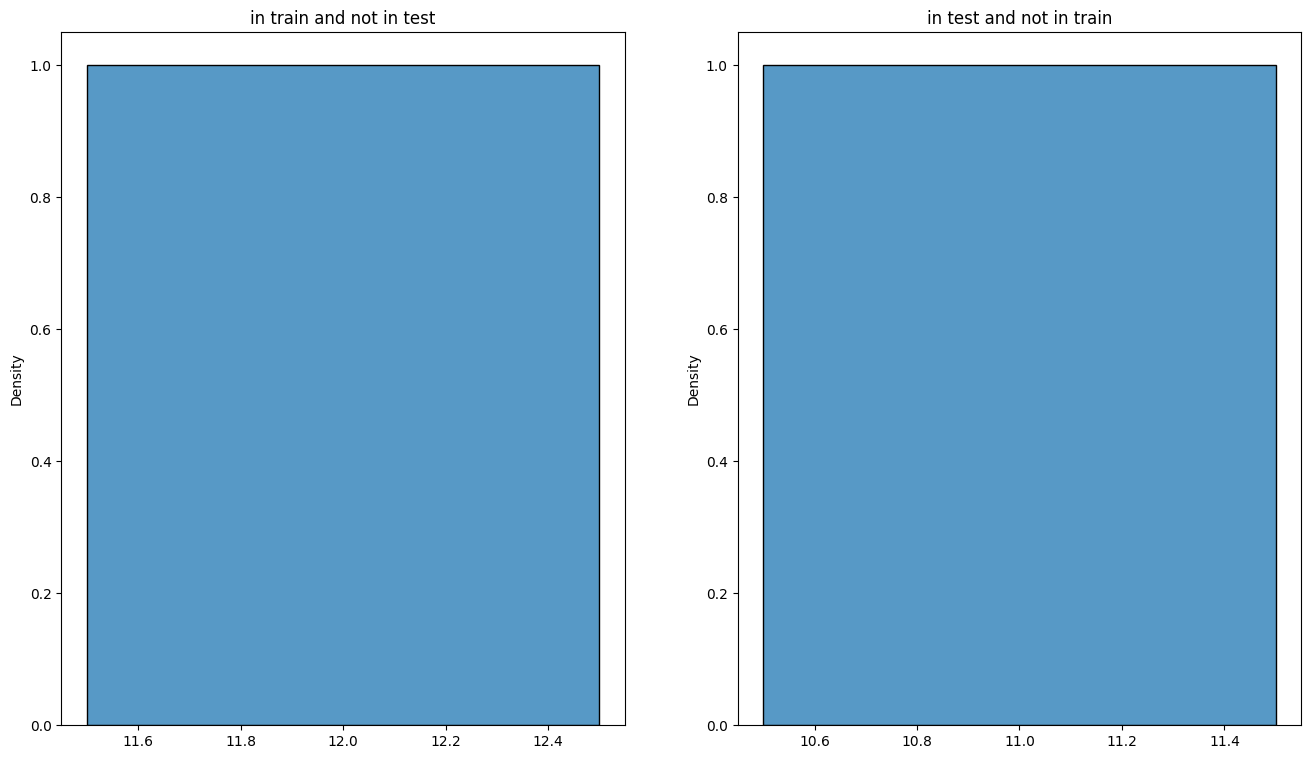

25/30
revol_util
in train
['0.01%' '0.04%' '0.12%' '0.46%' '0.49%' '0.54%' '0.75%' '0.83%' '0.86%'
 '10.17%' '10.61%' '108.6%' '11.62%' '11.63%' '110.1%' '110.8%' '110.9%'
 '111.1%' '111.5%' '112.3%' '112.4%' '112.8%' '113.3%' '113.5%' '113.6%'
 '113.8%' '114.2%' '114.8%' '115.1%' '115.4%' '115.5%' '115.8%' '116%'
 '116.4%' '117%' '117.4%' '117.6%' '118%' '118.1%' '118.3%' '118.6%'
 '118.8%' '119.3%' '119.8%' '119.9%' '12.42%' '120%' '120.1%' '120.3%'
 '120.9%' '121%' '121.1%' '121.3%' '121.4%' '121.5%' '122.1%' '122.2%'
 '122.7%' '123%' '123.1%' '123.2%' '123.5%' '124.5%' '124.7%' '125.1%'
 '125.7%' '125.8%' '126.2%' '126.6%' '127%' '127.5%' '127.6%' '128.7%'
 '128.9%' '129%' '129.4%' '129.5%' '130.4%' '130.5%' '131%' '131.3%'
 '131.4%' '132.7%' '132.9%' '133.1%' '134.1%' '134.5%' '136%' '136.1%'
 '137.2%' '137.8%' '138.9%' '145%' '145.6%' '146.1%' '152.5%' '152.6%'
 '152.7%' '153%' '154.3%' '154.9%' '156.3%' '158.7%' '16.02%' '161.5%'
 '165.8%' '166.9%' '17.67%' '17.71%' '17.78%' '17

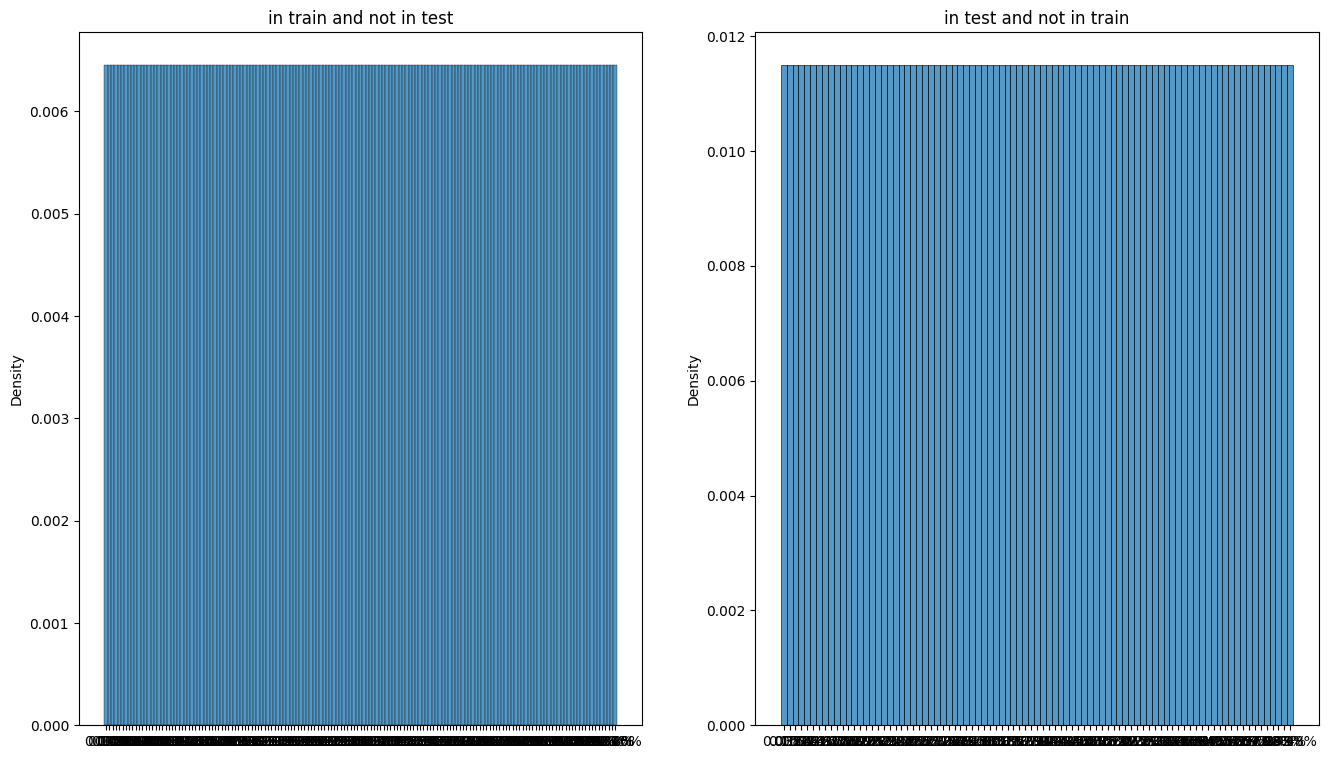

26/30
tax_liens
in train
[20. 23. 27. 28. 29. 30. 37. 39. 44. 48. 85.]
in test
[34. 45. 52. 53. 63.]


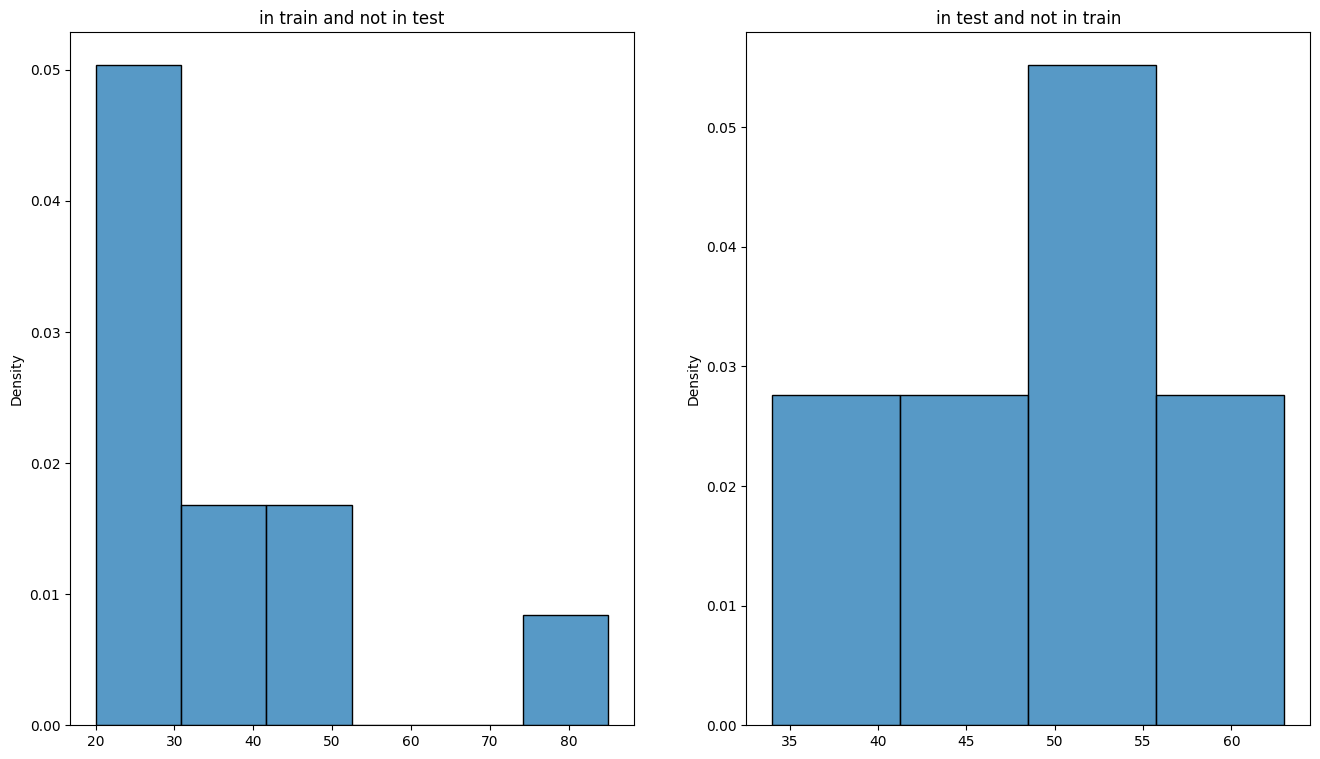

27/30
title
in train
['      debt consolidation' '   HITEK  EQUIPMENT ' '  A lending hand' ...
 'zeusamoose' 'zipcar' '~Summer Fun~']
in test
['\thouse' '  Personal loan ' '  debt consolidation cards and medical' ...
 'zxcvb' '~Life Reorganization~'
 'î\x81\x97î\x81\x97MY FIRST CAR î\x81\x97î\x81\x97']


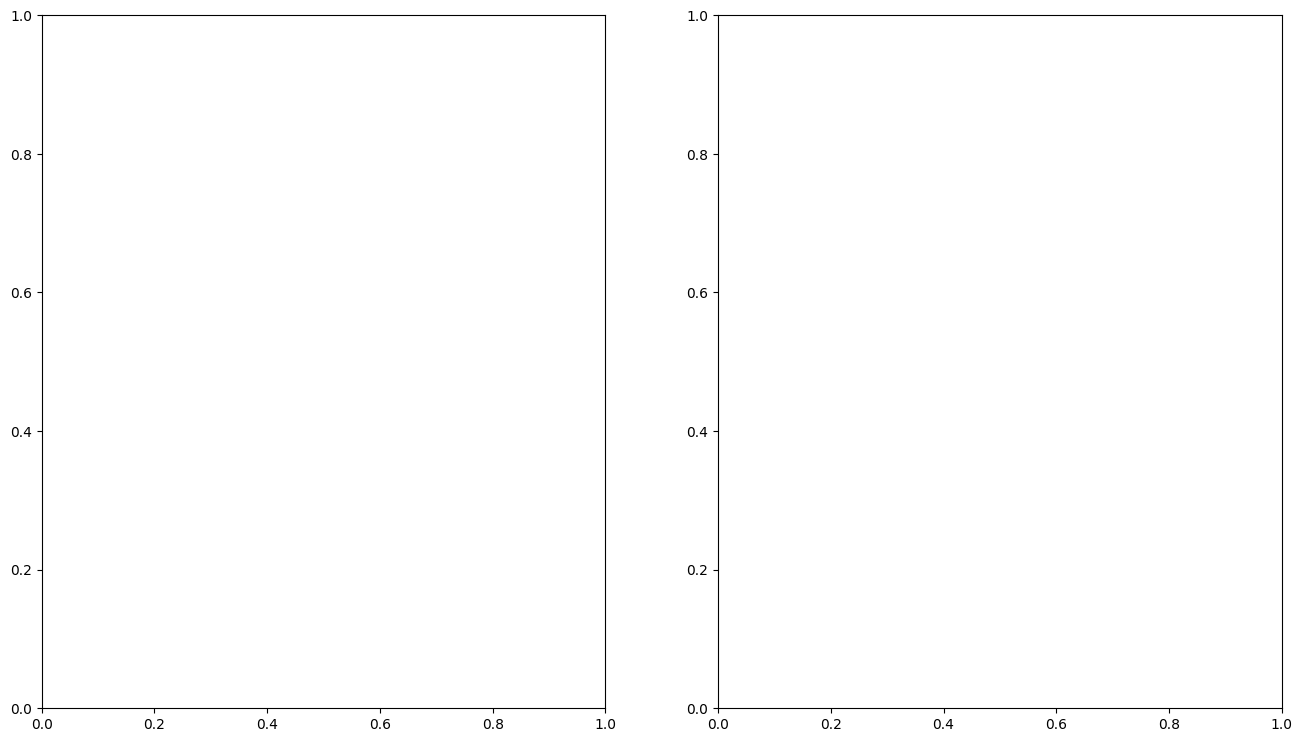

28/30
total_acc
in train
[112. 117. 129. 133. 135. 138. 141. 142. 146. 148. 151. 156. 157. 162.
 165. 173.]
in test
[127. 134. 140. 145. 150. 169. 176.]


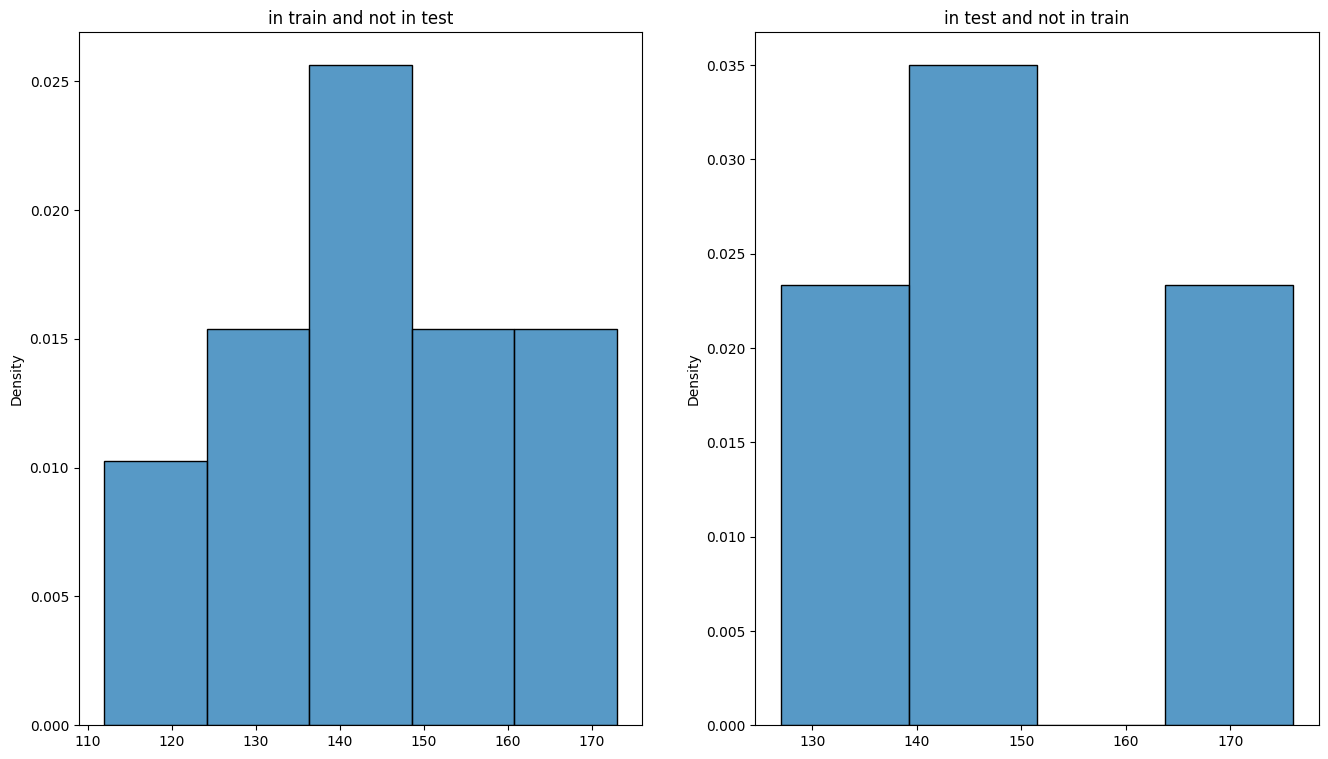

29/30
zip_code
in train
['009xx' '202xx' '269xx' '348xx' '353xx' '375xx' '399xx' '501xx' '503xx'
 '509xx' '511xx' '513xx' '516xx' '520xx' '521xx' '522xx' '524xx' '555xx'
 '568xx' '643xx' '649xx' '682xx' '698xx' '742xx' '771xx' '817xx' '819xx'
 '862xx' '872xx' '964xx' '987xx']
in test
['429xx' '507xx' '525xx' '552xx' '702xx' '849xx' '888xx' '889xx' '892xx'
 '896xx' '929xx' '938xx']


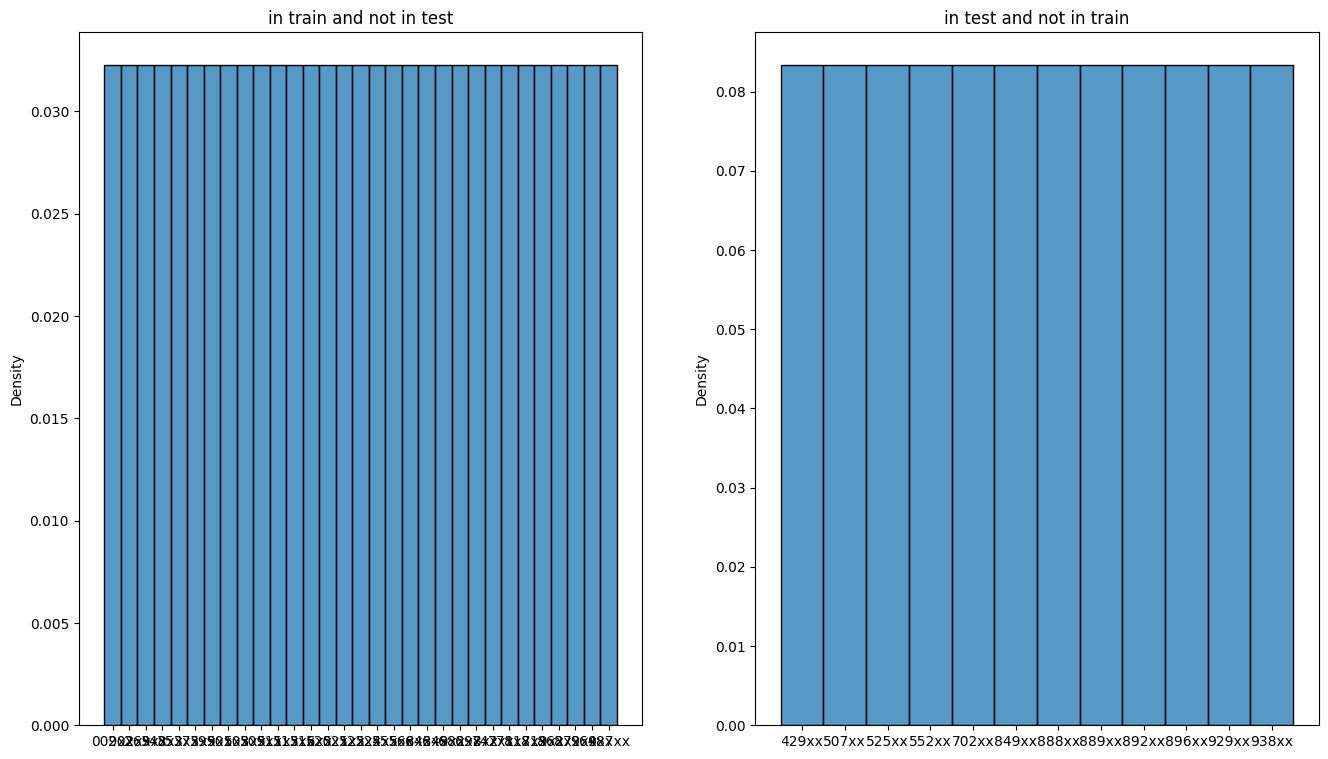

0/4
chargeoff_within_12_mths
in train
[ 7.  8. 10.]


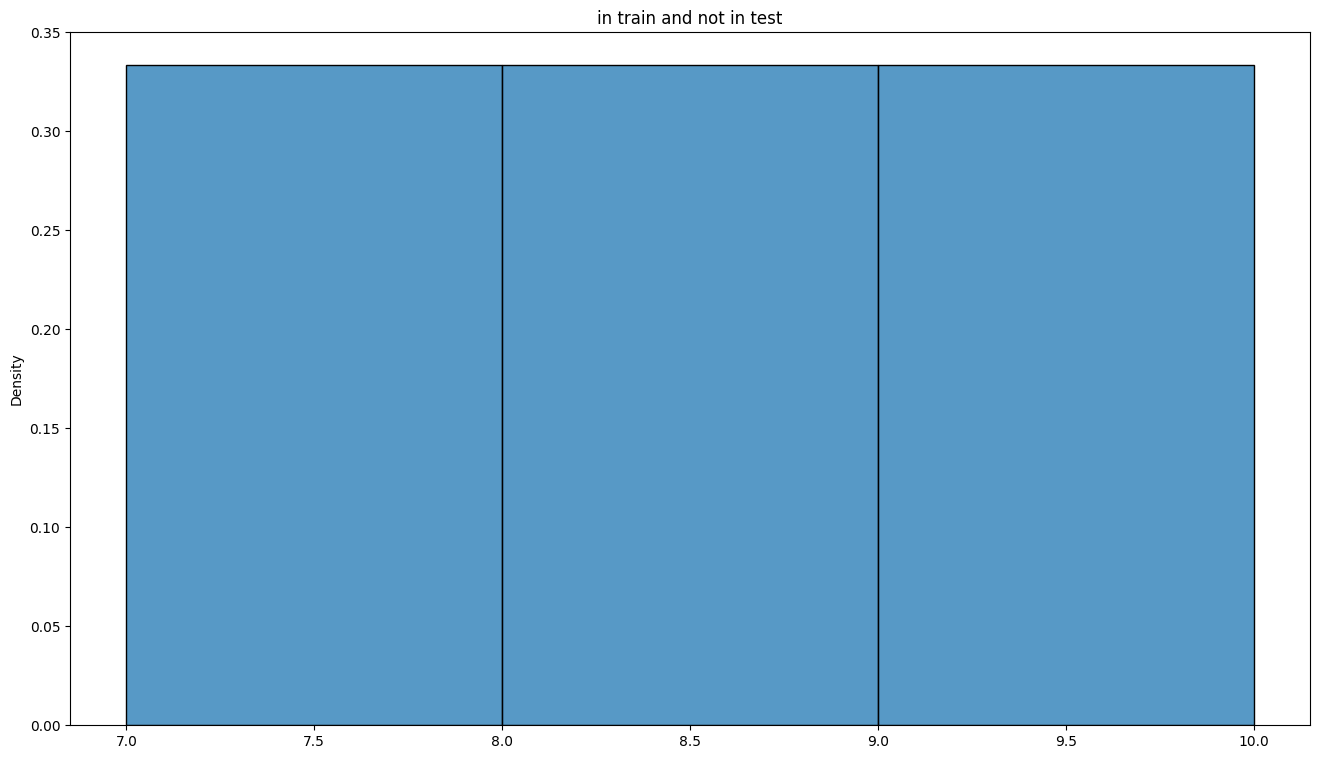

1/4
issue_d
in train
['Jun-2007']


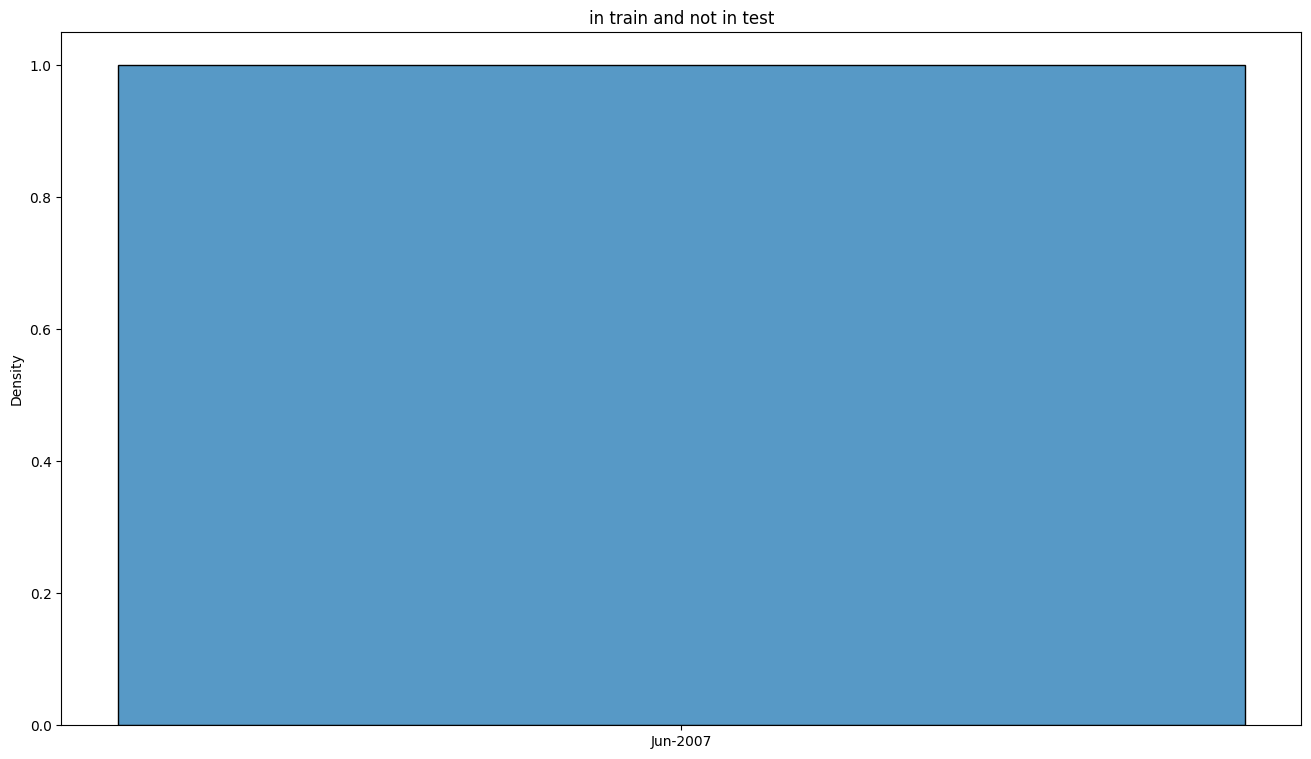

2/4
num_accts_ever_120_pd
in train
[32. 36. 37. 38. 39. 42. 45. 51.]


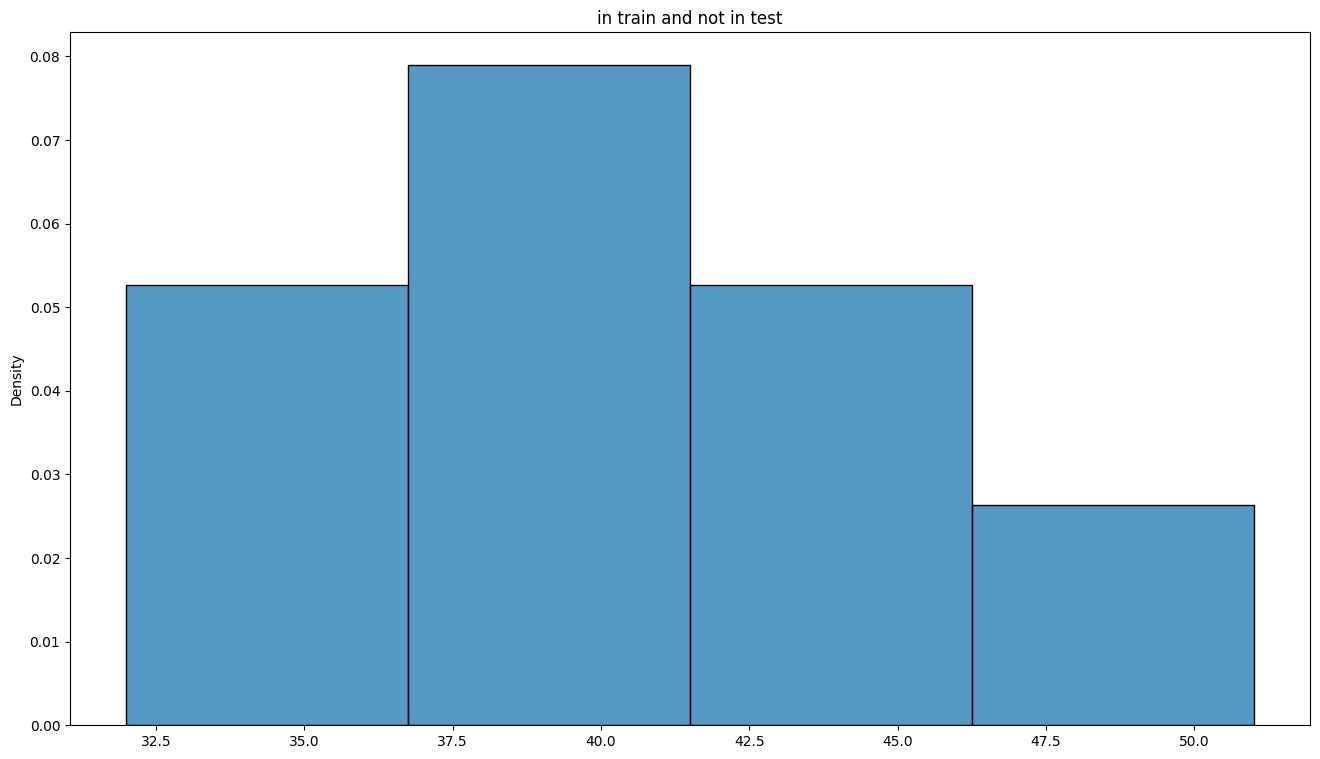

3/4
num_tl_120dpd_2m
in train
[4. 6.]


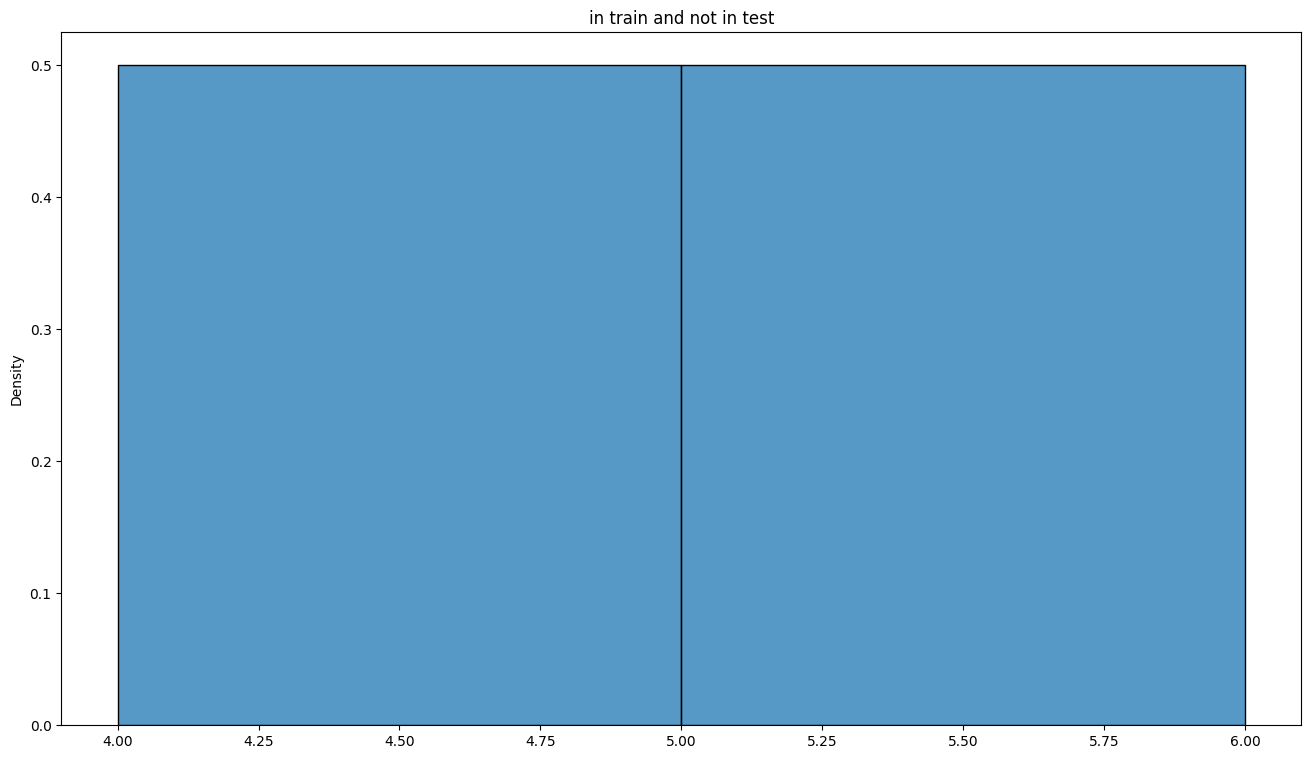

0/2
fico_range_high
in test
[629. 634.]


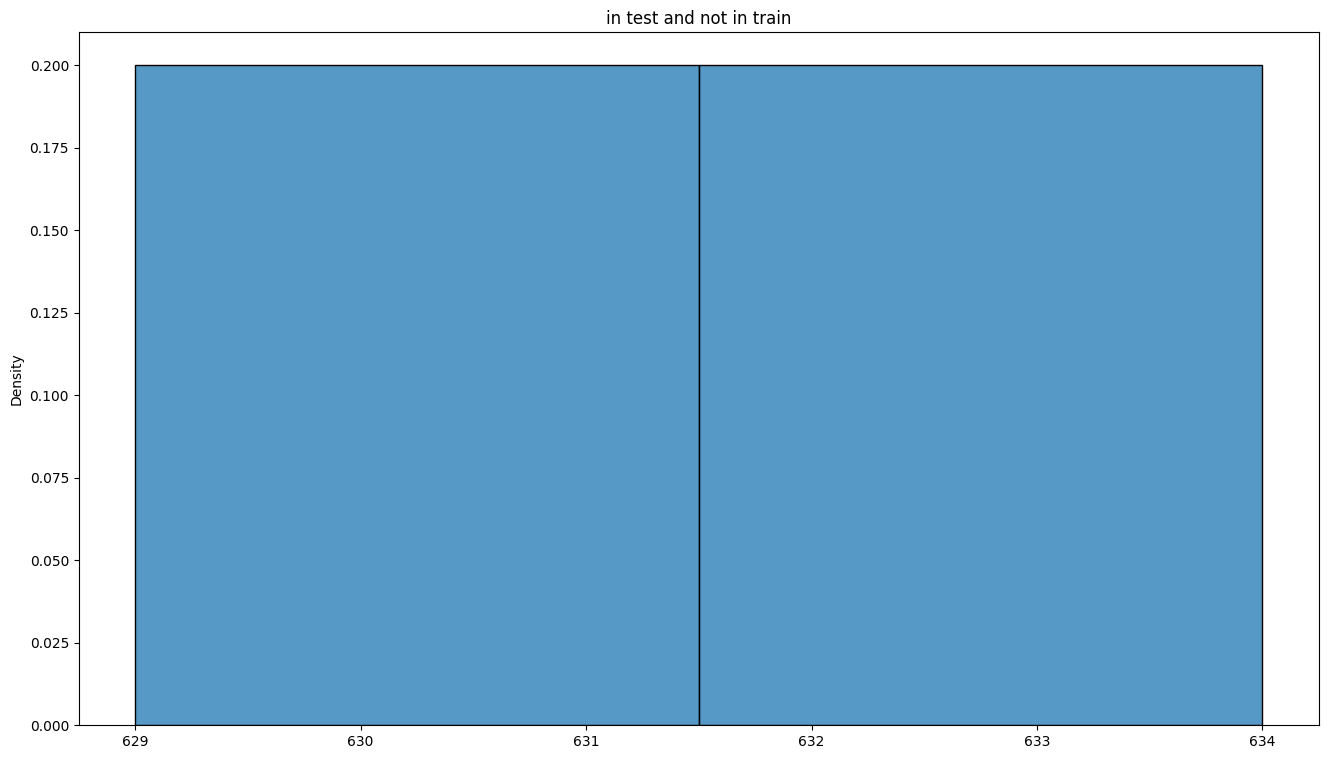

1/2
fico_range_low
in test
[625. 630.]


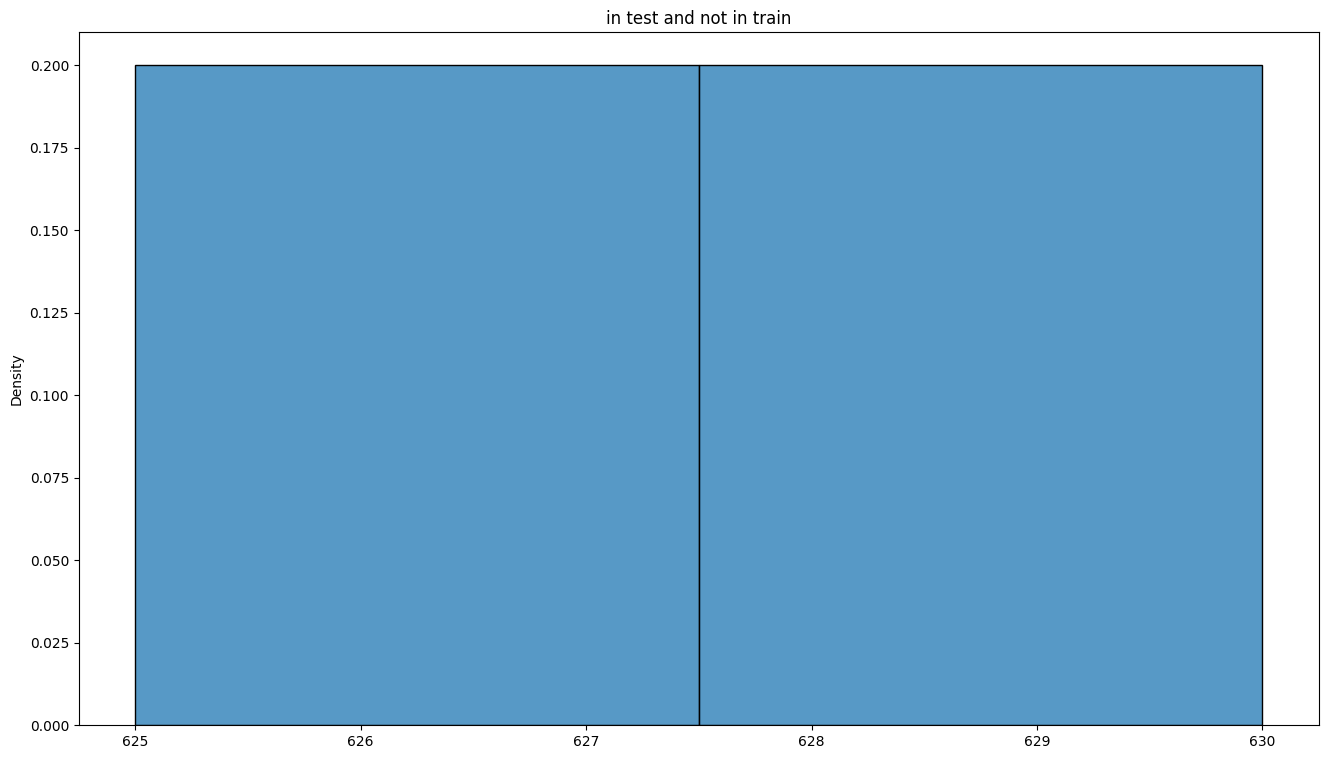

In [17]:
from scipy.stats import ks_2samp
d1_n = []
d1_d = []
d2_n = []
d2_d = []
d1d2_n_pairs = []
d1d2_d_pairs = []
for cName in X:
    if cName == 'index':
        continue
    # print(cName)
    train_data_ = X[cName].values
    test_data_ = X_test[cName].values
    # is same distibution? 
    print(cName)
    stat_test = ks_2samp(train_data_[~pd.isnull(train_data_)],test_data_[~pd.isnull(test_data_)])
    print('stat test without NaN. \n{}\n'.format(stat_test))
    if stat_test.pvalue > 0.05:
        print('mean is same\n')
    else:
        print('mean is different\n')
    train_data_ = np.unique(train_data_[~pd.isnull(train_data_)])
    test_data_ = np.unique(test_data_[~pd.isnull(test_data_)])
    # try :
    # print('train data')
    # display(HTML(pd.DataFrame(train_data_).to_html()))
    # print('test data')
    # display(HTML(pd.DataFrame(test_data_).to_html()))

    # except:
    #     print('error in {}: DIFFERENT TYPES IN ONE ARRAY'.format(cName))
    #     print('train data')
    #     print(set(train_data_))
    #     print('test data')
    #     print(set(test_data_))
    exist_in_train_and_not_exist_in_test =np.setdiff1d(train_data_,test_data_)
    exist_in_test_and_not_exist_in_train =np.setdiff1d(test_data_,train_data_)
    if len(exist_in_train_and_not_exist_in_test) != 0 and len(exist_in_test_and_not_exist_in_train) != 0:
        d1d2_n_pairs.append(cName)
        d1d2_d_pairs.append((exist_in_train_and_not_exist_in_test,exist_in_test_and_not_exist_in_train))
    elif len(exist_in_train_and_not_exist_in_test) != 0:
        d1_n.append(cName)
        d1_d.append(exist_in_train_and_not_exist_in_test)
    elif len(exist_in_test_and_not_exist_in_train) != 0:
        d2_n.append(cName)
        d2_d.append(exist_in_test_and_not_exist_in_train)
    
for i in range(len(d1d2_n_pairs)):
    print('{}/{}'.format(i,len(d1d2_n_pairs)))
    print(d1d2_n_pairs[i])
    fig,ax = plt.subplots(1,2)
    fig.set_size_inches(16,9)
    print('in train')
    print(d1d2_d_pairs[i][0])
    print('in test')
    print(d1d2_d_pairs[i][1])
    if d1d2_n_pairs[i] != 'title':
        sns.histplot(d1d2_d_pairs[i][0],label = d1d2_n_pairs[i],ax=ax[0],stat='density')
        ax[0].set_title('in train and not in test')
        sns.histplot(d1d2_d_pairs[i][1],label = d1d2_n_pairs[i],ax=ax[1],stat='density')
        ax[1].set_title('in test and not in train')
    plt.show()
for i in range(len(d1_n)):
    print('{}/{}'.format(i,len(d1_n)))
    print(d1_n[i])
    print('in train')
    print(d1_d[i])
    fig,ax = plt.subplots()
    fig.set_size_inches(16,9)
    ax.set_title('in train and not in test')
    if d1_n[i] != 'title':
        sns.histplot(d1_d[i],label=d1_n[i],stat='density')
    plt.show()
for i in range(len(d2_n)):
    print('{}/{}'.format(i,len(d2_n)))
    print(d2_n[i])
    print('in test')
    print(d2_d[i])
    fig,ax = plt.subplots()
    fig.set_size_inches(16,9)
    ax.set_title('in test and not in train')
    if d2_n[i] != 'title':
        sns.histplot(d2_d[i],label=d2_n[i],stat='density')
    plt.show()


# get time split on test and train

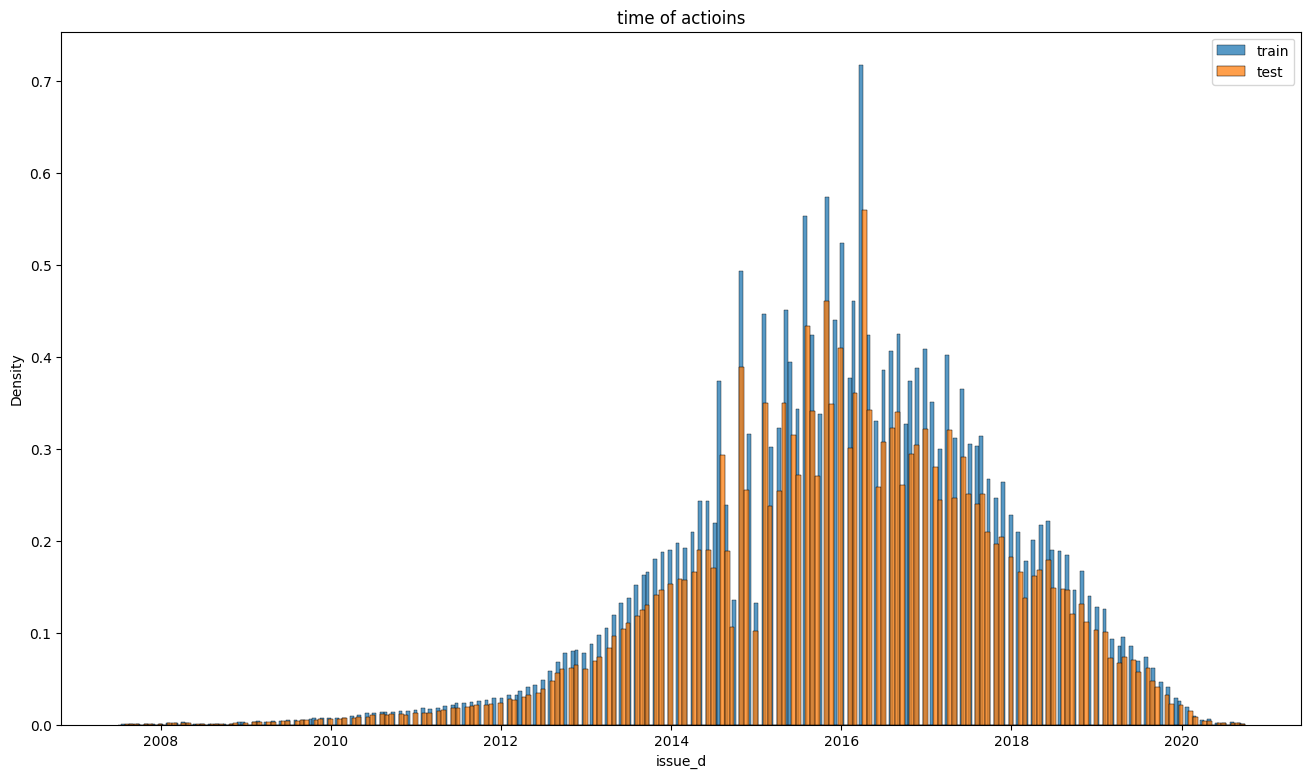

In [ ]:
issue_d_on_test = X_test_dataset['issue_d']
issue_d_on_train = X_train_dataset['issue_d']
fig3,ax3 = plt.subplots()
fig3.set_size_inches(16,9)
sns.histplot(issue_d_on_train,label = 'train',ax=ax3,stat='density')
sns.histplot(issue_d_on_test,label = 'test',ax=ax3,stat='density')
ax3.set_title('time of actioins')
ax3.legend()
